## Load Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
%matplotlib inline


Bad key text.latex.preview in file C:\Users\xps\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\xps\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\xps\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You probably ne

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
sns.set_style("white")

## Load data

In [4]:
account = pd.read_csv('account_dat.csv', parse_dates=['create_dt'])
app = pd.read_csv('app_dat.csv')
category = pd.read_csv('category_ref.csv')
device = pd.read_csv('device_ref.csv')
inapp = pd.read_csv('in-app_dat.csv')
transaction = pd.read_csv('transaction_dat.csv', parse_dates=['create_dt'])

# 1 Data Processing

## 1.1 Explore Data

### Transaction table

In [5]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3607509 entries, 0 to 3607508
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   create_dt   datetime64[ns]
 1   content_id  object        
 2   acct_id     object        
 3   price       float64       
 4   device_id   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 137.6+ MB


In [6]:
transaction = transaction.rename(columns = {'content_id':'transaction_content_id','device_id':'transaction_device_id'})

In [7]:
transaction.isna().sum()

create_dt                 0
transaction_content_id    0
acct_id                   0
price                     0
transaction_device_id     0
dtype: int64

In [8]:
transaction = transaction.rename(columns = {'create_dt':'transaction_dt'})

In [9]:
print("Analysis period starts from ", transaction.transaction_dt.max().date()," ends by ",transaction.transaction_dt.min().date())

Analysis period starts from  2016-09-21  ends by  2016-06-01


In [10]:
# A ratio can be added to calculate the annual metrics 
ratio = (transaction['transaction_dt'].max() - transaction['transaction_dt'].min())/np.timedelta64(1,'D')/365

In [11]:
missing_days = (transaction.transaction_dt.max()- transaction.transaction_dt.min())/np.timedelta64(1,'D') + 1 - transaction.transaction_dt.nunique()
print("There are {} missing days in the data".format(missing_days))

There are 3.0 missing days in the data


In [12]:
len(transaction) - len(transaction.drop_duplicates())

2265

In [13]:
print("There are {} duplicates transaction in the data".format(len(transaction) - len(transaction.drop_duplicates())))

There are 2265 duplicates transaction in the data


In [14]:
duplicates_transaction_rate = round((len(transaction) - len(transaction.drop_duplicates()))/ len(transaction) * 100,2)

In [15]:
print("There is {} % duplicates transaction in the data".format(duplicates_transaction_rate))

There is 0.06 % duplicates transaction in the data


#### The duplicates transaction means the same account download/purchase the same content on the same same device on the same day at the same price more than once. It should be very unlikely to happen. So I will drop the duplicates.

#### Since there is no transaction_id in the data, I cannot be 100% sure if theose the same transactions.

In [16]:
transaction_de_dup = transaction.drop_duplicates()

### Account table

In [17]:
account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   acct_id       100000 non-null  object        
 1   create_dt     100000 non-null  datetime64[ns]
 2   payment_type  100000 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 2.3+ MB


In [18]:
account = account.rename(columns = {'create_dt':'account_create_dt'})

In [19]:
account.head()

,acct_id,account_create_dt,payment_type
0,eb23e449d274bddb,2012-04-03,PMOF
1,3d60dcb8494a0d70,2009-08-31,PMOF
2,9b6d6fbf76504d85,2008-11-06,PMOF
3,343255370828b380,2012-01-03,PMOF
4,664e27f05189c387,2010-10-31,PMOF


In [20]:
len(account) == len(account.drop_duplicates())

True

In [21]:
account.isna().sum()

acct_id              0
account_create_dt    0
payment_type         0
dtype: int64

### App table

In [22]:
app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_name     1000 non-null   object
 1   content_id   1000 non-null   object
 2   category_id  1000 non-null   object
 3   device_id    1000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [23]:
app = app.rename(columns = {'content_id':'parent_app_content_id'})

In [24]:
len(app) == len(app.drop_duplicates())

True

In [25]:
app.isna().sum()

app_name                 0
parent_app_content_id    0
category_id              0
device_id                0
dtype: int64

In [26]:
app.parent_app_content_id.nunique()

1000

In [27]:
app.app_name.nunique()

997

In [28]:
app_duplicates = app.groupby(['app_name']).agg(app_ct =('parent_app_content_id', 'nunique'))
app_duplicates[app_duplicates['app_ct'] >1]

,app_ct
app_name,
#NAME?,4


##### There are 4 duplicates caused by unknown App names. Column 'parent_app_content_id' should be used as unique app identifier. 

### Inapp Table

In [29]:
inapp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2376 entries, 0 to 2375
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   parent_app_content_id  2376 non-null   object
 1   content_id             2376 non-null   object
 2   type                   2376 non-null   object
dtypes: object(3)
memory usage: 55.8+ KB


In [30]:
inapp = inapp.rename(columns = {'type':'inapp_content_type'})

In [31]:
len(inapp) == len(inapp.drop_duplicates())

True

In [32]:
inapp.isna().sum()

parent_app_content_id    0
content_id               0
inapp_content_type       0
dtype: int64

In [33]:
inapp.parent_app_content_id.nunique()

476

In [34]:
inapp.content_id.nunique()

2376

In [35]:
inapp.inapp_content_type.nunique()

2

In [36]:
inapp.inapp_content_type.unique()

array(['consumable', 'subscription'], dtype=object)

#### There are fewer parent_app_content_id in Inapp table comapred to that in App table. In that case, there would be content cannot join with columns in the App table. 

### Device Table

In [37]:
device.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   device_name  3 non-null      object
 1   device_id    3 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 176.0+ bytes


In [38]:
len(device) == len(device.drop_duplicates())

True

In [39]:
device.isna().sum()

device_name    0
device_id      0
dtype: int64

In [40]:
device.device_name.nunique()

3

In [41]:
device.device_name.unique()

array(['iPhone', 'iPad', 'Both'], dtype=object)

### Category Table

In [42]:
category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_name  5 non-null      object
 1   category_id    5 non-null      object
dtypes: object(2)
memory usage: 208.0+ bytes


In [43]:
len(category) == len(category.drop_duplicates())

True

In [44]:
category.isna().sum()

category_name    0
category_id      0
dtype: int64

In [45]:
category.category_name.nunique()

5

In [46]:
category.category_name.unique()

array(['Games', 'Social Networking', 'Utilities', 'Entertainment',
       'Photos & Videos'], dtype=object)

## 1.2 Join App with inApp, app device table and category table

In [47]:
app.head()

,app_name,parent_app_content_id,category_id,device_id
0,half-slouched having,22dfac9721b899cb,Y-8,3
1,lift whale-ships,7c645810cd7f166e,M-7,3
2,mightily community,c495bcb878faffaa,Y-8,2
3,session: too--shall,4e683dcd461cdd22,Y-8,1
4,That Zoology,6473dd29a2badbf1,Y-8,3


In [48]:
inapp.head()

,parent_app_content_id,content_id,inapp_content_type
0,d2bde35599e0dae9,227227a77c59809b,consumable
1,d2bde35599e0dae9,41ac2362a2600185,consumable
2,d2bde35599e0dae9,64a8e16f030bb611,consumable
3,d2bde35599e0dae9,2c8ba424183afa7c,consumable
4,d2bde35599e0dae9,b4c42fa5cc420f7b,consumable


In [49]:
app_inapp = app.merge(inapp, on = 'parent_app_content_id', how = 'outer')
# Using outer join in case there are parent_app_content_id in one table but not the other table.

In [50]:
app_inapp.isnull().sum()

app_name                   0
parent_app_content_id      0
category_id                0
device_id                  0
content_id               524
inapp_content_type       524
dtype: int64

In [51]:
app_inapp[app_inapp['content_id'].isna()].head()

,app_name,parent_app_content_id,category_id,device_id,content_id,inapp_content_type
17,pro- chick,a287d248d66f915b,Z-1,1,NaN,NaN
26,expansive utter,947d085ce02c9b0e,Z-1,3,NaN,NaN
27,noting Dry,3e8d4ceb1d7294c4,M-7,3,NaN,NaN
28,bunk bringing,019008a4dabf7c93,Z-1,3,NaN,NaN
31,unobservant sorts,04d7461141bb1485,Z-1,3,NaN,NaN


In [52]:
app_df = app_inapp.merge(category, on = 'category_id', how = 'left')\
                .merge(device, on = 'device_id', how = 'left')

In [53]:
app_df = app_df.rename(columns = {'device_id':'app_device_id','device_name':'app_device_name'})

In [54]:
app_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   app_name               2900 non-null   object
 1   parent_app_content_id  2900 non-null   object
 2   category_id            2900 non-null   object
 3   app_device_id          2900 non-null   int64 
 4   content_id             2376 non-null   object
 5   inapp_content_type     2376 non-null   object
 6   category_name          2900 non-null   object
 7   app_device_name        2900 non-null   object
dtypes: int64(1), object(7)
memory usage: 203.9+ KB


In [55]:
app_df.head()

,app_name,parent_app_content_id,category_id,app_device_id,content_id,inapp_content_type,category_name,app_device_name
0,half-slouched having,22dfac9721b899cb,Y-8,3,f049e141e84edd84,consumable,Photos & Videos,Both
1,lift whale-ships,7c645810cd7f166e,M-7,3,ef891bdc2d651c70,consumable,Utilities,Both
2,mightily community,c495bcb878faffaa,Y-8,2,107aece323e389df,consumable,Photos & Videos,iPad
3,mightily community,c495bcb878faffaa,Y-8,2,77389dc3f8108c77,consumable,Photos & Videos,iPad
4,session: too--shall,4e683dcd461cdd22,Y-8,1,abfa638eb85a98f3,consumable,Photos & Videos,iPhone


In [56]:
app_df.isna().sum()

app_name                   0
parent_app_content_id      0
category_id                0
app_device_id              0
content_id               524
inapp_content_type       524
category_name              0
app_device_name            0
dtype: int64

In [57]:
app_df[app_df['content_id'].isna()].head()

,app_name,parent_app_content_id,category_id,app_device_id,content_id,inapp_content_type,category_name,app_device_name
17,pro- chick,a287d248d66f915b,Z-1,1,NaN,NaN,Games,iPhone
26,expansive utter,947d085ce02c9b0e,Z-1,3,NaN,NaN,Games,Both
27,noting Dry,3e8d4ceb1d7294c4,M-7,3,NaN,NaN,Utilities,Both
28,bunk bringing,019008a4dabf7c93,Z-1,3,NaN,NaN,Games,Both
31,unobservant sorts,04d7461141bb1485,Z-1,3,NaN,NaN,Games,Both


In [58]:
app_df[app_df['content_id'].isna()]['parent_app_content_id'].nunique()

524

In [59]:
## Since content_id would be the join key later on, it can not be NaN. Some transaction_contetn_id is the parent_app_contetn_id based on data exploartion. I added a new column for those has no contetn_id. 
app_df['content_id_modified'] = app_df['content_id'].fillna(app_df['parent_app_content_id'])

In [60]:
app_df[app_df['content_id'].isna()].head()

,app_name,parent_app_content_id,category_id,app_device_id,content_id,inapp_content_type,category_name,app_device_name,content_id_modified
17,pro- chick,a287d248d66f915b,Z-1,1,NaN,NaN,Games,iPhone,a287d248d66f915b
26,expansive utter,947d085ce02c9b0e,Z-1,3,NaN,NaN,Games,Both,947d085ce02c9b0e
27,noting Dry,3e8d4ceb1d7294c4,M-7,3,NaN,NaN,Utilities,Both,3e8d4ceb1d7294c4
28,bunk bringing,019008a4dabf7c93,Z-1,3,NaN,NaN,Games,Both,019008a4dabf7c93
31,unobservant sorts,04d7461141bb1485,Z-1,3,NaN,NaN,Games,Both,04d7461141bb1485


In [61]:
app_df.isna().sum()

app_name                   0
parent_app_content_id      0
category_id                0
app_device_id              0
content_id               524
inapp_content_type       524
category_name              0
app_device_name            0
content_id_modified        0
dtype: int64

## 1.3 Clean up App name

In [62]:
app_df['app_name'] = app_df['app_name'].str.replace('(^\s+|\;|\-|\,|\:|\)|\()', '', regex=True).str.strip().str.title()

## 1.4 Join transaction table with App info

In [63]:
transaction_de_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3605244 entries, 0 to 3607508
Data columns (total 5 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   transaction_dt          datetime64[ns]
 1   transaction_content_id  object        
 2   acct_id                 object        
 3   price                   float64       
 4   transaction_device_id   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 165.0+ MB


In [64]:
df = transaction_de_dup.merge(app_df, left_on = 'transaction_content_id', right_on = 'content_id_modified', how = 'left')
# using 'content_id_modified' as the join key to avoid joining on NaN

In [65]:
len(transaction_de_dup) == len(df)

True

There is no duplcates coming from the join.

In [66]:
df.isna().sum()

transaction_dt                  0
transaction_content_id          0
acct_id                         0
price                           0
transaction_device_id           0
app_name                   133813
parent_app_content_id      133813
category_id                133813
app_device_id              133813
content_id                1592956
inapp_content_type        1592956
category_name              133813
app_device_name            133813
content_id_modified        133813
dtype: int64

In [67]:
df[df['parent_app_content_id'].isna()].head()

,transaction_dt,transaction_content_id,acct_id,price,transaction_device_id,app_name,parent_app_content_id,category_id,app_device_id,content_id,inapp_content_type,category_name,app_device_name,content_id_modified
2919284,2016-06-01,8590a25d4e5c249c,fe74807487952ae6,0.00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2919285,2016-06-02,8590a25d4e5c249c,0697cfc8d4d6e72b,0.00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2919286,2016-06-03,8590a25d4e5c249c,3a77f468533d8813,0.00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2919287,2016-06-03,8590a25d4e5c249c,9bad32e3148bf35f,0.00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2919288,2016-06-04,8590a25d4e5c249c,230b065f584de1c3,0.00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some content_id cannot be joined by column content_id, but can be joined by parent_app_content_id.

In [68]:
df_fix = df[df['parent_app_content_id'].isna()][['transaction_dt', 'transaction_content_id', 'acct_id', 'price','transaction_device_id']]\
                .merge(app_df[['app_name', 'parent_app_content_id', 'category_id','category_name', 'app_device_id', 'app_device_name']], left_on = 'transaction_content_id', right_on = 'parent_app_content_id', how = 'left')

In [69]:
df_fix.isna().sum()

transaction_dt            0
transaction_content_id    0
acct_id                   0
price                     0
transaction_device_id     0
app_name                  0
parent_app_content_id     0
category_id               0
category_name             0
app_device_id             0
app_device_name           0
dtype: int64

In [70]:
df_fix.head()

,transaction_dt,transaction_content_id,acct_id,price,transaction_device_id,app_name,parent_app_content_id,category_id,category_name,app_device_id,app_device_name
0,2016-06-01,8590a25d4e5c249c,fe74807487952ae6,0.00,2,Unwritten Hungry,8590a25d4e5c249c,Z-1,Games,2,iPad
1,2016-06-01,8590a25d4e5c249c,fe74807487952ae6,0.00,2,Unwritten Hungry,8590a25d4e5c249c,Z-1,Games,2,iPad
2,2016-06-01,8590a25d4e5c249c,fe74807487952ae6,0.00,2,Unwritten Hungry,8590a25d4e5c249c,Z-1,Games,2,iPad
3,2016-06-01,8590a25d4e5c249c,fe74807487952ae6,0.00,2,Unwritten Hungry,8590a25d4e5c249c,Z-1,Games,2,iPad
4,2016-06-01,8590a25d4e5c249c,fe74807487952ae6,0.00,2,Unwritten Hungry,8590a25d4e5c249c,Z-1,Games,2,iPad


In [71]:
len(df_fix)
# There are duplciates since 1 app can have multiple content_ids. 

893124

In [72]:
len(df_fix.drop_duplicates()) == len(df[df['parent_app_content_id'].isna()])

True

In [73]:
len(df[~df['parent_app_content_id'].isna()]) + len(df_fix.drop_duplicates()) == len(transaction_de_dup)

True

There is no duplicates after de-dup.

In [74]:
# Union the two parts together
df_txn_app = pd.concat([df[~df['parent_app_content_id'].isna()][['transaction_dt', 'transaction_content_id', 'acct_id', 'price',
       'transaction_device_id', 'app_name', 'parent_app_content_id','category_id','category_name', 'app_device_id', 'app_device_name']], df_fix.drop_duplicates()], ignore_index=True)

In [75]:
len(df_txn_app) == len(transaction_de_dup)

True

In [76]:
df_txn_app.head()

,transaction_dt,transaction_content_id,acct_id,price,transaction_device_id,app_name,parent_app_content_id,category_id,category_name,app_device_id,app_device_name
0,2016-08-28,b6cf4f33e7455df4,220574a7a6a71afa,11.99,1,Events Bildad'S,61cea77b9bc843d1,M-7,Utilities,3.00,Both
1,2016-09-16,71ac3e9c38ddbbba,8551f69a5015ea6a,1.99,2,Swell Questionably,1f0ebd67df5846cd,M-7,Utilities,3.00,Both
2,2016-08-15,776b851b916c33d1,7dedf309494a1966,0.99,2,Supperlessmy Shipmates,1383e4f2f49f0f44,Z-1,Games,2.00,iPad
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,Unwritten Hungry,8590a25d4e5c249c,Z-1,Games,2.00,iPad
4,2016-06-13,30581219bc952dbb,35aaf59d64a677e7,11.99,2,Turning Thanked,478e10f9248b7842,Q-1,Entertainment,3.00,Both


In [77]:
df_txn_app.isna().sum()

transaction_dt            0
transaction_content_id    0
acct_id                   0
price                     0
transaction_device_id     0
app_name                  0
parent_app_content_id     0
category_id               0
category_name             0
app_device_id             0
app_device_name           0
dtype: int64

In [78]:
df_txn_app_final = df_txn_app.merge(app_df[['content_id','inapp_content_type']], left_on = 'transaction_content_id', right_on = 'content_id', how = 'left')

In [79]:
df_txn_app_final.head()

,transaction_dt,transaction_content_id,acct_id,price,transaction_device_id,app_name,parent_app_content_id,category_id,category_name,app_device_id,app_device_name,content_id,inapp_content_type
0,2016-08-28,b6cf4f33e7455df4,220574a7a6a71afa,11.99,1,Events Bildad'S,61cea77b9bc843d1,M-7,Utilities,3.00,Both,b6cf4f33e7455df4,subscription
1,2016-09-16,71ac3e9c38ddbbba,8551f69a5015ea6a,1.99,2,Swell Questionably,1f0ebd67df5846cd,M-7,Utilities,3.00,Both,71ac3e9c38ddbbba,consumable
2,2016-08-15,776b851b916c33d1,7dedf309494a1966,0.99,2,Supperlessmy Shipmates,1383e4f2f49f0f44,Z-1,Games,2.00,iPad,776b851b916c33d1,consumable
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,Unwritten Hungry,8590a25d4e5c249c,Z-1,Games,2.00,iPad,7a47ca132a8dc695,consumable
4,2016-06-13,30581219bc952dbb,35aaf59d64a677e7,11.99,2,Turning Thanked,478e10f9248b7842,Q-1,Entertainment,3.00,Both,30581219bc952dbb,consumable


In [80]:
len(df_txn_app_final)  == len(transaction_de_dup)

True

In [81]:
df_txn_app_final.isna().sum()

transaction_dt                  0
transaction_content_id          0
acct_id                         0
price                           0
transaction_device_id           0
app_name                        0
parent_app_content_id           0
category_id                     0
category_name                   0
app_device_id                   0
app_device_name                 0
content_id                1592956
inapp_content_type        1592956
dtype: int64

## 1.5 Join transaction table with device and account table

In [82]:
device.head()

,device_name,device_id
0,iPhone,1
1,iPad,2
2,Both,3


In [83]:
transaction_df = df_txn_app_final.merge(device, left_on = 'transaction_device_id', right_on = 'device_id', how = 'left')\
                                 .merge(account, on = 'acct_id', how = 'left')
transaction_df = transaction_df.rename(columns = {'device_name':'transaction_device_name'})
transaction_df = transaction_df.drop(['device_id'], axis = 1)

In [84]:
transaction_df.head()

,transaction_dt,transaction_content_id,acct_id,price,transaction_device_id,app_name,parent_app_content_id,category_id,category_name,app_device_id,app_device_name,content_id,inapp_content_type,transaction_device_name,account_create_dt,payment_type
0,2016-08-28,b6cf4f33e7455df4,220574a7a6a71afa,11.99,1,Events Bildad'S,61cea77b9bc843d1,M-7,Utilities,3.00,Both,b6cf4f33e7455df4,subscription,iPhone,2009-08-29,PMOF
1,2016-09-16,71ac3e9c38ddbbba,8551f69a5015ea6a,1.99,2,Swell Questionably,1f0ebd67df5846cd,M-7,Utilities,3.00,Both,71ac3e9c38ddbbba,consumable,iPad,2011-05-28,PMOF
2,2016-08-15,776b851b916c33d1,7dedf309494a1966,0.99,2,Supperlessmy Shipmates,1383e4f2f49f0f44,Z-1,Games,2.00,iPad,776b851b916c33d1,consumable,iPad,2009-11-15,PMOF
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,Unwritten Hungry,8590a25d4e5c249c,Z-1,Games,2.00,iPad,7a47ca132a8dc695,consumable,iPad,2009-03-01,PMOF
4,2016-06-13,30581219bc952dbb,35aaf59d64a677e7,11.99,2,Turning Thanked,478e10f9248b7842,Q-1,Entertainment,3.00,Both,30581219bc952dbb,consumable,iPad,2010-10-01,PMOF


In [85]:
transaction_df.isna().sum()

transaction_dt                   0
transaction_content_id           0
acct_id                          0
price                            0
transaction_device_id            0
app_name                         0
parent_app_content_id            0
category_id                      0
category_name                    0
app_device_id                    0
app_device_name                  0
content_id                 1592956
inapp_content_type         1592956
transaction_device_name          0
account_create_dt             2741
payment_type                  2741
dtype: int64

In [86]:
transaction_df[transaction_df['account_create_dt'].isna()].head()

,transaction_dt,transaction_content_id,acct_id,price,transaction_device_id,app_name,parent_app_content_id,category_id,category_name,app_device_id,app_device_name,content_id,inapp_content_type,transaction_device_name,account_create_dt,payment_type
1208,2016-07-02,a792117e156607c2,9488918622974672,2.99,1,Sleet'S Perceived,21ae2d63b7280de1,Q-5,Social Networking,1.00,iPhone,a792117e156607c2,consumable,iPhone,NaT,NaN
2511,2016-07-14,cc6e70d345f85276,4349884688257852,3.99,1,Words Hospitable,d9ac236641bd3859,Z-1,Games,3.00,Both,cc6e70d345f85276,consumable,iPhone,NaT,NaN
2714,2016-06-01,03230f058d847c64,1620038656801380,12.99,1,Startthe Buttertwenty,9f209b69e6c6de9e,Z-1,Games,3.00,Both,03230f058d847c64,consumable,iPhone,NaT,NaN
3335,2016-06-08,02f812e3c914b878,1919129874916410,8.99,1,Clayey Courteously,65b4d55761b9b52c,Z-1,Games,3.00,Both,02f812e3c914b878,consumable,iPhone,NaT,NaN
4216,2016-08-19,fa35fc98975a6c4e,1984215081970279,14.99,1,Animals Levels,ac9b3b9697787ad8,Z-1,Games,3.00,Both,fa35fc98975a6c4e,consumable,iPhone,NaT,NaN


In [87]:
transaction_df[transaction_df['account_create_dt'].isna()]['acct_id'].nunique()

25

In [88]:
len(transaction_df) == len(transaction_de_dup)

True

In [89]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3605244 entries, 0 to 3605243
Data columns (total 16 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_dt           datetime64[ns]
 1   transaction_content_id   object        
 2   acct_id                  object        
 3   price                    float64       
 4   transaction_device_id    int64         
 5   app_name                 object        
 6   parent_app_content_id    object        
 7   category_id              object        
 8   category_name            object        
 9   app_device_id            float64       
 10  app_device_name          object        
 11  content_id               object        
 12  inapp_content_type       object        
 13  transaction_device_name  object        
 14  account_create_dt        datetime64[ns]
 15  payment_type             object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(11)
memory usage: 467

In [90]:
transaction_df['transaction_device_id'] = transaction_df['transaction_device_id'].astype('object')
transaction_df['app_device_id'] = transaction_df['app_device_id'].astype('object')

In [91]:
transaction_df.describe()

,price
count,"3,605,244.00"
mean,5.28
std,6.96
min,0.00
25%,0.00
50%,1.99
75%,7.99
max,29.99


## 1.6 Detect outliers

### Account level summery

In [92]:
spend_per_account = transaction_df.pivot_table(index = ['acct_id'], columns = ['category_name'], values = ['price'], aggfunc = sum).fillna(0)

In [93]:
spend_per_account.columns = spend_per_account.columns.droplevel(0)
spend_per_account = spend_per_account.reset_index()
spend_per_account.columns = ['acct_id', 'Entertainment_revenue', 'Games_revenue', 'Photos & Videos_revenue','Social Networking_revenue', 'Utilities_revenue']

In [94]:
txn_per_account = transaction_df.groupby(['acct_id']).agg(total_revenue = ('price',sum))
txn_per_account['total_txn'] = transaction_df.groupby(['acct_id']).size()
txn_per_account['paid_acct_flag'] = np.where(txn_per_account['total_revenue']>0 ,'Purchased Paid App', 'Free Only')
txn_per_account = txn_per_account.reset_index()

In [95]:
account_summary = account.merge(spend_per_account, on ='acct_id', how = 'left')\
                    .merge(txn_per_account, on = 'acct_id', how = 'left')
account_summary = account_summary.fillna(0)
account_summary['no_txn_flag'] = np.where(account_summary['total_txn'] == 0, 'Dormant', 'Active')
account_summary['paid_acct_flag'] = account_summary['paid_acct_flag'].replace(0,'Dormant')

In [96]:
account_summary['acct_tenure'] = transaction['transaction_dt'].max() - account_summary['account_create_dt']
account_summary['acct_tenure_days'] = account_summary['acct_tenure']/np.timedelta64(1,'D')
account_summary['acct_tenure_months'] = account_summary['acct_tenure']/np.timedelta64(1,'M')
account_summary['acct_tenure_years'] = account_summary['acct_tenure']/np.timedelta64(1,'Y')

In [97]:
tenure_cut_labels = ['no account','1 month', '2- 6 months', '6 months - 1 year', '1- 3 years','3 - 5 years', '5 years+']
tenure_cut_bins = [account_summary['acct_tenure_months'].min(), 0, 1, 6, 12,36, 60, account_summary['acct_tenure_months'].max()]
account_summary['Tenure_Band'] = pd.cut(account_summary['acct_tenure_months'], bins = tenure_cut_bins, labels = tenure_cut_labels)

In [98]:
account_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype          
---  ------                     --------------   -----          
 0   acct_id                    100000 non-null  object         
 1   account_create_dt          100000 non-null  datetime64[ns] 
 2   payment_type               100000 non-null  object         
 3   Entertainment_revenue      100000 non-null  float64        
 4   Games_revenue              100000 non-null  float64        
 5   Photos & Videos_revenue    100000 non-null  float64        
 6   Social Networking_revenue  100000 non-null  float64        
 7   Utilities_revenue          100000 non-null  float64        
 8   total_revenue              100000 non-null  float64        
 9   total_txn                  100000 non-null  float64        
 10  paid_acct_flag             100000 non-null  object         
 11  no_txn_flag                100000 non-nu

In [99]:
account_summary.head()

,acct_id,account_create_dt,payment_type,Entertainment_revenue,Games_revenue,Photos & Videos_revenue,Social Networking_revenue,Utilities_revenue,total_revenue,total_txn,paid_acct_flag,no_txn_flag,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years,Tenure_Band
0,eb23e449d274bddb,2012-04-03,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,1632 days,"1,632.00",53.62,4.47,3 - 5 years
1,3d60dcb8494a0d70,2009-08-31,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,2578 days,"2,578.00",84.70,7.06,5 years+
2,9b6d6fbf76504d85,2008-11-06,PMOF,77.87,897.20,276.61,64.92,52.90,"1,369.50",159.00,Purchased Paid App,Active,2876 days,"2,876.00",94.49,7.87,5 years+
3,343255370828b380,2012-01-03,PMOF,103.86,591.34,181.66,74.93,59.87,"1,011.66",141.00,Purchased Paid App,Active,1723 days,"1,723.00",56.61,4.72,3 - 5 years
4,664e27f05189c387,2010-10-31,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,2152 days,"2,152.00",70.70,5.89,5 years+


In [100]:
len(account_summary) == len(account)

True

In [101]:
account_summary.describe()

,Entertainment_revenue,Games_revenue,Photos & Videos_revenue,Social Networking_revenue,Utilities_revenue,total_revenue,total_txn,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years
count,"100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00","100,000.00",100000,"100,000.00","100,000.00","100,000.00"
mean,13.96,122.54,34.18,6.25,13.35,190.29,36.03,1508 days 11:45:55.008000,"1,508.49",49.56,4.13
std,48.73,365.13,119.91,23.11,45.03,593.43,75.01,1051 days 14:43:16.254503920,"1,051.61",34.55,2.88
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-309 days +00:00:00,-309.00,-10.15,-0.85
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,596 days 00:00:00,596.00,19.58,1.63
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1508 days 00:00:00,"1,508.00",49.55,4.13
75%,0.00,0.00,0.00,0.00,0.00,0.00,74.00,2412 days 00:00:00,"2,412.00",79.25,6.60
max,"1,329.47","7,164.88","2,752.94",639.15,"1,095.44","11,799.75","1,353.00",3344 days 00:00:00,"3,344.00",109.87,9.16


In [102]:
account_summary[(account_summary['total_revenue'] == account_summary['total_revenue'].max()) | (account_summary['total_txn'] == account_summary['total_txn'].max())]

,acct_id,account_create_dt,payment_type,Entertainment_revenue,Games_revenue,Photos & Videos_revenue,Social Networking_revenue,Utilities_revenue,total_revenue,total_txn,paid_acct_flag,no_txn_flag,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years,Tenure_Band
20887,14d524ac4549e0af,2008-04-06,PMOF,"1,052.45","6,924.04","2,473.34",425.39,924.53,"11,799.75","1,334.00",Purchased Paid App,Active,3090 days,"3,090.00",101.52,8.46,5 years+
43001,025488c9dcfdee47,2012-10-25,PMOF,956.51,"6,875.97","2,192.33",501.23,840.52,"11,366.56","1,353.00",Purchased Paid App,Active,1427 days,"1,427.00",46.88,3.91,3 - 5 years


There are extreme values (outliers).

In [103]:
txn_acct = account_summary.groupby(['no_txn_flag']).agg(no_txn_acct_ct = ('acct_id', 'nunique'))

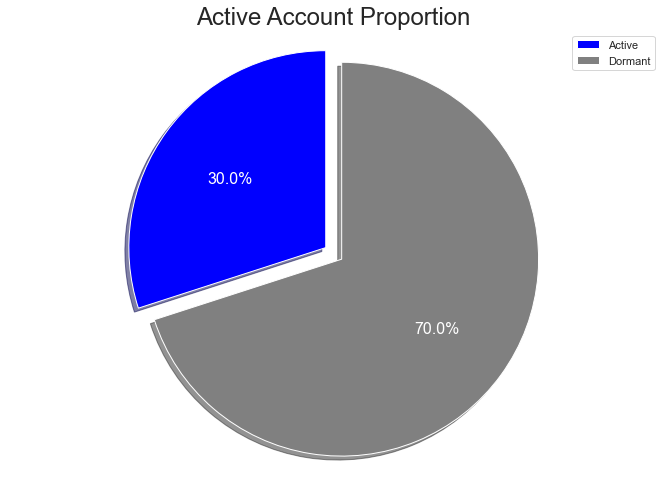

In [104]:
fig1, ax1 = plt.subplots()
ax1.pie(txn_acct.no_txn_acct_ct, explode= (0, 0.1) , labels= txn_acct.index, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['blue','grey'], textprops={'color':"w",'size':16})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Active Account Proportion', fontsize=24)
plt.legend(loc="best")
plt.show()

### Avg spend per account to detect outliers

In [105]:
paid = account_summary.groupby(['paid_acct_flag']).agg(paid_acct_ct = ('acct_id', 'nunique'))

In [106]:
paid

,paid_acct_ct
paid_acct_flag,
Dormant,70025
Free Only,14993
Purchased Paid App,14982


In [107]:
paid.to_csv('paid.csv')

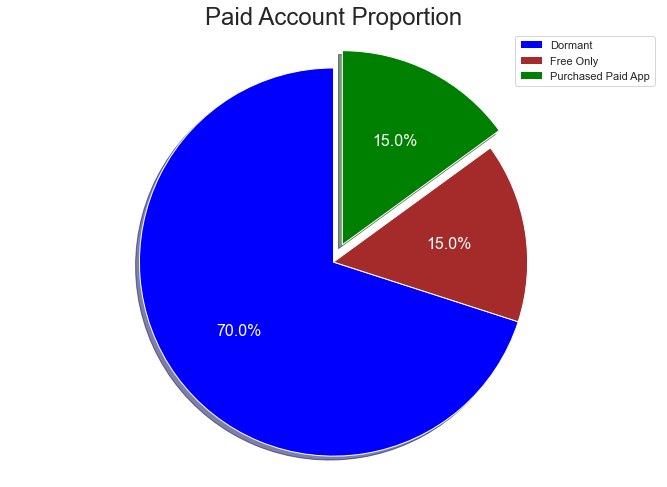

In [108]:
fig1, ax1 = plt.subplots()
ax1.pie(paid.paid_acct_ct, explode= (0, 0, 0.1) , labels= paid.index, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['blue','brown','green'], textprops={'color':"w",'size':16})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Paid Account Proportion', fontsize=24)
plt.legend(loc="best")
plt.show()

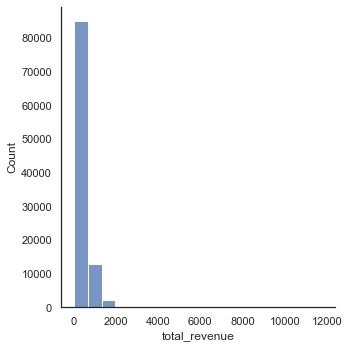

In [109]:
sns.displot(account_summary, x='total_revenue')

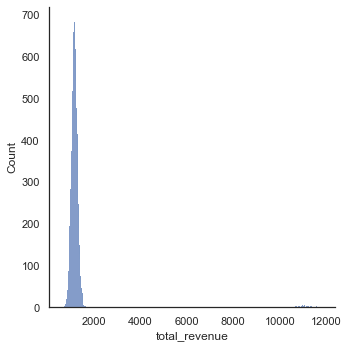

In [110]:
sns.displot(account_summary[account_summary['total_revenue'] != 0], x='total_revenue')

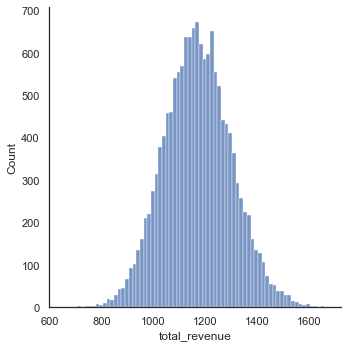

In [111]:
sns.displot(account_summary[(account_summary['total_revenue'] != 0) & (account_summary['total_revenue'] <= 2000)], x='total_revenue')

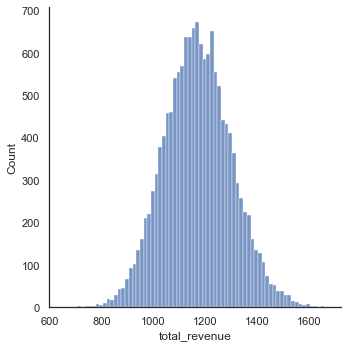

In [112]:
sns.displot(account_summary[(account_summary['total_revenue'] != 0) & (account_summary['total_revenue'] <= 10000)], x='total_revenue')

#### Accounts with more than 10,000 spend in the 110 days are considered as outliers, and will be excluded from this analysis. 

In [113]:
outliers1 = account_summary[account_summary['total_revenue'] > 10000]['acct_id']

In [114]:
print("In total, there are {} outliers caused by spend amount.".format(outliers1.nunique()))

In total, there are 150 outliers caused by spend amount.


### Avg number of transactions per account to detect outliers

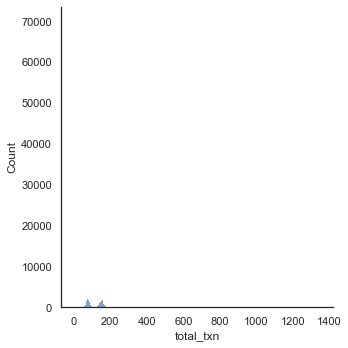

In [115]:
sns.displot(account_summary, x='total_txn')

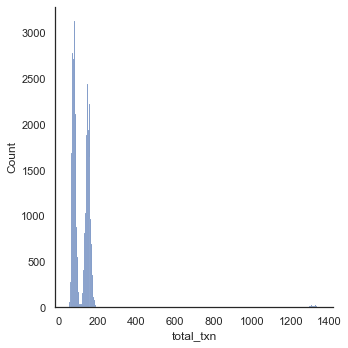

In [116]:
sns.displot(account_summary[account_summary['total_txn'] != 0], x='total_txn')

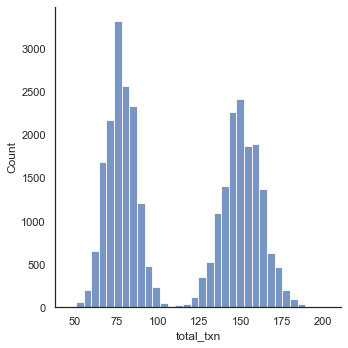

In [117]:
sns.displot(account_summary[(account_summary['total_txn'] != 0) & (account_summary['total_txn'] <= 1000)], x='total_txn')

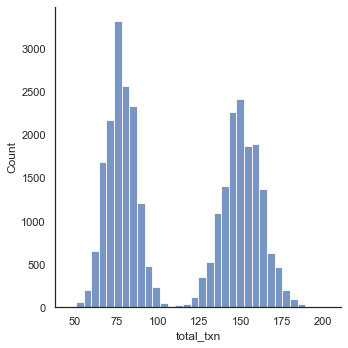

In [118]:
sns.displot(account_summary[(account_summary['total_txn'] != 0) & (account_summary['total_txn'] <= 400)], x='total_txn')

#### Accounts with more than 1,000 transactions in the 110 days are considered as outliers, and will be excluded from this analysis. 

In [119]:
outliers2 = account_summary[account_summary['total_txn'] > 1000]['acct_id']

In [120]:
print("In total, there are {} outliers caused by transaction number.".format(outliers2.nunique()))

In total, there are 150 outliers caused by transaction number.


In [121]:
account_summary[(account_summary['total_txn'] <= 1000) & (account_summary['total_revenue'] <= 10000)].describe()

,Entertainment_revenue,Games_revenue,Photos & Videos_revenue,Social Networking_revenue,Utilities_revenue,total_revenue,total_txn,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years
count,"99,850.00","99,850.00","99,850.00","99,850.00","99,850.00","99,850.00","99,850.00",99850,"99,850.00","99,850.00","99,850.00"
mean,12.56,113.21,30.58,5.59,12.09,174.02,34.10,1507 days 02:41:25.279919888,"1,507.11",49.52,4.13
std,32.38,274.50,75.43,15.34,30.86,419.64,56.24,1051 days 14:03:19.558064464,"1,051.59",34.55,2.88
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-309 days +00:00:00,-309.00,-10.15,-0.85
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,595 days 00:00:00,595.00,19.55,1.63
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1506 days 00:00:00,"1,506.00",49.48,4.12
75%,0.00,0.00,0.00,0.00,0.00,0.00,74.00,2411 days 00:00:00,"2,411.00",79.21,6.60
max,232.74,"1,257.95",412.42,140.83,211.70,"1,673.19",203.00,3344 days 00:00:00,"3,344.00",109.87,9.16


In [122]:
account_summary[(account_summary['total_txn'] <= 1000) & (account_summary['total_revenue'] <= 10000) & (account_summary['total_txn'] != 0)].describe()

,Entertainment_revenue,Games_revenue,Photos & Videos_revenue,Social Networking_revenue,Utilities_revenue,total_revenue,total_txn,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years
count,"29,825.00","29,825.00","29,825.00","29,825.00","29,825.00","29,825.00","29,825.00",29825,"29,825.00","29,825.00","29,825.00"
mean,42.05,379.00,102.37,18.71,40.47,582.59,114.16,1504 days 11:19:16.466051984,"1,504.47",49.43,4.12
std,47.65,389.27,108.16,23.28,45.16,592.90,38.08,1051 days 23:46:24.018935264,"1,051.99",34.56,2.88
min,0.00,0.00,0.00,0.00,0.00,0.00,46.00,-309 days +00:00:00,-309.00,-10.15,-0.85
25%,0.00,0.00,0.00,0.00,0.00,0.00,78.00,586 days 00:00:00,586.00,19.25,1.60
50%,0.00,0.00,0.00,0.00,0.00,0.00,101.00,1499 days 00:00:00,"1,499.00",49.25,4.10
75%,81.87,758.22,203.63,34.95,79.78,"1,168.63",151.00,2406 days 00:00:00,"2,406.00",79.05,6.59
max,232.74,"1,257.95",412.42,140.83,211.70,"1,673.19",203.00,3344 days 00:00:00,"3,344.00",109.87,9.16


#### The account level transaction distribution looks like a bimodel distribution, indicating two different groups

In [123]:
account_summary['acct_txn_group'] = np.where(account_summary['total_txn'] <= 101, 'Low','High')
account_summary['acct_txn_group'] = np.where(account_summary['paid_acct_flag'] == 'Dormant', 'Dormant', account_summary['acct_txn_group'] )

In [124]:
account_summary.head()

,acct_id,account_create_dt,payment_type,Entertainment_revenue,Games_revenue,Photos & Videos_revenue,Social Networking_revenue,Utilities_revenue,total_revenue,total_txn,paid_acct_flag,no_txn_flag,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years,Tenure_Band,acct_txn_group
0,eb23e449d274bddb,2012-04-03,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,1632 days,"1,632.00",53.62,4.47,3 - 5 years,Dormant
1,3d60dcb8494a0d70,2009-08-31,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,2578 days,"2,578.00",84.70,7.06,5 years+,Dormant
2,9b6d6fbf76504d85,2008-11-06,PMOF,77.87,897.20,276.61,64.92,52.90,"1,369.50",159.00,Purchased Paid App,Active,2876 days,"2,876.00",94.49,7.87,5 years+,High
3,343255370828b380,2012-01-03,PMOF,103.86,591.34,181.66,74.93,59.87,"1,011.66",141.00,Purchased Paid App,Active,1723 days,"1,723.00",56.61,4.72,3 - 5 years,High
4,664e27f05189c387,2010-10-31,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,2152 days,"2,152.00",70.70,5.89,5 years+,Dormant


In [125]:
account_summary.to_csv('account_summary.csv')

In [126]:
transaction_df = transaction_df.merge(account_summary[['acct_id','acct_txn_group']], on = 'acct_id', how = 'left')

### The relationsip between payment type and tenure

In [127]:
account_summary.groupby(['Tenure_Band','payment_type']).size()

Tenure_Band        payment_type
no account         Free only        8487
                   PMOF                0
1 month            Free only         848
                   PMOF                0
2- 6 months        Free only        4193
                   PMOF                0
6 months - 1 year  Free only        5002
                   PMOF                0
1- 3 years         Free only       20168
                   PMOF                7
3 - 5 years        Free only       11229
                   PMOF             8789
5 years+           Free only          40
                   PMOF            41204
dtype: int64

Text(0, 0.5, 'Number of Account')

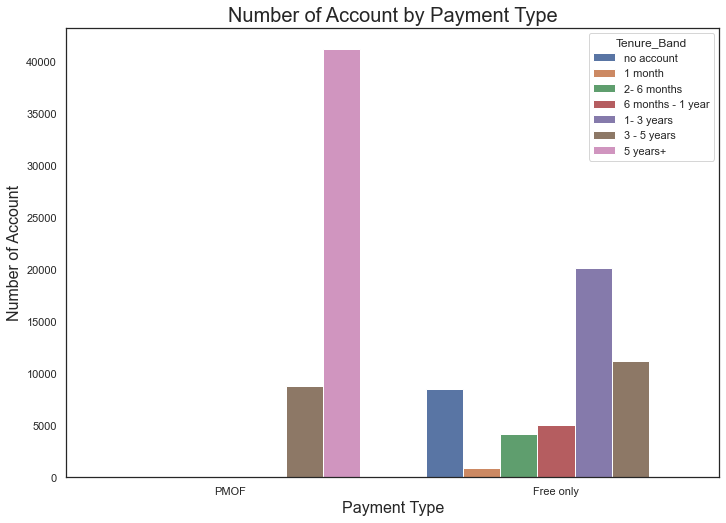

In [128]:
ax = sns.countplot(x = 'payment_type', hue = 'Tenure_Band', data = account_summary)
ax.set_title('Number of Account by Payment Type', fontsize=20)
ax.set_xlabel("Payment Type", fontsize = 16)
ax.set_ylabel("Number of Account", fontsize = 16)

### The relationship between account active status with payment type

In [129]:
account_summary.groupby(['payment_type','no_txn_flag']).size()

payment_type  no_txn_flag
Free only     Active         14993
              Dormant        35007
PMOF          Active         14982
              Dormant        35018
dtype: int64

### The corelation between account active status and payment type cannot be proved based on the data

### Analyze the two 'acct_txn_group'

In [130]:
account_summary.groupby(['Tenure_Band','acct_txn_group']).size()

Tenure_Band        acct_txn_group
no account         Dormant            6002
                   High                 11
                   Low                2474
1 month            Dormant             593
                   High                  1
                   Low                 254
2- 6 months        Dormant            2896
                   High                  6
                   Low                1291
6 months - 1 year  Dormant            3490
                   High                  4
                   Low                1508
1- 3 years         Dormant           14139
                   High                 30
                   Low                6006
3 - 5 years        Dormant           14029
                   High               2618
                   Low                3371
5 years+           Dormant           28855
                   High              12380
                   Low                   9
dtype: int64

#### Longer tenured accounts are more likely to be highly active. Shorter tenure accounts are more likely to be dormant or low active. 

Text(0, 0.5, 'Number of Account')

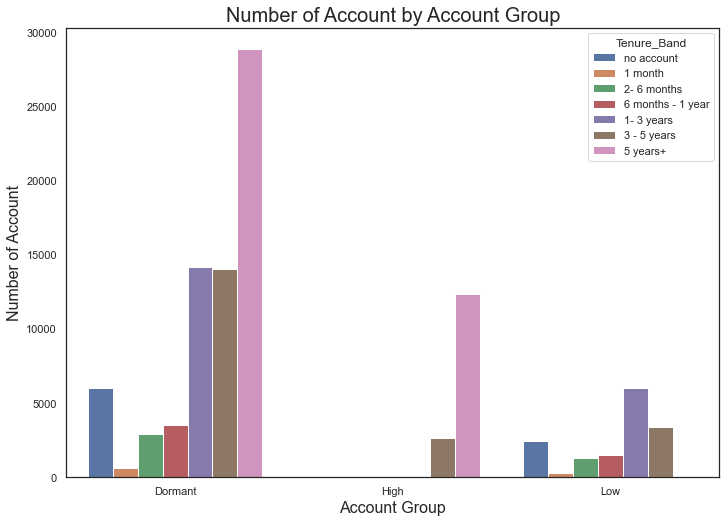

In [131]:
ax = sns.countplot(x = 'acct_txn_group', hue = 'Tenure_Band', data = account_summary)
ax.set_title('Number of Account by Account Group', fontsize=20)
ax.set_xlabel("Account Group", fontsize = 16)
ax.set_ylabel("Number of Account", fontsize = 16)

In [132]:
account_summary.groupby(['acct_txn_group'])['acct_tenure_years'].mean()

acct_txn_group
Dormant   4.13
High      6.59
Low       1.65
Name: acct_tenure_years, dtype: float64

#### Highly active accounts are more likely to have long tenure.

Text(0, 0.5, 'Number of Account')

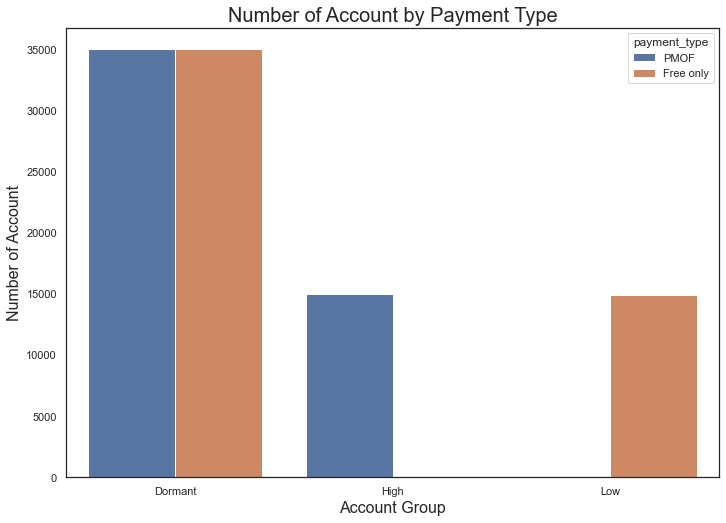

In [133]:
ax = sns.countplot(x = 'acct_txn_group', hue = 'payment_type', data = account_summary)
ax.set_title('Number of Account by Payment Type', fontsize=20)
ax.set_xlabel("Account Group", fontsize = 16)
ax.set_ylabel("Number of Account", fontsize = 16)

## 1.7 Clean data and add meaningful columns

In [134]:
transaction_df_final = transaction_df[(~transaction_df['acct_id'].isin(outliers1)) & (~transaction_df['acct_id'].isin(outliers2))]

In [135]:
transaction_df_final['transaction_year_month'] = transaction_df_final['transaction_dt'].dt.to_period('M')
transaction_df_final['transaction_year'] = transaction_df_final['transaction_dt'].dt.year
transaction_df_final['transaction_month'] = transaction_df_final['transaction_dt'].dt.month
transaction_df_final['transaction_weekday'] = transaction_df_final['transaction_dt'].dt.weekday
transaction_df_final['transaction_weekday_nm'] = transaction_df_final['transaction_dt'].dt.day_name()

C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [136]:
transaction_df_final['acct_tenure'] = transaction_df_final['transaction_dt'] - transaction_df_final['account_create_dt']
transaction_df_final['acct_tenure_days'] = transaction_df_final['acct_tenure']/np.timedelta64(1,'D')
transaction_df_final['acct_tenure_months'] = transaction_df_final['acct_tenure']/np.timedelta64(1,'M')
transaction_df_final['acct_tenure_years'] = transaction_df_final['acct_tenure']/np.timedelta64(1,'Y')

C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [137]:
transaction_df_final['transaction_without_acct'] = np.where(transaction_df_final['transaction_dt'] < transaction_df_final['account_create_dt'],1,0)

C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [138]:
tenure_cut_labels = ['no account','1 month', '2- 6 months', '6 months - 1 year', '1- 3 years','3 - 5 years', '5 years+']
tenure_cut_bins = [transaction_df_final['acct_tenure_months'].min(), 0, 1, 6, 12,36, 60, transaction_df_final['acct_tenure_months'].max()]
transaction_df_final['Tenure_Band'] = pd.cut(transaction_df_final['acct_tenure_months'], bins = tenure_cut_bins, labels = tenure_cut_labels)

C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
transaction_df_final['transaction_week'] = transaction_df_final['transaction_dt'].dt.week
transaction_df_final["First_day_of_the_week"] = transaction_df_final['transaction_dt'] - transaction_df_final['transaction_weekday'] * np.timedelta64(1, 'D')

C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.
C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [140]:
transaction_df_final['free_transaction_flag'] = np.where(transaction_df_final['price'] == 0, 1,0)

C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [141]:
price_cut_labels = ['free','below $ 5', '$ 5-10', '$ 10-20', '$20+']
price_cut_bins = [0, 0.0001, 5, 10,20, transaction_df_final['price'].max()]
transaction_df_final['Price_Band'] = pd.cut(transaction_df_final['price'], bins = price_cut_bins, labels = price_cut_labels)
transaction_df_final['Paid_acct_Flag'] = np.where(transaction_df_final.groupby(['acct_id'])['price'].transform(sum)>0 ,1 ,0)
transaction_df_final['Price_Band'] = transaction_df_final['Price_Band'].fillna('free')

C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [142]:
transaction_df_final.sort_values(by= 'acct_id').head()

,transaction_dt,transaction_content_id,acct_id,price,transaction_device_id,app_name,parent_app_content_id,category_id,category_name,app_device_id,app_device_name,content_id,inapp_content_type,transaction_device_name,account_create_dt,payment_type,acct_txn_group,transaction_year_month,transaction_year,transaction_month,transaction_weekday,transaction_weekday_nm,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years,transaction_without_acct,Tenure_Band,transaction_week,First_day_of_the_week,free_transaction_flag,Price_Band,Paid_acct_Flag
2444787,2016-08-08,9984036bef4ea626,00028709c8d435ff,0.00,1,Preparing Remotest,9984036bef4ea626,M-7,Utilities,3.00,Both,NaN,NaN,iPhone,2013-11-25,Free only,Low,2016-08,2016,8,0,Monday,987 days,987.00,32.43,2.70,0,1- 3 years,32,2016-08-08,1,free,0
1875391,2016-06-20,46037c4ef11b772a,00028709c8d435ff,0.00,1,Circulates Anno,46037c4ef11b772a,Z-1,Games,3.00,Both,NaN,NaN,iPhone,2013-11-25,Free only,Low,2016-06,2016,6,0,Monday,938 days,938.00,30.82,2.57,0,1- 3 years,25,2016-06-20,1,free,0
1928647,2016-08-03,a2f5435e63872446,00028709c8d435ff,0.00,1,Symbolize Gentleman,a2f5435e63872446,Z-1,Games,3.00,Both,NaN,NaN,iPhone,2013-11-25,Free only,Low,2016-08,2016,8,2,Wednesday,982 days,982.00,32.26,2.69,0,1- 3 years,31,2016-08-01,1,free,0
2065811,2016-06-23,ed4dd6eaa31b07ac,00028709c8d435ff,0.00,2,Curious Sleeves,ed4dd6eaa31b07ac,Y-8,Photos & Videos,2.00,iPad,NaN,NaN,iPad,2013-11-25,Free only,Low,2016-06,2016,6,3,Thursday,941 days,941.00,30.92,2.58,0,1- 3 years,25,2016-06-20,1,free,0
2315195,2016-07-07,fafb338ae6e264b0,00028709c8d435ff,0.00,2,Adjoining Alfred,fafb338ae6e264b0,Z-1,Games,3.00,Both,NaN,NaN,iPad,2013-11-25,Free only,Low,2016-07,2016,7,3,Thursday,955 days,955.00,31.38,2.61,0,1- 3 years,27,2016-07-04,1,free,0


In [143]:
transaction_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3407570 entries, 0 to 3605243
Data columns (total 33 columns):
 #   Column                    Dtype          
---  ------                    -----          
 0   transaction_dt            datetime64[ns] 
 1   transaction_content_id    object         
 2   acct_id                   object         
 3   price                     float64        
 4   transaction_device_id     object         
 5   app_name                  object         
 6   parent_app_content_id     object         
 7   category_id               object         
 8   category_name             object         
 9   app_device_id             object         
 10  app_device_name           object         
 11  content_id                object         
 12  inapp_content_type        object         
 13  transaction_device_name   object         
 14  account_create_dt         datetime64[ns] 
 15  payment_type              object         
 16  acct_txn_group            object    

In [144]:
transaction_df_final.describe()

,price,transaction_year,transaction_month,transaction_weekday,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years,transaction_without_acct,transaction_week,free_transaction_flag,Paid_acct_Flag
count,"3,407,570.00","3,407,570.00","3,407,570.00","3,407,570.00",3404829,"3,404,829.00","3,404,829.00","3,404,829.00","3,407,570.00","3,407,570.00","3,407,570.00","3,407,570.00"
mean,5.10,"2,016.00",7.39,3.07,1738 days 21:40:02.893889888,"1,738.90",57.13,4.76,0.07,29.88,0.38,0.66
std,6.91,0.00,1.08,2.00,1013 days 13:10:33.436896416,"1,013.55",33.30,2.78,0.25,4.69,0.49,0.47
min,0.00,"2,016.00",6.00,0.00,-421 days +00:00:00,-421.00,-13.83,-1.15,0.00,22.00,0.00,0.00
25%,0.00,"2,016.00",6.00,1.00,962 days 00:00:00,962.00,31.61,2.63,0.00,26.00,0.00,0.00
50%,1.99,"2,016.00",7.00,3.00,1887 days 00:00:00,"1,887.00",62.00,5.17,0.00,30.00,0.00,1.00
75%,7.99,"2,016.00",8.00,5.00,2579 days 00:00:00,"2,579.00",84.73,7.06,0.00,34.00,1.00,1.00
max,29.99,"2,016.00",9.00,6.00,3344 days 00:00:00,"3,344.00",109.87,9.16,1.00,38.00,1.00,1.00


## 1.8 Check high level transaction data distribution

In [145]:
transaction_df_final.groupby(['transaction_year_month']).size()

transaction_year_month
2016-06    892556
2016-07    951862
2016-08    888719
2016-09    674433
Freq: M, dtype: int64

Text(0, 0.5, 'Number of Transaction')

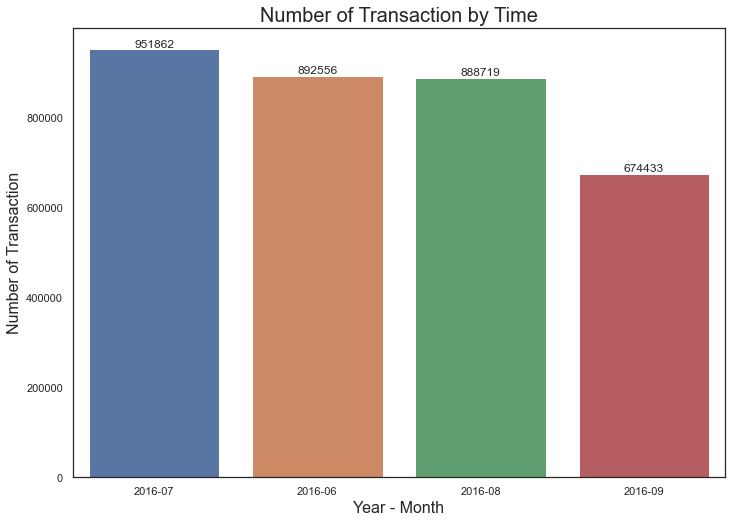

In [146]:
ax = sns.countplot(x = 'transaction_year_month', data = transaction_df_final, order = transaction_df_final['transaction_year_month'].value_counts().index)
ax.bar_label(container=ax.containers[0], labels = transaction_df_final['transaction_year_month'].value_counts().values)
ax.set_title('Number of Transaction by Time', fontsize=20)
ax.set_xlabel("Year - Month", fontsize = 16)
ax.set_ylabel("Number of Transaction", fontsize = 16)

Text(0, 0.5, 'Number of Transaction')

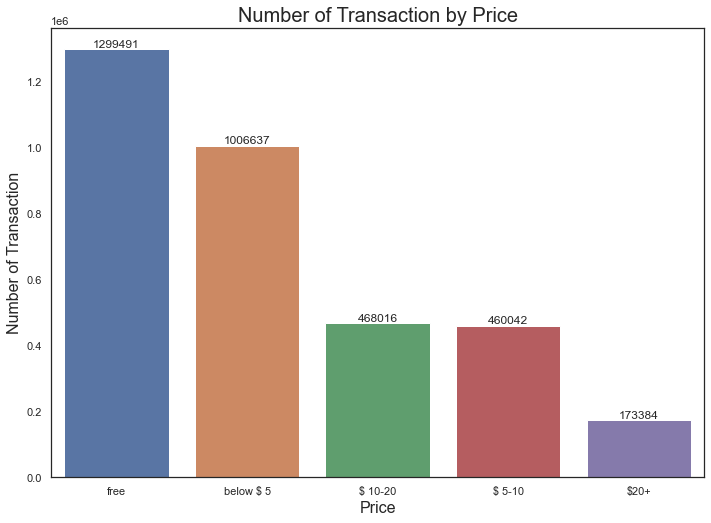

In [147]:
ax = sns.countplot(x = transaction_df_final['Price_Band'], order = transaction_df_final['Price_Band'].value_counts().index)
ax.bar_label(container=ax.containers[0], labels=transaction_df_final['Price_Band'].value_counts().values)
ax.set_title('Number of Transaction by Price', fontsize=20)
ax.set_xlabel("Price", fontsize = 16)
ax.set_ylabel("Number of Transaction", fontsize = 16)

Text(0, 0.5, 'Number of Transaction')

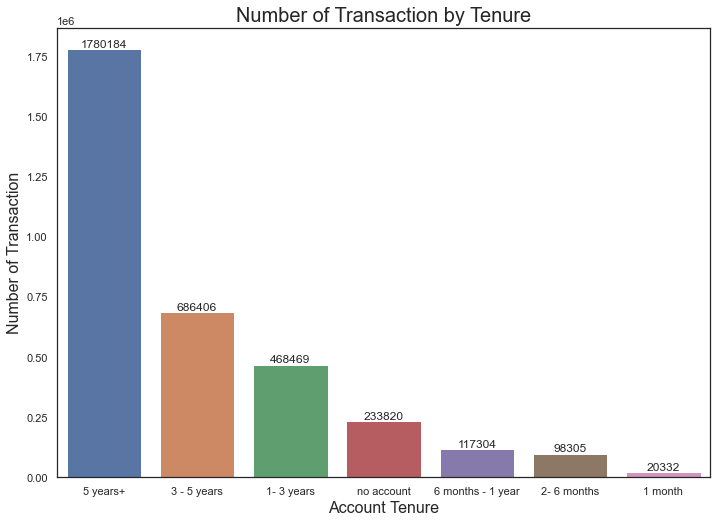

In [148]:
ax = sns.countplot(x = 'Tenure_Band', data = transaction_df_final, order = transaction_df_final['Tenure_Band'].value_counts(ascending=False).index)
ax.bar_label(container=ax.containers[0], labels=transaction_df_final['Tenure_Band'].value_counts().values)
ax.set_title('Number of Transaction by Tenure', fontsize=20)
ax.set_xlabel("Account Tenure", fontsize = 16)
ax.set_ylabel("Number of Transaction", fontsize = 16)

Text(0, 0.5, 'Number of Transaction')

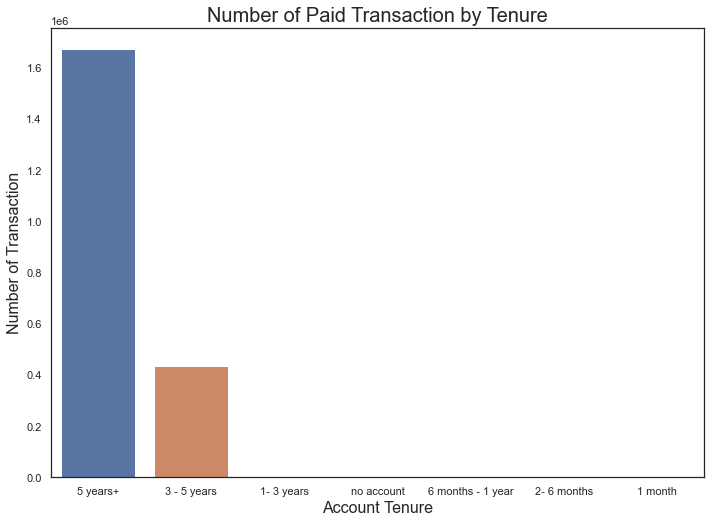

In [149]:
ax = sns.countplot(x = 'Tenure_Band', data = transaction_df_final[transaction_df_final['free_transaction_flag'] != 1], order = transaction_df_final['Tenure_Band'].value_counts(ascending=False).index)
ax.set_title('Number of Paid Transaction by Tenure', fontsize=20)
ax.set_xlabel("Account Tenure", fontsize = 16)
ax.set_ylabel("Number of Transaction", fontsize = 16)

In [150]:
transaction_df_final[transaction_df_final['free_transaction_flag'] != 1].groupby(['Tenure_Band']).size()

Tenure_Band
no account                 0
1 month                    0
2- 6 months                0
6 months - 1 year          0
1- 3 years               686
3 - 5 years           432969
5 years+             1672884
dtype: int64

In [151]:
tenure_txn = transaction_df_final.groupby(['Tenure_Band']).agg(acct_ct= ('acct_id','nunique'))
tenure_txn['txn'] = transaction_df_final.groupby(['Tenure_Band']).size()
tenure_txn['avg_txn'] = tenure_txn['txn']/tenure_txn['acct_ct']

In [152]:
tenure_txn

,acct_ct,txn,avg_txn
Tenure_Band,,,
no account,3492,233820,66.96
1 month,1214,20332,16.75
2- 6 months,2232,98305,44.04
6 months - 1 year,2459,117304,47.70
1- 3 years,6957,468469,67.34
3 - 5 years,6922,686406,99.16
5 years+,12266,1780184,145.13


<AxesSubplot:xlabel='Tenure_Band', ylabel='avg_txn'>

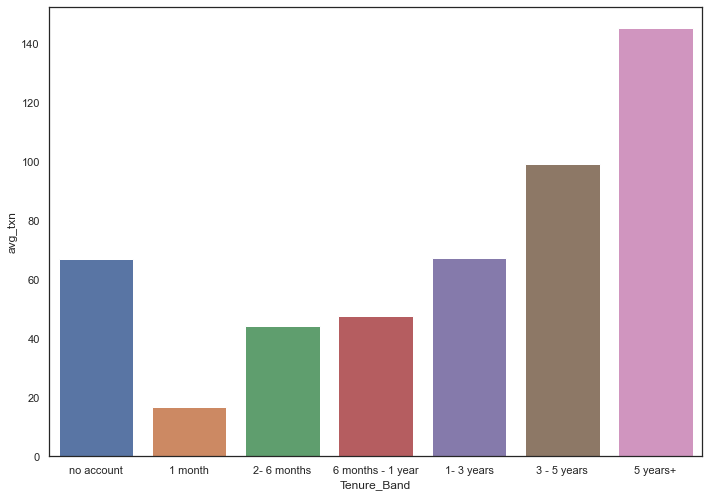

In [153]:
sns.barplot(x = tenure_txn.index, y = 'avg_txn', data = tenure_txn)

In [154]:
tenure_txn.to_csv('tenure_txn.csv')

In [155]:
acct_txn_group_summary = transaction_df_final.groupby(['acct_txn_group']).agg(acct_ct = ('acct_id','nunique'), total_revenue = ('price',sum))
acct_txn_group_summary['total_txn'] = transaction_df_final.groupby(['acct_txn_group']).size()
acct_txn_group_summary['avg_revenue'] = acct_txn_group_summary['total_revenue']/ acct_txn_group_summary['acct_ct']
acct_txn_group_summary['avg_txn'] = acct_txn_group_summary['total_txn']/ acct_txn_group_summary['acct_ct']

In [156]:
acct_txn_group_summary

,acct_ct,total_revenue,total_txn,avg_revenue,avg_txn
acct_txn_group,,,,,
High,14900,"17,375,848.61",2246066,"1,166.16",150.74
Low,14925,0.00,1158763,0.00,77.64


#### All the paid accounts are high active accounts.  Not sure if that comes from the selection bias.

# 2 Performance Dashboard

## 2.1 Daily Trends

### Daily Performance Trend

In [157]:
performance_daily = transaction_df_final.groupby(['transaction_dt']).agg(active_acct_ct = ('acct_id', 'nunique'), \
                                                                   active_unique_app = ('parent_app_content_id', 'nunique'), \
                                                                   dalily_sales = ('price', sum), \
                                                                   free_transaction_ct = ('free_transaction_flag',sum)
                                                                   )
performance_daily['transaction_ct'] = transaction_df_final.groupby(['transaction_dt']).size()

In [158]:
performance_daily['paid_transaction_ct'] = performance_daily['transaction_ct'] - performance_daily['free_transaction_ct']
performance_daily['avg_free_transaction_ct_per_acct'] = performance_daily['free_transaction_ct']/ performance_daily['active_acct_ct']
performance_daily['avg_paid_transaction_ct_per_acct'] = performance_daily['paid_transaction_ct']/ performance_daily['active_acct_ct']
performance_daily['avg_transaction_ct_per_acct'] = performance_daily['transaction_ct']/ performance_daily['active_acct_ct']
performance_daily['avg_sales_per_acct'] = performance_daily['dalily_sales']/ performance_daily['active_acct_ct']

In [159]:
performance_daily.head()

,active_acct_ct,active_unique_app,dalily_sales,free_transaction_ct,transaction_ct,paid_transaction_ct,avg_free_transaction_ct_per_acct,avg_paid_transaction_ct_per_acct,avg_transaction_ct_per_acct,avg_sales_per_acct
transaction_dt,,,,,,,,,,
2016-06-01,18273,1000,"154,827.61",10670,29509,18839,0.58,1.03,1.61,8.47
2016-06-02,18179,1000,"153,168.36",10623,29287,18664,0.58,1.03,1.61,8.43
2016-06-03,18147,1000,"153,084.21",10690,29069,18379,0.59,1.01,1.60,8.44
2016-06-04,18662,999,"164,732.75",10825,30750,19925,0.58,1.07,1.65,8.83
2016-06-05,18684,1000,"167,923.51",10598,30947,20349,0.57,1.09,1.66,8.99


In [160]:
performance_daily.to_csv('performance_daily.csv')

[(0.0, 35423.8)]

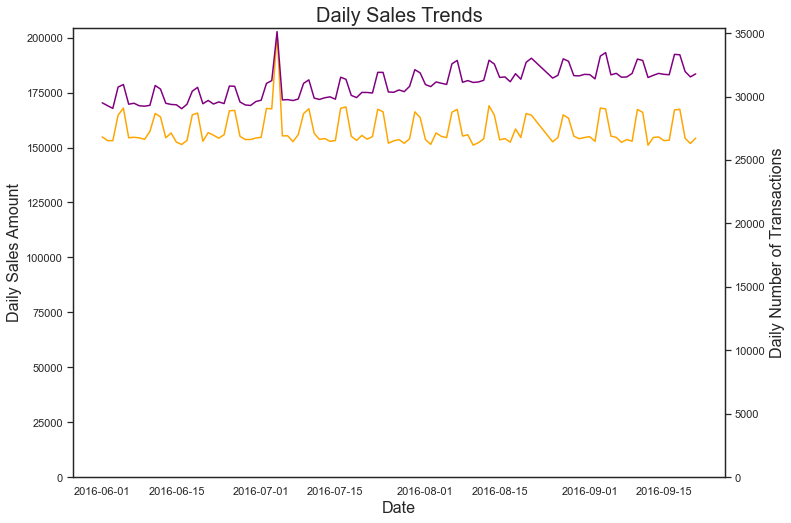

In [161]:
ax1 = sns.lineplot(x = 'transaction_dt', y = 'dalily_sales', data = performance_daily, color = 'orange')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x = 'transaction_dt', y = 'transaction_ct', data = performance_daily, color = 'purple')

ax1.set_title('Daily Sales Trends', fontsize=20)
ax1.set_xlabel("Date", fontsize = 16)
ax1.set_ylabel("Daily Sales Amount", fontsize = 16)
ax1.set(ylim=(0, None))
# ax1.yaxis.set_major_formatter(plt.FuncFormatter('$ {}'.format))

ax2.set_ylabel("Daily Number of Transactions", fontsize = 16)
ax2.set(ylim=(0, None))

[(0.0, 25000.0)]

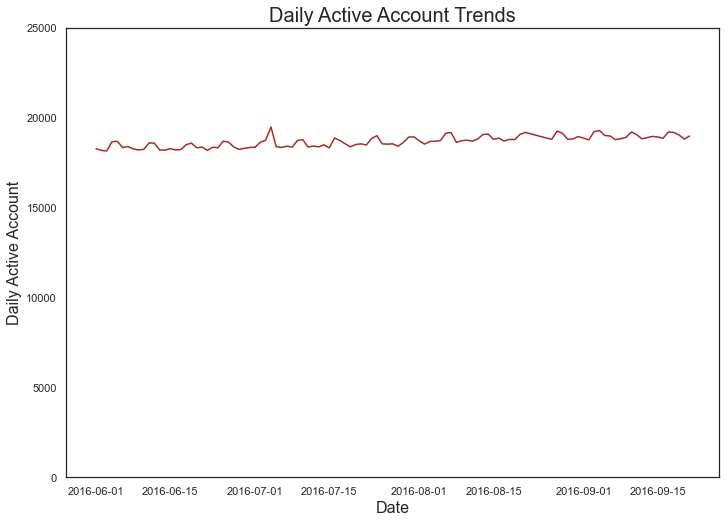

In [162]:
ax1 = sns.lineplot(x = 'transaction_dt', y = 'active_acct_ct', data = performance_daily, color = 'brown')

ax1.set_title('Daily Active Account Trends', fontsize=20)
ax1.set_xlabel("Date", fontsize = 16)
ax1.set_ylabel("Daily Active Account", fontsize = 16)
ax1.set(ylim=(0, 25000))

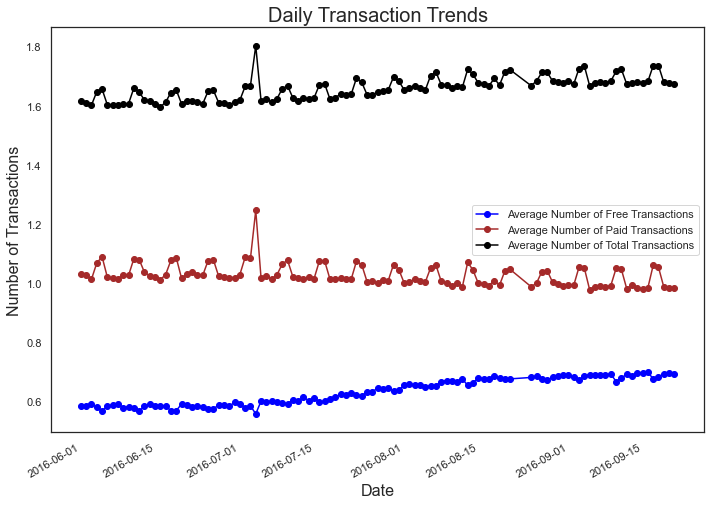

In [163]:
f, ax = plt.subplots(1, 1)
ax.plot_date(performance_daily.index, performance_daily['avg_free_transaction_ct_per_acct'], color="blue", label="Average Number of Free Transactions", linestyle="-")
ax.plot_date(performance_daily.index, performance_daily['avg_paid_transaction_ct_per_acct'], color="brown", label='Average Number of Paid Transactions', linestyle="-")
ax.plot_date(performance_daily.index, performance_daily['avg_transaction_ct_per_acct'], color="black", label='Average Number of Total Transactions', linestyle="-")

ax.legend()
ax.set_title('Daily Transaction Trends', fontsize=20)
ax.set_xlabel("Date", fontsize = 16)
ax.set_ylabel("Number of Transactions", fontsize = 16)

plt.gcf().autofmt_xdate()
plt.show()

### Increas on free content transaction

### Daily Performance Trend

In [164]:
performance_daily_category = transaction_df_final.groupby(['transaction_dt','category_name']).agg(active_acct_ct = ('acct_id', 'nunique'), \
                                                                   dalily_sales = ('price', sum), \
                                                                   free_transaction_ct = ('free_transaction_flag',sum)
                                                                   )
performance_daily_category['transaction_ct'] = transaction_df_final.groupby(['transaction_dt','category_name']).size()

In [165]:
performance_daily_category['paid_transaction_ct'] = performance_daily_category['transaction_ct'] - performance_daily_category['free_transaction_ct']
performance_daily_category['avg_free_transaction_ct_per_acct'] = performance_daily_category['free_transaction_ct']/ performance_daily_category['active_acct_ct']
performance_daily_category['avg_paid_transaction_ct_per_acct'] = performance_daily_category['paid_transaction_ct']/ performance_daily_category['active_acct_ct']
performance_daily_category['avg_transaction_ct_per_acct'] = performance_daily_category['transaction_ct']/ performance_daily_category['active_acct_ct']
performance_daily_category['avg_sales_per_acct'] = performance_daily_category['dalily_sales']/ performance_daily_category['active_acct_ct']

In [166]:
performance_daily_category.head()

active_acct_ct  dalily_sales  \
transaction_dt category_name                                     
2016-06-01     Entertainment                3466     10,572.42   
               Games                       10450    102,429.02   
               Photos & Videos              6224     26,672.48   
               Social Networking            1280      4,858.55   
               Utilities                    3745     10,295.14   

                                  free_transaction_ct  transaction_ct  \
transaction_dt category_name                                            
2016-06-01     Entertainment                     1898            3656   
               Games                             3702           13500   
               Photos & Videos                   2494            7046   
               Social Networking                  469            1314   
               Utilities                         2107            3993   

                                  paid_transaction_ct  \
transaction_dt category_name                            
2016-06-01     Entertainment                     1758   
               Games                             9798   
               Photos & Videos                   4552   
               Social Networking                  845   
               Utilities                         1886   

                                  avg_free_transaction_ct_per_acct  \
transaction_dt category_name                                         
2016-06-01     Entertainment                                  0.55   
               Games                                          0.35   
               Photos & Videos                                0.40   
               Social Networking                              0.37   
               Utilities                                      0.56   

                                  avg_paid_transaction_ct_per_acct  \
transaction_dt category_name                                         
2016-06-01     Entertainment                                  0.51   
               Games                                          0.94   
               Photos & Videos                                0.73   
               Social Networking                              0.66   
               Utilities                                      0.50   

                                  avg_transaction_ct_per_acct  \
transaction_dt category_name                                    
2016-06-01     Entertainment                             1.05   
               Games                                     1.29   
               Photos & Videos                           1.13   
               Social Networking                         1.03   
               Utilities                                 1.07   

                                  avg_sales_per_acct  
transaction_dt category_name                          
2016-06-01     Entertainment                    3.05  
               Games                            9.80  
               Photos & Videos                  4.29  
               Social Networking                3.80  
               Utilities                        2.75

In [167]:
performance_daily_category = performance_daily_category.reset_index()

In [168]:
performance_daily_category.to_csv('performance_daily_category.csv')

[(0.0, 1.4)]

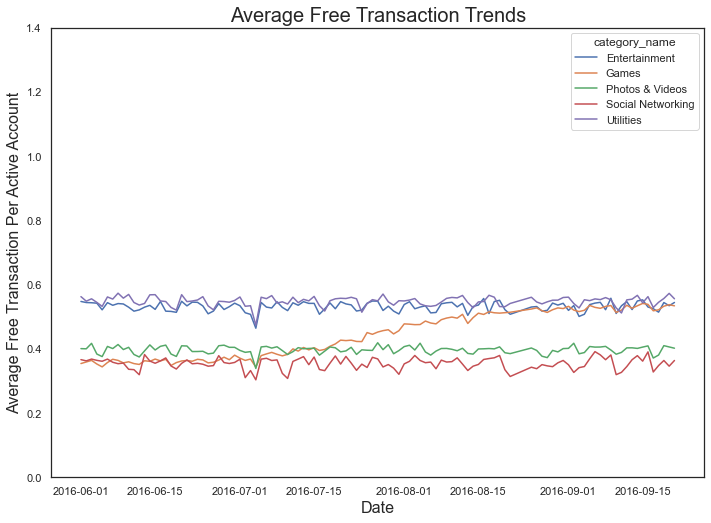

In [169]:
ax = sns.lineplot(x = 'transaction_dt', y = 'avg_free_transaction_ct_per_acct', hue = 'category_name', data = performance_daily_category, color = 'orange')

ax.set_title('Average Free Transaction Trends', fontsize=20)
ax.set_xlabel("Date", fontsize = 16)
ax.set_ylabel("Average Free Transaction Per Active Account", fontsize = 16)
ax.set(ylim=(0, 1.4))

[(0.0, 1.4)]

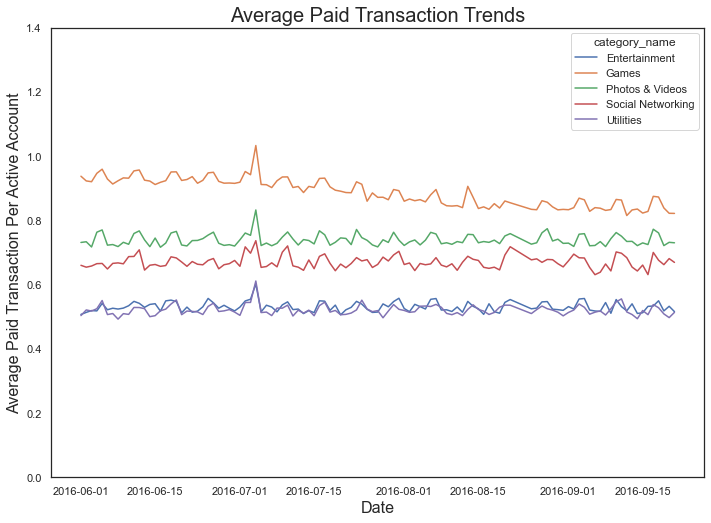

In [170]:
ax = sns.lineplot(x = 'transaction_dt', y = 'avg_paid_transaction_ct_per_acct', hue = 'category_name', data = performance_daily_category, color = 'orange')

ax.set_title('Average Paid Transaction Trends', fontsize=20)
ax.set_xlabel("Date", fontsize = 16)
ax.set_ylabel("Average Paid Transaction Per Active Account", fontsize = 16)
ax.set(ylim=(0, 1.4))

### Spike on July 4th

#### - The sales on July 4th, 2016 increased dramatically. It is posssibile there was a promotion or new product launch on that day. 
#### - There was an increasing download of free Apps in August and September.
#### - The sales and transactions have obvious weekly patterns. 

In [171]:
july04 = transaction_df_final[transaction_df_final['transaction_dt']== '2016-07-04'].groupby(['parent_app_content_id','app_name']).agg(active_acct = ('acct_id','nunique'), revenue_by_app = ('price',sum))
july04['txn_by_app'] = transaction_df_final[transaction_df_final['transaction_dt']== '2016-07-04'].groupby(['app_name']).size()

In [172]:
july04.sort_values(by=['revenue_by_app','txn_by_app'], ascending = [False, False]).head()

,,active_acct,revenue_by_app,txn_by_app
parent_app_content_id,app_name,,,
62bbc9735ee184a4,Aright Davy,377,"5,051.18",NaN
8590a25d4e5c249c,Unwritten Hungry,516,"4,780.97",NaN
74093d44c41ee885,'Vomited Men,179,"3,235.21",NaN
a97a0c4386d37a1f,Ceases Half,325,"3,155.74",NaN
c31b6ffb3bc47d7f,Him Pivothole,180,"3,085.42",NaN


### Daily App Performance

In [173]:
daily_app_performance = transaction_df_final.groupby(['parent_app_content_id','app_name','transaction_dt']).agg(active_acct = ('acct_id','nunique'), revenue_by_app = ('price',sum))
daily_app_performance['txn_by_app'] = transaction_df_final.groupby(['parent_app_content_id','app_name','transaction_dt']).size()
daily_app_performance['yesterday_txn_by_app'] = daily_app_performance.groupby(['parent_app_content_id','app_name'])['txn_by_app'].transform('shift')
daily_app_performance['app_txn_change_rate'] = daily_app_performance['txn_by_app']/ daily_app_performance['yesterday_txn_by_app'] - 1
daily_app_performance['app_txn_change'] = daily_app_performance['txn_by_app'] - daily_app_performance['yesterday_txn_by_app']

In [174]:
daily_app_performance['yesterday_revenue_by_app'] = daily_app_performance.groupby(['parent_app_content_id','app_name'])['revenue_by_app'].transform('shift')
daily_app_performance['app_revenue_change_rate'] = daily_app_performance['revenue_by_app']/ daily_app_performance['yesterday_revenue_by_app'] - 1
daily_app_performance['app_revenue_change'] = daily_app_performance['revenue_by_app'] - daily_app_performance['yesterday_revenue_by_app']

In [175]:
daily_app_performance = daily_app_performance.reset_index()

In [176]:
daily_app_performance.head()

,parent_app_content_id,app_name,transaction_dt,active_acct,revenue_by_app,txn_by_app,yesterday_txn_by_app,app_txn_change_rate,app_txn_change,yesterday_revenue_by_app,app_revenue_change_rate,app_revenue_change
0,002f3775d84a816a,Doubts Methinks,2016-06-01,9,80.91,9,NaN,NaN,NaN,NaN,NaN,NaN
1,002f3775d84a816a,Doubts Methinks,2016-06-02,12,107.88,12,9.00,0.33,3.00,80.91,0.33,26.97
2,002f3775d84a816a,Doubts Methinks,2016-06-03,4,35.96,4,12.00,-0.67,-8.00,107.88,-0.67,-71.92
3,002f3775d84a816a,Doubts Methinks,2016-06-04,7,62.93,7,4.00,0.75,3.00,35.96,0.75,26.97
4,002f3775d84a816a,Doubts Methinks,2016-06-05,6,53.94,6,7.00,-0.14,-1.00,62.93,-0.14,-8.99


In [177]:
daily_app_performance[daily_app_performance['transaction_dt'] == '2016-07-04'].sort_values(by= ['app_txn_change','app_txn_change_rate'], ascending = [False, False]).head(10)

,parent_app_content_id,app_name,transaction_dt,active_acct,revenue_by_app,txn_by_app,yesterday_txn_by_app,app_txn_change_rate,app_txn_change,yesterday_revenue_by_app,app_revenue_change_rate,app_revenue_change
14221,232fdcdc1b5f28fa,Crossed Porch,2016-07-04,290,"2,696.09",291,211.00,0.38,80.00,"1,738.89",0.55,957.20
49959,7499f25db7cfc3ea,Make Covered,2016-07-04,266,"1,738.32",268,196.00,0.37,72.00,"1,308.04",0.33,430.28
47760,7124b25cfc63b479,Clattering Larboardlarboard,2016-07-04,159,"1,008.40",160,96.00,0.67,64.00,537.04,0.88,471.36
62712,92cb2652ce9b56c8,Paid Allay,2016-07-04,136,771.62,138,81.00,0.70,57.00,532.19,0.45,239.43
30055,46c9c2462945fd84,Theirs Prison,2016-07-04,146,"1,945.54",146,92.00,0.59,54.00,"1,201.08",0.62,744.46
72611,a7790c7bf155058c,Talkest Seacommanders,2016-07-04,119,585.80,120,67.00,0.79,53.00,316.33,0.85,269.47
92403,d79a2328cd3bd23f,Mornings Belongs,2016-07-04,181,707.19,181,129.00,0.40,52.00,482.71,0.47,224.48
1793,03600ab88df39a7c,Pegging Them,2016-07-04,123,"1,011.77",123,74.00,0.66,49.00,583.26,0.73,428.51
48420,72c14a19dcc80b2d,Hen'S Halfcrazy,2016-07-04,138,703.61,139,92.00,0.51,47.00,484.08,0.45,219.53
37203,575dc0f641fe52ca,Warranty Nails,2016-07-04,168,788.32,168,122.00,0.38,46.00,551.78,0.43,236.54


In [178]:
daily_app_performance[daily_app_performance['transaction_dt'] == '2016-07-04'].sort_values(by= ['app_revenue_change','app_revenue_change_rate'], ascending = [False, False]).head(10)

,parent_app_content_id,app_name,transaction_dt,active_acct,revenue_by_app,txn_by_app,yesterday_txn_by_app,app_txn_change_rate,app_txn_change,yesterday_revenue_by_app,app_revenue_change_rate,app_revenue_change
14221,232fdcdc1b5f28fa,Crossed Porch,2016-07-04,290,"2,696.09",291,211.00,0.38,80.00,"1,738.89",0.55,957.20
30055,46c9c2462945fd84,Theirs Prison,2016-07-04,146,"1,945.54",146,92.00,0.59,54.00,"1,201.08",0.62,744.46
16641,26e319612f771cb6,October Genial,2016-07-04,131,"2,522.68",132,99.00,0.33,33.00,"1,940.01",0.30,582.67
95483,de2b624839ee027c,Constant Figured,2016-07-04,149,"1,753.49",151,123.00,0.23,28.00,"1,175.77",0.49,577.72
86904,cc1aac28059a9c73,Monster Night'S,2016-07-04,113,"1,492.87",113,79.00,0.43,34.00,949.21,0.57,543.66
72831,a79e0d352f7fa8bc,Remote Remaining,2016-07-04,303,"2,929.21",305,282.00,0.08,23.00,"2,393.40",0.22,535.81
47100,6f6aafc7cc05587e,Enshrined Shabbiest,2016-07-04,218,"2,828.80",220,193.00,0.14,27.00,"2,308.07",0.23,520.73
42261,62bbc9735ee184a4,Aright Davy,2016-07-04,377,"5,051.18",382,336.00,0.14,46.00,"4,535.64",0.11,515.54
49519,74093d44c41ee885,'Vomited Men,2016-07-04,179,"3,235.21",179,154.00,0.16,25.00,"2,755.46",0.17,479.75
47760,7124b25cfc63b479,Clattering Larboardlarboard,2016-07-04,159,"1,008.40",160,96.00,0.67,64.00,537.04,0.88,471.36


### The daily trend chart has obvious week patterns

## 2.2 Day of week effect

In [179]:
performance_weekday = transaction_df_final.groupby(['transaction_weekday', 'transaction_weekday_nm']).agg(total_sales = ('price', sum), \
                                                                    purchased_acct_ct = ('acct_id', 'nunique'), \
                                                                    purchased_unique_app = ('parent_app_content_id', 'nunique'),\
                                                                    active_days = ('transaction_dt','nunique'))
performance_weekday['total_transaction_ct'] = transaction_df_final.groupby(['transaction_weekday','transaction_weekday_nm']).size()

In [180]:
performance_weekday = performance_weekday.reset_index().sort_values(by = 'transaction_weekday')

In [181]:
performance_weekday['avg_daily_transaction_ct'] = performance_weekday['total_transaction_ct']/performance_weekday['active_days']
performance_weekday['avg_daily_sales'] = performance_weekday['total_sales']/performance_weekday['active_days']

In [182]:
performance_weekday

,transaction_weekday,transaction_weekday_nm,total_sales,purchased_acct_ct,purchased_unique_app,active_days,total_transaction_ct,avg_daily_transaction_ct,avg_daily_sales
0,0,Monday,"2,360,112.68",29850,1000,15,463759,"30,917.27","157,340.85"
1,1,Tuesday,"2,313,153.35",29850,1000,15,457934,"30,528.93","154,210.22"
2,2,Wednesday,"2,465,399.16",29849,1000,16,487694,"30,480.88","154,087.45"
3,3,Thursday,"2,457,906.99",29850,1000,16,487636,"30,477.25","153,619.19"
4,4,Friday,"2,468,493.01",29850,1000,16,487851,"30,490.69","154,280.81"
5,5,Saturday,"2,664,139.91",29850,1000,16,511092,"31,943.25","166,508.74"
6,6,Sunday,"2,658,828.11",29850,1000,16,511604,"31,975.25","166,176.76"


In [183]:
performance_weekday.to_csv('performance_weekday_overall.csv')

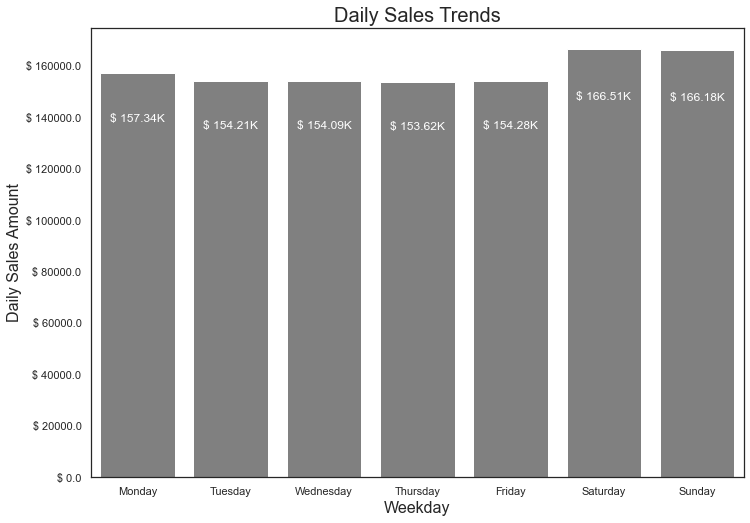

In [184]:
ax = sns.barplot(x='transaction_weekday_nm', y= 'avg_daily_sales', data=performance_weekday, color='grey')
ax.set_title('Daily Sales Trends', fontsize=20)
ax.set_xlabel("Weekday", fontsize = 16)
ax.set_ylabel("Daily Sales Amount", fontsize = 16)
ax.yaxis.set_major_formatter('$ {x}')
for p in ax.patches:
    ax.annotate("$ " + format(round(p.get_height()/1000,2), '.2f')+"K", (p.get_x()+0.4, p.get_height()*0.9), ha='center', va='top', color='white', size=12)

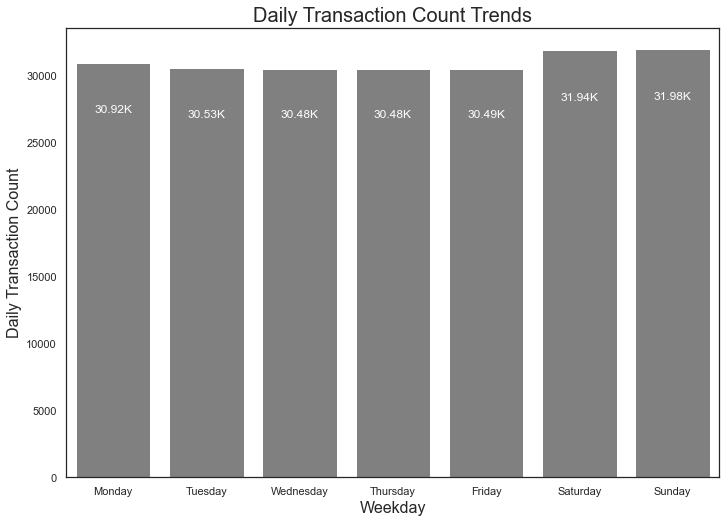

In [185]:
ax = sns.barplot(x='transaction_weekday_nm', y= 'avg_daily_transaction_ct', data=performance_weekday, color='grey')
ax.set_title('Daily Transaction Count Trends', fontsize=20)
ax.set_xlabel("Weekday", fontsize = 16)
ax.set_ylabel("Daily Transaction Count", fontsize = 16)
for p in ax.patches:
    ax.annotate(format(round(p.get_height()/1000,2), '.2f')+"K", (p.get_x()+0.4, p.get_height()*0.9), ha='center', va='top', color='white', size=12)

#### Poeple like to download and purchase App during weekend. 

## 2.3 Performance of each week

### Account Active/purchase rate of last full week

In [186]:
account_act_week = transaction_df_final[transaction_df_final['First_day_of_the_week']== '2016-09-12'].groupby(['First_day_of_the_week','acct_id']).agg(total_revenue = ('price',sum))
account_act_week['total_txn'] = transaction_df_final.groupby(['acct_id']).size()
account_act_week['paid_acct_flag'] = np.where(account_act_week['total_revenue']>0 ,'Purchased Paid App', 'Free Only')

In [187]:
account_act_week = account_act_week.reset_index()

In [188]:
account_act_week.head()

,First_day_of_the_week,acct_id,total_revenue,total_txn,paid_acct_flag
0,2016-09-12,00028709c8d435ff,0.00,NaN,Free Only
1,2016-09-12,0005a4d77127fde7,114.85,NaN,Purchased Paid App
2,2016-09-12,0005c296f2605c08,51.90,NaN,Purchased Paid App
3,2016-09-12,00082ad3dc50a70d,0.00,NaN,Free Only
4,2016-09-12,00085ff73786df4d,69.91,NaN,Purchased Paid App


In [189]:
account_act_week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29738 entries, 0 to 29737
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   First_day_of_the_week  29738 non-null  datetime64[ns]
 1   acct_id                29738 non-null  object        
 2   total_revenue          29738 non-null  float64       
 3   total_txn              0 non-null      float64       
 4   paid_acct_flag         29738 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 1.1+ MB


In [190]:
account_week_summary = account.merge(account_act_week, on ='acct_id', how = 'left')
account_week_summary = account_week_summary.fillna(0)
account_week_summary['no_txn_flag'] = np.where(account_week_summary['total_txn'] == 0, 'Dormant', 'Active')
account_week_summary['paid_acct_flag'] = account_week_summary['paid_acct_flag'].replace(0,'Dormant')

In [191]:
account_week_summary.tail()

,acct_id,account_create_dt,payment_type,First_day_of_the_week,total_revenue,total_txn,paid_acct_flag,no_txn_flag
99995,02739879f5afad8b,2014-07-08,Free only,0,0.00,0.00,Dormant,Dormant
99996,bbf8f854bd04a427,2014-12-22,Free only,0,0.00,0.00,Dormant,Dormant
99997,5f9ce37a117b26ec,2016-10-17,Free only,2016-09-12 00:00:00,0.00,0.00,Free Only,Dormant
99998,7064ed0b4c3caa12,2016-06-23,Free only,2016-09-12 00:00:00,0.00,0.00,Free Only,Dormant
99999,5bb01782906940a8,2013-12-21,Free only,0,0.00,0.00,Dormant,Dormant


In [192]:
account_week_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   acct_id                100000 non-null  object        
 1   account_create_dt      100000 non-null  datetime64[ns]
 2   payment_type           100000 non-null  object        
 3   First_day_of_the_week  100000 non-null  object        
 4   total_revenue          100000 non-null  float64       
 5   total_txn              100000 non-null  float64       
 6   paid_acct_flag         100000 non-null  object        
 7   no_txn_flag            100000 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 6.9+ MB


In [193]:
last_full_week = account_week_summary.groupby(['paid_acct_flag']).agg(paid_acct_ct = ('acct_id', 'nunique'))

In [194]:
last_full_week 

,paid_acct_ct
paid_acct_flag,
Dormant,70287
Free Only,14885
Purchased Paid App,14828


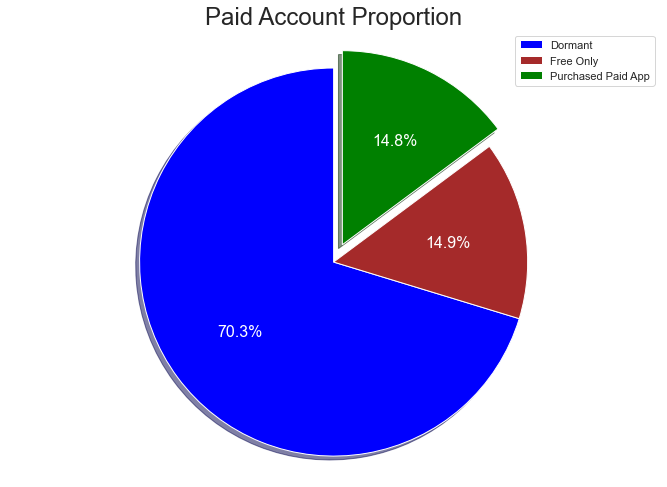

In [195]:
fig1, ax1 = plt.subplots()
ax1.pie(last_full_week.paid_acct_ct, explode= (0, 0,0.1) , labels= last_full_week.index, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['blue','brown','green'], textprops={'color':"w",'size':16})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Paid Account Proportion', fontsize=24)
plt.legend(loc="best")
plt.show()

### Sales & Transacions of each week

In [196]:
performance_week = transaction_df_final.groupby(['First_day_of_the_week']).agg(weekly_sales = ('price', sum), active_acct_ct = ('acct_id', 'nunique'), active_days = ('transaction_dt', 'nunique'))
performance_week['weekly_transaction_ct'] = transaction_df_final.groupby(['First_day_of_the_week']).size()
performance_week['avg_daily_transaction_ct'] = performance_week['weekly_transaction_ct']/performance_week['active_days']
performance_week['avg_daily_sales'] = performance_week['weekly_sales']/performance_week['active_days']

In [197]:
performance_week['previous_week_sales'] = performance_week['weekly_sales'].shift()
performance_week['previous_week_transaction_ct'] = performance_week['weekly_transaction_ct'].shift()
performance_week['weekly_sales_increase_rate'] = performance_week['weekly_sales'] /performance_week['previous_week_sales'] - 1
performance_week['weekly_transaction_ct_increase_rate'] = performance_week['weekly_transaction_ct'] /performance_week['previous_week_transaction_ct'] - 1

In [198]:
performance_week

,weekly_sales,active_acct_ct,active_days,weekly_transaction_ct,avg_daily_transaction_ct,avg_daily_sales,previous_week_sales,previous_week_transaction_ct,weekly_sales_increase_rate,weekly_transaction_ct_increase_rate
First_day_of_the_week,,,,,,,,,,
2016-05-30,"793,736.44",29377,5,149562,"29,912.40","158,747.29",NaN,NaN,NaN,NaN
2016-06-06,"1,103,834.92",29757,7,208161,"29,737.29","157,690.70","793,736.44","149,562.00",0.39,0.39
2016-06-13,"1,098,534.60",29728,7,207798,"29,685.43","156,933.51","1,103,834.92","208,161.00",-0.00,-0.00
2016-06-20,"1,108,814.44",29729,7,209211,"29,887.29","158,402.06","1,098,534.60","207,798.00",0.01,0.01
2016-06-27,"1,106,668.35",29740,7,209836,"29,976.57","158,095.48","1,108,814.44","209,211.00",-0.00,0.00
2016-07-04,"1,154,066.71",29743,7,216469,"30,924.14","164,866.67","1,106,668.35","209,836.00",0.04,0.03
2016-07-11,"1,106,492.52",29740,7,212217,"30,316.71","158,070.36","1,154,066.71","216,469.00",-0.04,-0.02
2016-07-18,"1,106,247.66",29764,7,214762,"30,680.29","158,035.38","1,106,492.52","212,217.00",-0.00,0.01
2016-07-25,"1,094,265.77",29745,7,216402,"30,914.57","156,323.68","1,106,247.66","214,762.00",-0.01,0.01


In [199]:
performance_week.to_csv('performance_week.csv')

#### Weekly sales and transactions are quite stable over the analysis period (two weeks have missing days).

[(0.0, 1188755.2164999999)]

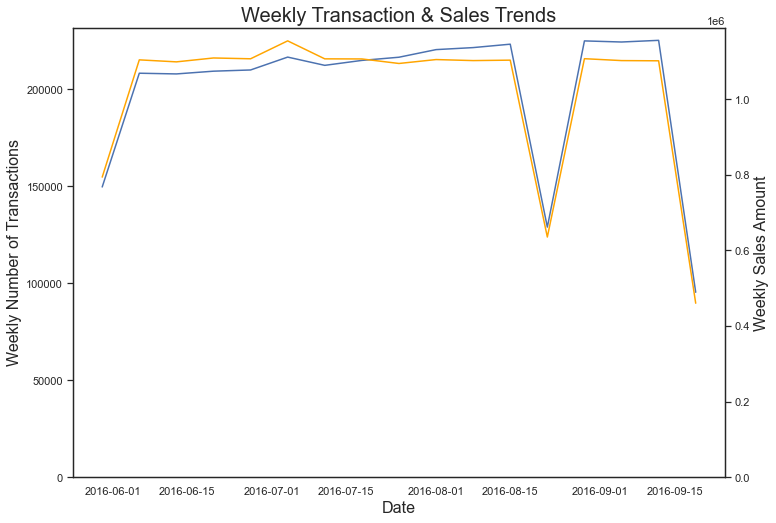

In [200]:
ax1 = sns.lineplot(x = 'First_day_of_the_week', y = 'weekly_transaction_ct', data = performance_week)
ax1.set_title('Weekly Transaction & Sales Trends', fontsize=20)
ax1.set_xlabel("Date", fontsize = 16)
# ax1.yaxis.set_major_formatter('$ {x}')
ax1.set_ylabel("Weekly Number of Transactions", fontsize = 16)
ax1.set(ylim=(0, None))

ax2 = ax1.twinx()
ax2 = sns.lineplot(x = 'First_day_of_the_week', y = 'weekly_sales', data = performance_week, color = 'orange')
ax2.set_ylabel("Weekly Sales Amount", fontsize = 16)
ax2.set(ylim=(0, None))

#### Dwonward trend on week 2016-08-22 was caused by the 3 missing days. 

[(0.0, 200000.0)]

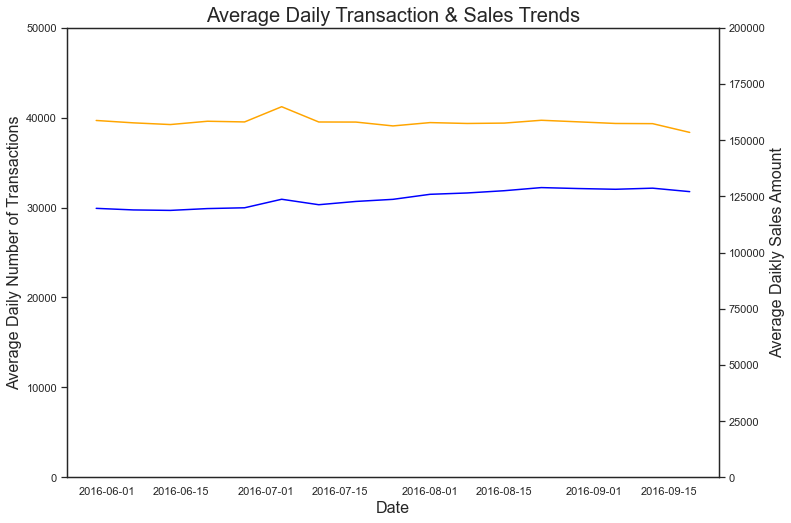

In [201]:
ax1 = sns.lineplot(x = 'First_day_of_the_week', y = 'avg_daily_transaction_ct', data = performance_week, color = 'blue')
ax1.set_title('Average Daily Transaction & Sales Trends', fontsize=20)
ax1.set_xlabel("Date", fontsize = 16)
ax1.set_ylabel("Average Daily Number of Transactions", fontsize = 16)
ax1.set(ylim=(0, 50000))

ax2 = ax1.twinx()
ax2 = sns.lineplot(x = 'First_day_of_the_week', y = 'avg_daily_sales', data = performance_week, color = 'orange')
ax2.set_ylabel("Average Daikly Sales Amount", fontsize = 16)
ax2.set(ylim=(0, 200000))

#### Dwonward trend on week 2016-08-22 was caused by the 3 missing days. 

### Performance of each week by category

In [202]:
performance_week_category = transaction_df_final.groupby(['First_day_of_the_week','category_name']).agg(weekly_sales = ('price', sum), active_acct_ct = ('acct_id', 'nunique'), active_days = ('transaction_dt', 'nunique'))
performance_week_category['weekly_transaction_ct'] = transaction_df_final.groupby(['First_day_of_the_week','category_name']).size()
performance_week_category['avg_daily_transaction_ct'] = performance_week_category['weekly_transaction_ct']/performance_week_category['active_days']
performance_week_category['avg_daily_sales'] = performance_week_category['weekly_sales']/performance_week_category['active_days']

In [203]:
performance_week_category = performance_week_category.reset_index()

In [204]:
performance_week_category['previous_week_sales'] = performance_week_category.groupby(['category_name'])['weekly_sales'].transform('shift')
performance_week_category['previous_week_transaction_ct'] = performance_week_category.groupby(['category_name'])['weekly_transaction_ct'].transform('shift')
performance_week_category['weekly_sales_increase_rate'] = performance_week_category['weekly_sales'] /performance_week_category['previous_week_sales'] - 1
performance_week_category['weekly_transaction_ct_increase_rate'] = performance_week_category['weekly_transaction_ct'] /performance_week_category['previous_week_transaction_ct'] - 1

In [205]:
performance_week_category.tail(15)

,First_day_of_the_week,category_name,weekly_sales,active_acct_ct,active_days,weekly_transaction_ct,avg_daily_transaction_ct,avg_daily_sales,previous_week_sales,previous_week_transaction_ct,weekly_sales_increase_rate,weekly_transaction_ct_increase_rate
70,2016-09-05,Entertainment,"79,197.54",17088,7,25666,"3,666.57","11,313.93","80,448.04","26,005.00",-0.02,-0.01
71,2016-09-05,Games,"718,386.90",27163,7,110884,"15,840.57","102,626.70","719,661.43","110,522.00",-0.00,0.00
72,2016-09-05,Photos & Videos,"192,758.68",23452,7,50011,"7,144.43","27,536.95","194,677.87","50,280.00",-0.01,-0.01
73,2016-09-05,Social Networking,"34,551.32",7962,7,9383,"1,340.43","4,935.90","35,584.10","9,669.00",-0.03,-0.03
74,2016-09-05,Utilities,"77,007.12",18268,7,28296,"4,042.29","11,001.02","76,550.19","28,332.00",0.01,-0.00
75,2016-09-12,Entertainment,"78,532.53",17314,7,25842,"3,691.71","11,218.93","79,197.54","25,666.00",-0.01,0.01
76,2016-09-12,Games,"720,178.15",27098,7,111083,"15,869.00","102,882.59","718,386.90","110,884.00",0.00,0.00
77,2016-09-12,Photos & Videos,"191,797.48",23462,7,49974,"7,139.14","27,399.64","192,758.68","50,011.00",-0.00,-0.00
78,2016-09-12,Social Networking,"34,613.01",7932,7,9395,"1,342.14","4,944.72","34,551.32","9,383.00",0.00,0.00
79,2016-09-12,Utilities,"76,206.64",18500,7,28806,"4,115.14","10,886.66","77,007.12","28,296.00",-0.01,0.02


In [206]:
performance_week_category.to_csv('performance_week_category.csv')

In [207]:
performance_week_category_pivot = performance_week_category[performance_week_category['First_day_of_the_week'] != '2016-08-22']\
                                    .pivot_table(index = ['First_day_of_the_week'], columns = ['category_name'], values = 'weekly_transaction_ct', aggfunc = sum)

In [208]:
performance_week_category_pivot = performance_week_category_pivot.reset_index()

In [209]:
performance_week_category_pivot.columns = ['First_day_of_the_week', 'Games', 'Photos & Videos', 'Utilities','Entertainment', 'Social Networking']

In [210]:
performance_week_category_pivot['First_day_of_the_week']

0    2016-05-30
1    2016-06-06
2    2016-06-13
3    2016-06-20
4    2016-06-27
5    2016-07-04
6    2016-07-11
7    2016-07-18
8    2016-07-25
9    2016-08-01
10   2016-08-08
11   2016-08-15
12   2016-08-29
13   2016-09-05
14   2016-09-12
15   2016-09-19
Name: First_day_of_the_week, dtype: datetime64[ns]

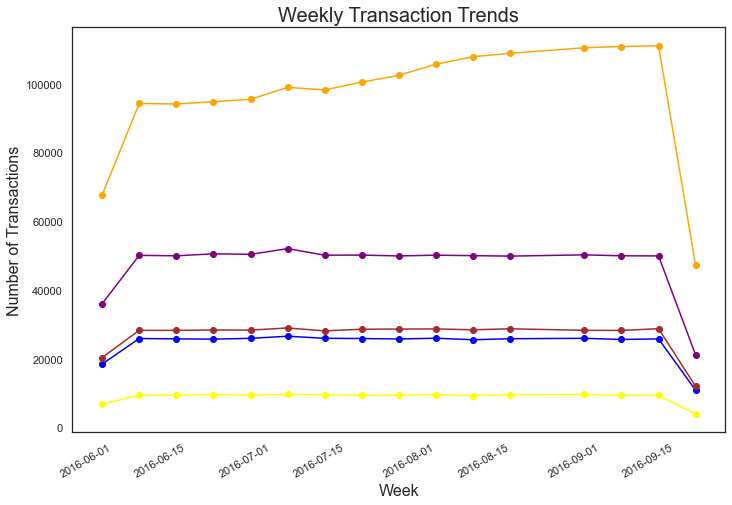

In [211]:
f, ax = plt.subplots(1, 1)
ax.plot_date(performance_week_category_pivot['First_day_of_the_week'], performance_week_category_pivot['Games'], color="blue", label="Weekly Number of Games Transactions", linestyle="-")
ax.plot_date(performance_week_category_pivot['First_day_of_the_week'], performance_week_category_pivot['Photos & Videos'], color="orange", label="Weekly Number of Photos & Videos Transactions", linestyle="-")
ax.plot_date(performance_week_category_pivot['First_day_of_the_week'], performance_week_category_pivot['Utilities'], color="purple", label="Weekly Number of Utilities Transactions", linestyle="-")
ax.plot_date(performance_week_category_pivot['First_day_of_the_week'], performance_week_category_pivot['Entertainment'], color="yellow", label="Weekly Number of Entertainment Transactions", linestyle="-")
ax.plot_date(performance_week_category_pivot['First_day_of_the_week'], performance_week_category_pivot['Social Networking'], color="brown", label="Weekly Number of Entertainment Transactions", linestyle="-")

# ax.legend()
ax.set_title('Weekly Transaction Trends', fontsize=20)
ax.set_xlabel("Week", fontsize = 16)
ax.set_ylabel("Number of Transactions", fontsize = 16)

plt.gcf().autofmt_xdate()
plt.show()

#### Weekly sales and transactions in each category are quite stable over the analysis period (two weeks have missing days).

[(-0.05, 0.05)]

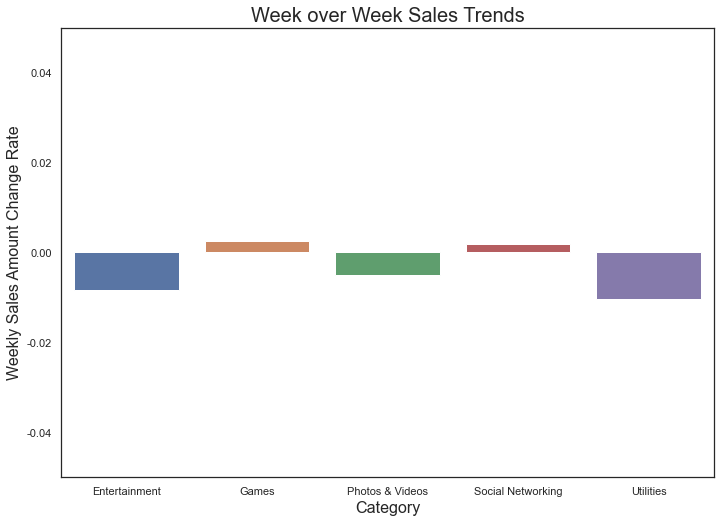

In [212]:
ax = sns.barplot(x = 'category_name', y = 'weekly_sales_increase_rate', data = performance_week_category[performance_week_category['First_day_of_the_week'] == '2016-09-12'])
ax.set_title('Week over Week Sales Trends', fontsize=20)
ax.set_xlabel("Category", fontsize = 16)
ax.set_ylabel("Weekly Sales Amount Change Rate", fontsize = 16)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.set(ylim=(-0.05, 0.05))

[(-0.05, 0.05)]

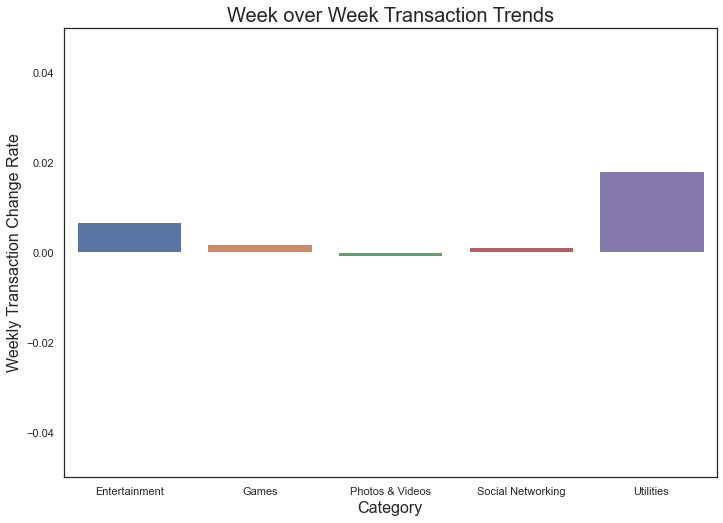

In [213]:
ax = sns.barplot(x = 'category_name', y = 'weekly_transaction_ct_increase_rate', data = performance_week_category[performance_week_category['First_day_of_the_week'] == '2016-09-12'])
ax.set_title('Week over Week Transaction Trends', fontsize=20)
ax.set_xlabel("Category", fontsize = 16)
ax.set_ylabel("Weekly Transaction Change Rate", fontsize = 16)
ax.set(ylim=(-0.05, 0.05))

## Performance of day of week by category

In [214]:
performance_weekday = transaction_df_final.groupby(['First_day_of_the_week','transaction_weekday_nm']).agg(daily_sales = ('price', sum), active_acct_ct = ('acct_id', 'nunique'))
performance_weekday['daily_transaction_ct'] = transaction_df_final.groupby(['First_day_of_the_week','transaction_weekday_nm']).size()

In [215]:
performance_weekday = performance_weekday.reset_index()

In [216]:
performance_weekday.head()

,First_day_of_the_week,transaction_weekday_nm,daily_sales,active_acct_ct,daily_transaction_ct
0,2016-05-30,Friday,"153,084.21",18147,29069
1,2016-05-30,Saturday,"164,732.75",18662,30750
2,2016-05-30,Sunday,"167,923.51",18684,30947
3,2016-05-30,Thursday,"153,168.36",18179,29287
4,2016-05-30,Wednesday,"154,827.61",18273,29509


In [217]:
performance_weekday['previous_weekday_active_acct_ct'] = performance_weekday.groupby(['transaction_weekday_nm'])['active_acct_ct'].transform('shift')
performance_weekday['previous_weekday_sales'] = performance_weekday.groupby(['transaction_weekday_nm'])['daily_sales'].transform('shift')
performance_weekday['previous_weekday_transaction_ct'] = performance_weekday.groupby(['transaction_weekday_nm'])['daily_transaction_ct'].transform('shift')
performance_weekday['wow_active_acct_ct'] = performance_weekday['active_acct_ct']/performance_weekday['previous_weekday_active_acct_ct'] - 1
performance_weekday['wow_sales_increase_rate'] = performance_weekday['daily_sales'] /performance_weekday['previous_weekday_sales'] - 1
performance_weekday['wow_transaction_ct_increase_rate'] = performance_weekday['daily_transaction_ct'] /performance_weekday['previous_weekday_transaction_ct'] - 1

In [218]:
performance_weekday.tail(20)

,First_day_of_the_week,transaction_weekday_nm,daily_sales,active_acct_ct,daily_transaction_ct,previous_weekday_active_acct_ct,previous_weekday_sales,previous_weekday_transaction_ct,wow_active_acct_ct,wow_sales_increase_rate,wow_transaction_ct_increase_rate
90,2016-08-29,Thursday,"154,916.41",18862,31731,"18,865.00","152,593.79","31,458.00",-0.00,0.02,0.01
91,2016-08-29,Tuesday,"153,987.41",18817,31629,"18,863.00","154,058.18","31,548.00",-0.00,-0.00,0.00
92,2016-08-29,Wednesday,"154,551.73",18949,31751,"18,700.00","152,423.66","31,170.00",0.01,0.01,0.02
93,2016-09-05,Friday,"152,854.62",18904,31825,"18,769.00","152,794.85","31,396.00",0.01,0.00,0.01
94,2016-09-05,Monday,"155,202.10",19009,31710,"18,794.00","155,176.48","31,650.00",0.01,0.00,0.00
95,2016-09-05,Saturday,"167,315.46",19202,32956,"19,228.00","167,940.41","33,187.00",-0.00,-0.00,-0.01
96,2016-09-05,Sunday,"165,968.60",19059,32845,"19,282.00","167,554.34","33,464.00",-0.01,-0.01,-0.02
97,2016-09-05,Thursday,"153,617.26",18829,31548,"18,862.00","154,916.41","31,731.00",-0.00,-0.01,-0.01
98,2016-09-05,Tuesday,"154,615.47",18977,31831,"18,817.00","153,987.41","31,629.00",0.01,0.00,0.01
99,2016-09-05,Wednesday,"152,328.05",18777,31525,"18,949.00","154,551.73","31,751.00",-0.01,-0.01,-0.01


In [219]:
performance_weekday.to_csv('performance_weekday.csv')

#### Weekly sales and transactions in each category are quite stable over the analysis period (two weeks have missing days).

[(-0.05, 0.05)]

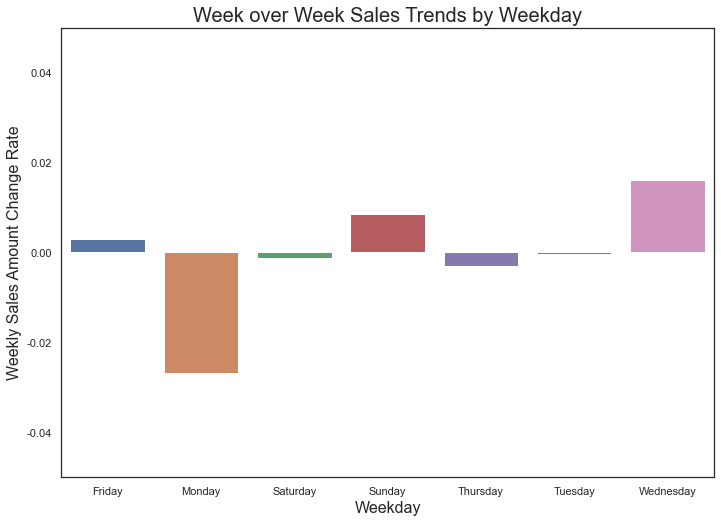

In [220]:
ax = sns.barplot(x = 'transaction_weekday_nm', y = 'wow_sales_increase_rate', data = performance_weekday[performance_weekday['First_day_of_the_week'] == '2016-09-12'])
ax.set_title('Week over Week Sales Trends by Weekday', fontsize=20)
ax.set_xlabel("Weekday", fontsize = 16)
ax.set_ylabel("Weekly Sales Amount Change Rate", fontsize = 16)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.set(ylim=(-0.05, 0.05))

[(-0.05, 0.05)]

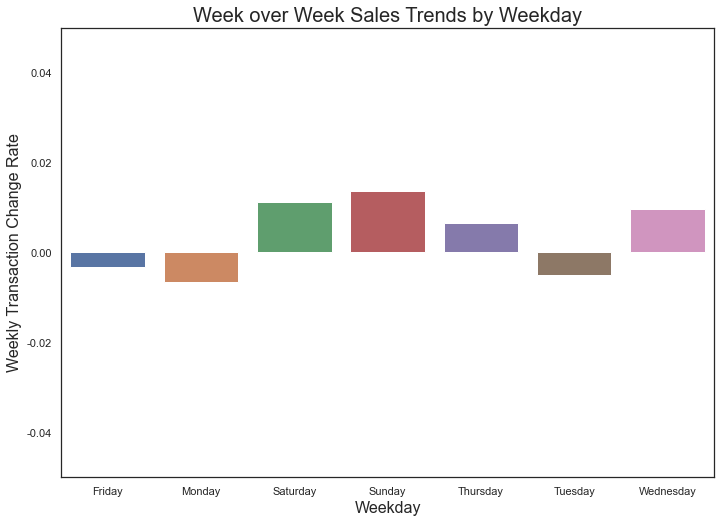

In [221]:
ax = sns.barplot(x = 'transaction_weekday_nm', y = 'wow_transaction_ct_increase_rate', data = performance_weekday[performance_weekday['First_day_of_the_week'] == '2016-09-12'])
ax.set_title('Week over Week Sales Trends by Weekday', fontsize=20)
ax.set_xlabel("Weekday", fontsize = 16)
ax.set_ylabel("Weekly Transaction Change Rate", fontsize = 16)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.set(ylim=(-0.05, 0.05))

[(-0.05, 0.05)]

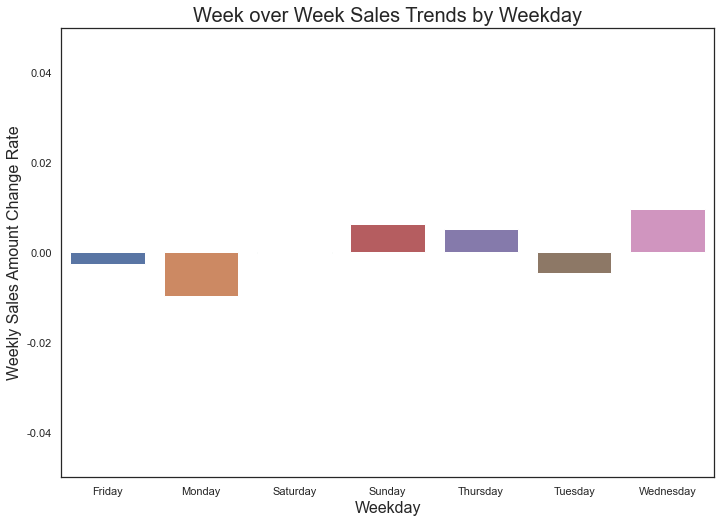

In [222]:
ax = sns.barplot(x = 'transaction_weekday_nm', y = 'wow_active_acct_ct', data = performance_weekday[performance_weekday['First_day_of_the_week'] == '2016-09-12'])
ax.set_title('Week over Week Sales Trends by Weekday', fontsize=20)
ax.set_xlabel("Weekday", fontsize = 16)
ax.set_ylabel("Weekly Sales Amount Change Rate", fontsize = 16)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.set(ylim=(-0.05, 0.05))

### Popular Apps of each week

In [223]:
app_week= transaction_df_final.groupby(['First_day_of_the_week', 'app_name','category_name']).agg(app_weekly_sales = ('price', sum), app_active_acct_ct = ('acct_id', 'nunique'))
app_week['app_weekly_transaction_ct'] = transaction_df_final.groupby(['First_day_of_the_week', 'app_name','category_name']).size()
app_week['app_weekly_sales_rank'] = app_week.groupby(['First_day_of_the_week'])['app_weekly_sales'].rank(method = 'min', ascending = False)
app_week['app_weekly_transaction_ct_rank'] = app_week.groupby(['First_day_of_the_week'])['app_weekly_transaction_ct'].rank(method = 'min', ascending = False)
app_week['app_weekly_sales_rank_category'] = app_week.groupby(['First_day_of_the_week','category_name'])['app_weekly_sales'].rank(method = 'min', ascending = False)
app_week['app_weekly_transaction_ct_rank_category'] = app_week.groupby(['First_day_of_the_week','category_name'])['app_weekly_transaction_ct'].rank(method = 'min', ascending = False)
app_week = app_week.sort_values(by = ['First_day_of_the_week','app_weekly_sales_rank','app_weekly_transaction_ct_rank']).reset_index()

In [224]:
app_week['category_weekly_sales'] = app_week.groupby(['First_day_of_the_week', 'category_name'])['app_weekly_sales'].transform(sum)
app_week['category_weekly_sales_rank'] = app_week.groupby(['First_day_of_the_week'])['category_weekly_sales'].rank(method = 'min', ascending = False)

In [225]:
app_week['app_weekly_sales_rank'] = app_week['app_weekly_sales_rank'].astype('int')
app_week['app_weekly_transaction_ct_rank'] = app_week['app_weekly_transaction_ct_rank'].astype('int')
app_week['app_weekly_sales_rank_category'] = app_week['app_weekly_sales_rank_category'].astype('int')
app_week['app_weekly_transaction_ct_rank_category'] = app_week['app_weekly_transaction_ct_rank_category'].astype('int')

In [226]:
app_week[((app_week['app_weekly_sales_rank'] <= 5) | (app_week['app_weekly_transaction_ct_rank'] <= 5)) & (app_week['First_day_of_the_week'] == app_week['First_day_of_the_week'].max())]

,First_day_of_the_week,app_name,category_name,app_weekly_sales,app_active_acct_ct,app_weekly_transaction_ct,app_weekly_sales_rank,app_weekly_transaction_ct_rank,app_weekly_sales_rank_category,app_weekly_transaction_ct_rank_category,category_weekly_sales,category_weekly_sales_rank
15968,2016-09-19,Aright Davy,Games,"13,985.61",1004,1039,1,3,1,3,"300,595.05",1.00
15969,2016-09-19,Unwritten Hungry,Games,"13,320.45",1930,2046,2,1,2,1,"300,595.05",1.00
15970,2016-09-19,Fowlsthough Grieved,Games,"8,879.42",740,758,3,9,3,9,"300,595.05",1.00
15971,2016-09-19,Ceases Half,Games,"8,840.67",908,933,4,5,4,5,"300,595.05",1.00
15972,2016-09-19,'Vomited Men,Games,"8,375.32",461,468,5,22,5,21,"300,595.05",1.00
15975,2016-09-19,Him Pivothole,Games,"7,285.25",965,995,8,4,8,4,"300,595.05",1.00
15976,2016-09-19,Remote Remaining,Games,"7,280.06",1357,1411,9,2,9,2,"300,595.05",1.00


In [227]:
app_week.head()

,First_day_of_the_week,app_name,category_name,app_weekly_sales,app_active_acct_ct,app_weekly_transaction_ct,app_weekly_sales_rank,app_weekly_transaction_ct_rank,app_weekly_sales_rank_category,app_weekly_transaction_ct_rank_category,category_weekly_sales,category_weekly_sales_rank
0,2016-05-30,Aright Davy,Games,"23,331.46",1654,1754,1,2,1,2,"518,024.03",1.00
1,2016-05-30,Unwritten Hungry,Games,"22,833.84",2236,2423,2,1,2,1,"518,024.03",1.00
2,2016-05-30,Ceases Half,Games,"15,497.17",1508,1583,3,3,3,3,"518,024.03",1.00
3,2016-05-30,'Vomited Men,Games,"14,694.75",804,825,4,10,4,9,"518,024.03",1.00
4,2016-05-30,Asis Vagueness,Games,"13,651.20",858,880,5,9,5,8,"518,024.03",1.00


In [228]:
app_week.to_csv('app_week.csv')

In [229]:
category_rank = app_week[((app_week['app_weekly_sales_rank_category'] <= 5) | (app_week['app_weekly_transaction_ct_rank_category'] <= 5)) & (app_week['First_day_of_the_week'] == app_week['First_day_of_the_week'].max())]

In [230]:
category_rank.head()

,First_day_of_the_week,app_name,category_name,app_weekly_sales,app_active_acct_ct,app_weekly_transaction_ct,app_weekly_sales_rank,app_weekly_transaction_ct_rank,app_weekly_sales_rank_category,app_weekly_transaction_ct_rank_category,category_weekly_sales,category_weekly_sales_rank
15968,2016-09-19,Aright Davy,Games,"13,985.61",1004,1039,1,3,1,3,"300,595.05",1.00
15969,2016-09-19,Unwritten Hungry,Games,"13,320.45",1930,2046,2,1,2,1,"300,595.05",1.00
15970,2016-09-19,Fowlsthough Grieved,Games,"8,879.42",740,758,3,9,3,9,"300,595.05",1.00
15971,2016-09-19,Ceases Half,Games,"8,840.67",908,933,4,5,4,5,"300,595.05",1.00
15972,2016-09-19,'Vomited Men,Games,"8,375.32",461,468,5,22,5,21,"300,595.05",1.00


In [231]:
category_rank.sort_values(by = ['category_weekly_sales_rank', 'app_weekly_sales_rank_category'])[category_rank['category_name'] == 'Games'][['category_name','app_name']]

C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,category_name,app_name
15968,Games,Aright Davy
15969,Games,Unwritten Hungry
15970,Games,Fowlsthough Grieved
15971,Games,Ceases Half
15972,Games,'Vomited Men
15975,Games,Him Pivothole
15976,Games,Remote Remaining


In [232]:
category_rank.sort_values(by = ['category_weekly_sales_rank', 'app_weekly_sales_rank_category'])[category_rank['category_name'] == 'Photos & Videos'][['category_name','app_name']]

C:\Users\xps\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,category_name,app_name
15983,Photos & Videos,Make Covered
16002,Photos & Videos,Michael Spiritual
16005,Photos & Videos,Network Panic
16008,Photos & Videos,Pirate Accompany
16015,Photos & Videos,Dim Serpentsnapping
16021,Photos & Videos,Clattering Larboardlarboard
16053,Photos & Videos,Warranty Nails


In [233]:
category_rank.sort_values(by = ['category_weekly_sales_rank', 'app_weekly_sales_rank_category'])[['category_name','app_name']]

,category_name,app_name
15968,Games,Aright Davy
15969,Games,Unwritten Hungry
15970,Games,Fowlsthough Grieved
15971,Games,Ceases Half
15972,Games,'Vomited Men
15975,Games,Him Pivothole
15976,Games,Remote Remaining
15983,Photos & Videos,Make Covered
16002,Photos & Videos,Michael Spiritual
16005,Photos & Videos,Network Panic


## 2.4 Monthly Trends

In [234]:
performance= transaction_df_final.groupby(['transaction_year_month']).agg(monthly_sales = ('price', sum), \
                                                                    active_acct_ct = ('acct_id', 'nunique'), \
                                                                    purchased_unique_app = ('parent_app_content_id', 'nunique'),\
                                                                   active_days = ('transaction_dt','nunique'))

In [235]:
performance['number of transaction'] = transaction_df_final.groupby(['transaction_year_month']).size()
performance['avg daily number of transaction'] = performance['number of transaction']/ performance['active_days']
performance['avg daily sales amount'] = performance['monthly_sales']/ performance['active_days']

In [236]:
transaction_df_final.groupby(['transaction_year_month']).agg('size')

transaction_year_month
2016-06    892556
2016-07    951862
2016-08    888719
2016-09    674433
Freq: M, dtype: int64

In [237]:
performance = performance.reset_index()

In [238]:
performance

,transaction_year_month,monthly_sales,active_acct_ct,purchased_unique_app,active_days,number of transaction,avg daily number of transaction,avg daily sales amount
0,2016-06,"4,721,571.17",29850,1000,30,892556,"29,751.87","157,385.71"
1,2016-07,"4,951,090.24",29850,1000,31,951862,"30,705.23","159,712.59"
2,2016-08,"4,408,639.84",29850,1000,28,888719,"31,739.96","157,451.42"
3,2016-09,"3,306,731.96",29850,1000,21,674433,"32,115.86","157,463.43"


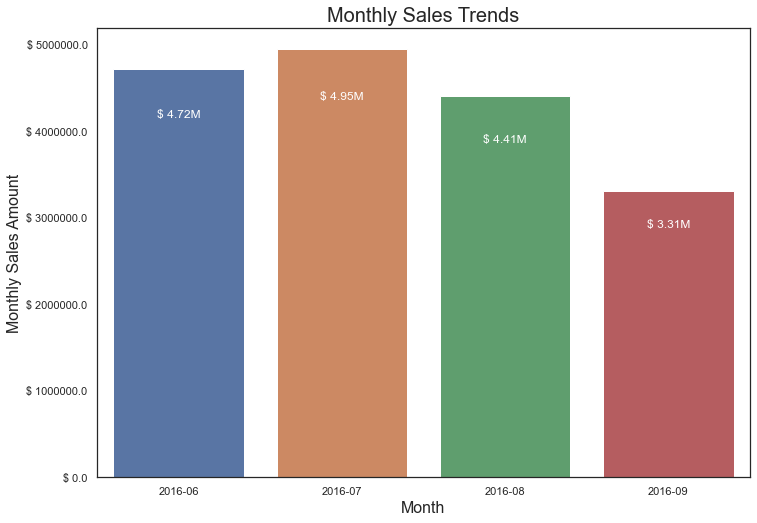

In [239]:
ax = sns.barplot(x=performance['transaction_year_month'], y= 'monthly_sales', data=performance.sort_values(by=['transaction_year_month']))
ax.set_title('Monthly Sales Trends', fontsize=20)
ax.set_xlabel("Month", fontsize = 16)
ax.set_ylabel("Monthly Sales Amount", fontsize = 16)
ax.yaxis.set_major_formatter('$ {x}')
for p in ax.patches:
    ax.annotate("$ " + format(round(p.get_height()/1000000,2), '.2f')+"M", (p.get_x()+0.4, p.get_height()*0.9), ha='center', va='top', color='white', size=12)

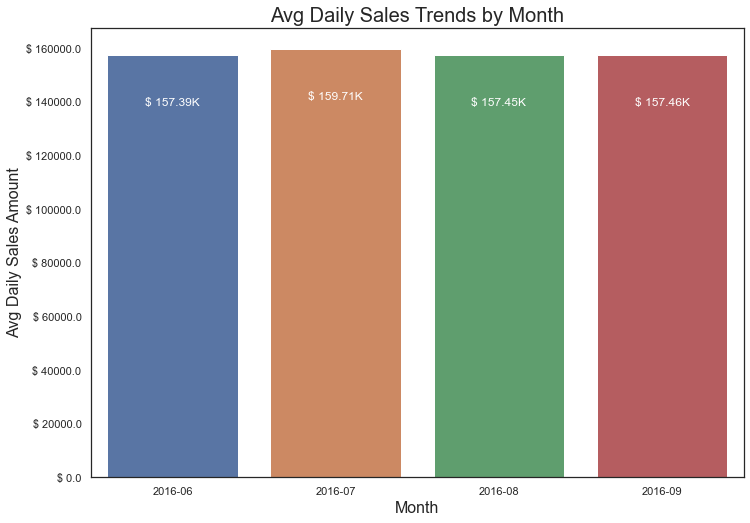

In [240]:
ax = sns.barplot(x=performance['transaction_year_month'], y= 'avg daily sales amount', data=performance.sort_values(by=['transaction_year_month']))
ax.set_title('Avg Daily Sales Trends by Month', fontsize=20)
ax.set_xlabel("Month", fontsize = 16)
ax.set_ylabel("Avg Daily Sales Amount", fontsize = 16)
ax.yaxis.set_major_formatter('$ {x}')
for p in ax.patches:
    ax.annotate("$ "+ format(round(p.get_height()/1000,2), '.2f')+"K", (p.get_x()+0.4, p.get_height()*0.9), ha='center', va='top', color='white', size=12)

### Hypothesis: The daily sales of July 2016 is higher than other months, which was driven by the great sales performance on July 4th. Is that true? 

In [241]:
performance2= transaction_df_final[transaction_df_final['transaction_dt'] !='2016-07-04'].groupby(['transaction_year_month']).agg(monthly_sales = ('price', sum), \
                                                                    active_acct_ct = ('acct_id', 'nunique'), \
                                                                    purchased_unique_app = ('parent_app_content_id', 'nunique'),\
                                                                   active_days = ('transaction_dt','nunique'))

In [242]:
performance2['number of transaction'] = transaction_df_final[transaction_df_final['transaction_dt'] !='2016-07-04'].groupby(['transaction_year_month']).size()
performance2['avg daily number of transaction'] = performance2['number of transaction']/ performance2['active_days']
performance2['avg daily sales amount'] = performance2['monthly_sales']/ performance2['active_days']

In [243]:
performance2 = performance2.reset_index()

In [244]:
performance2

,transaction_year_month,monthly_sales,active_acct_ct,purchased_unique_app,active_days,number of transaction,avg daily number of transaction,avg daily sales amount
0,2016-06,"4,721,571.17",29850,1000,30,892556,"29,751.87","157,385.71"
1,2016-07,"4,749,164.94",29850,1000,30,916742,"30,558.07","158,305.50"
2,2016-08,"4,408,639.84",29850,1000,28,888719,"31,739.96","157,451.42"
3,2016-09,"3,306,731.96",29850,1000,21,674433,"32,115.86","157,463.43"


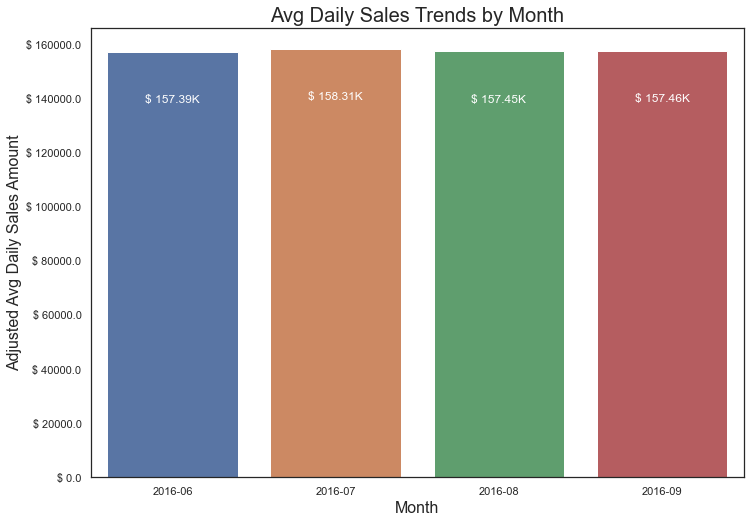

In [245]:
ax = sns.barplot(x=performance2['transaction_year_month'], y= 'avg daily sales amount', data=performance2)
ax.set_title('Avg Daily Sales Trends by Month', fontsize=20)
ax.set_xlabel("Month", fontsize = 16)
ax.set_ylabel("Adjusted Avg Daily Sales Amount", fontsize = 16)
ax.yaxis.set_major_formatter('$ {x}')
for p in ax.patches:
    ax.annotate("$ "+ format(round(p.get_height()/1000,2), '.2f')+"K", (p.get_x()+0.4, p.get_height()*0.9), ha='center', va='top', color='white', size=12)

#### The daily sales of July 2016 is higher than other months, even removing the impact from the great sales performance on July 4th. 

# 3 Insights

## 3.1 Analyze App category

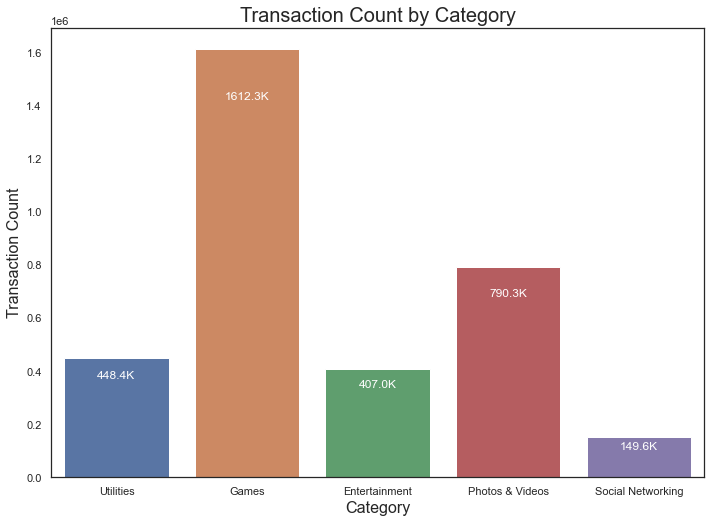

In [246]:
ax = sns.countplot(x='category_name', data=transaction_df_final)
ax.set_title('Transaction Count by Category', fontsize=20)
ax.set_xlabel("Category", fontsize = 16)
ax.set_ylabel("Transaction Count", fontsize = 16)
for p in ax.patches:
    ax.annotate(format(round(p.get_height()/1000,2), '.1f')+"K", (p.get_x()+0.4, p.get_height()*0.9), ha='center', va='top', color='white', size=12)

In [247]:
category_summary = transaction_df_final.groupby(['category_name']).agg(total_revenue= ('price',sum))
category_summary['total_transaction_ct'] = transaction_df_final.groupby(['category_name']).size()
category_summary['avg_transaction_amt'] = category_summary['total_revenue'] / category_summary['total_transaction_ct']
category_summary['avg_transaction_amt_index'] = category_summary['avg_transaction_amt']/category_summary['avg_transaction_amt'].min()
category_summary['total_transaction_ct'] = category_summary['total_transaction_ct'].astype('float')

In [248]:
category_summary

,total_revenue,total_transaction_ct,avg_transaction_amt,avg_transaction_amt_index
category_name,,,,
Entertainment,"1,254,893.80","406,984.00",3.08,1.14
Games,"11,311,577.21","1,612,348.00",7.02,2.60
Photos & Videos,"3,055,213.19","790,277.00",3.87,1.44
Social Networking,"558,548.94","149,589.00",3.73,1.39
Utilities,"1,207,800.07","448,372.00",2.69,1.00


In [249]:
category_summary.to_csv('category_summary.csv')

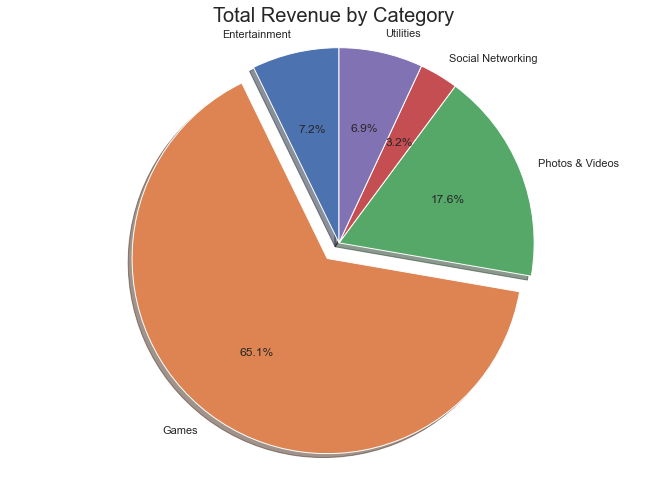

In [250]:
fig1, ax1 = plt.subplots()
ax1.pie(category_summary.total_revenue, explode= (0, 0.1, 0, 0, 0) , labels=category_summary.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Total Revenue by Category', fontsize=20)

plt.show()

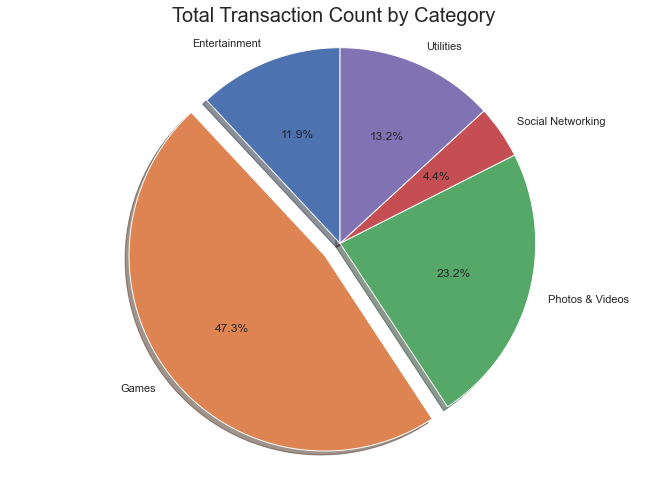

In [251]:
fig1, ax1 = plt.subplots()
ax1.pie(category_summary.total_transaction_ct, explode= (0, 0.1, 0, 0, 0) , labels=category_summary.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Total Transaction Count by Category', fontsize=20)

plt.show()

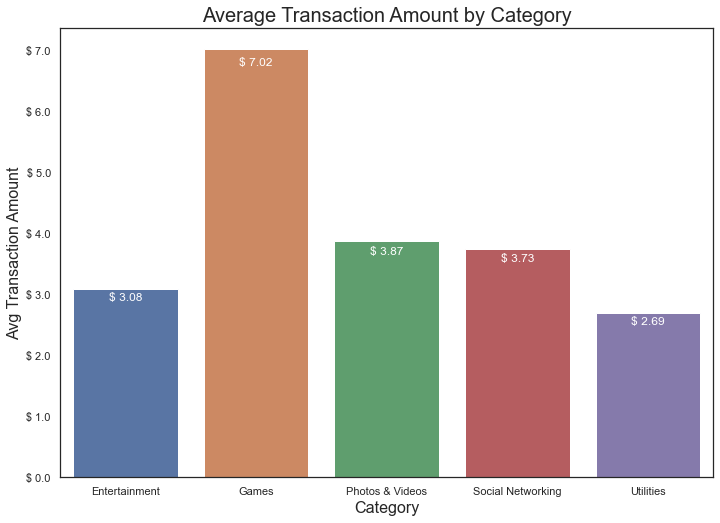

In [252]:
ax = sns.barplot(x= category_summary.index, y = 'avg_transaction_amt', data = category_summary)
ax.set_title('Average Transaction Amount by Category', fontsize=20)
ax.yaxis.set_major_formatter('$ {x}')
ax.set_xlabel("Category", fontsize = 16)
ax.set_ylabel("Avg Transaction Amount", fontsize = 16)
for p in ax.patches:
    ax.annotate("$ " + format(round(p.get_height(),2), '.2f'), (p.get_x()+0.4, p.get_height()*0.98), ha='center', va='top', color='white', size=12)

#### - Games category is the most important App category with more than half of the share in transaction count and revenue. 
#### - The most important is that games category has the highest average transaction amount (\\$ 11.40). It almost doubled the average transaction amount in utilities category (\\$ 5.81).

## 3.2 Analyze transaction device

In [253]:
transaction_df_final.head()

,transaction_dt,transaction_content_id,acct_id,price,transaction_device_id,app_name,parent_app_content_id,category_id,category_name,app_device_id,app_device_name,content_id,inapp_content_type,transaction_device_name,account_create_dt,payment_type,acct_txn_group,transaction_year_month,transaction_year,transaction_month,transaction_weekday,transaction_weekday_nm,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years,transaction_without_acct,Tenure_Band,transaction_week,First_day_of_the_week,free_transaction_flag,Price_Band,Paid_acct_Flag
0,2016-08-28,b6cf4f33e7455df4,220574a7a6a71afa,11.99,1,Events Bildad'S,61cea77b9bc843d1,M-7,Utilities,3.00,Both,b6cf4f33e7455df4,subscription,iPhone,2009-08-29,PMOF,High,2016-08,2016,8,6,Sunday,2556 days,"2,556.00",83.98,7.00,0,5 years+,34,2016-08-22,0,$ 10-20,1
1,2016-09-16,71ac3e9c38ddbbba,8551f69a5015ea6a,1.99,2,Swell Questionably,1f0ebd67df5846cd,M-7,Utilities,3.00,Both,71ac3e9c38ddbbba,consumable,iPad,2011-05-28,PMOF,High,2016-09,2016,9,4,Friday,1938 days,"1,938.00",63.67,5.31,0,5 years+,37,2016-09-12,0,below $ 5,1
2,2016-08-15,776b851b916c33d1,7dedf309494a1966,0.99,2,Supperlessmy Shipmates,1383e4f2f49f0f44,Z-1,Games,2.00,iPad,776b851b916c33d1,consumable,iPad,2009-11-15,PMOF,High,2016-08,2016,8,0,Monday,2465 days,"2,465.00",80.99,6.75,0,5 years+,33,2016-08-15,0,below $ 5,1
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,Unwritten Hungry,8590a25d4e5c249c,Z-1,Games,2.00,iPad,7a47ca132a8dc695,consumable,iPad,2009-03-01,PMOF,High,2016-06,2016,6,4,Friday,2665 days,"2,665.00",87.56,7.30,0,5 years+,24,2016-06-13,0,below $ 5,1
4,2016-06-13,30581219bc952dbb,35aaf59d64a677e7,11.99,2,Turning Thanked,478e10f9248b7842,Q-1,Entertainment,3.00,Both,30581219bc952dbb,consumable,iPad,2010-10-01,PMOF,High,2016-06,2016,6,0,Monday,2082 days,"2,082.00",68.40,5.70,0,5 years+,24,2016-06-13,0,$ 10-20,1


Text(0, 0.5, 'Transaction Count')

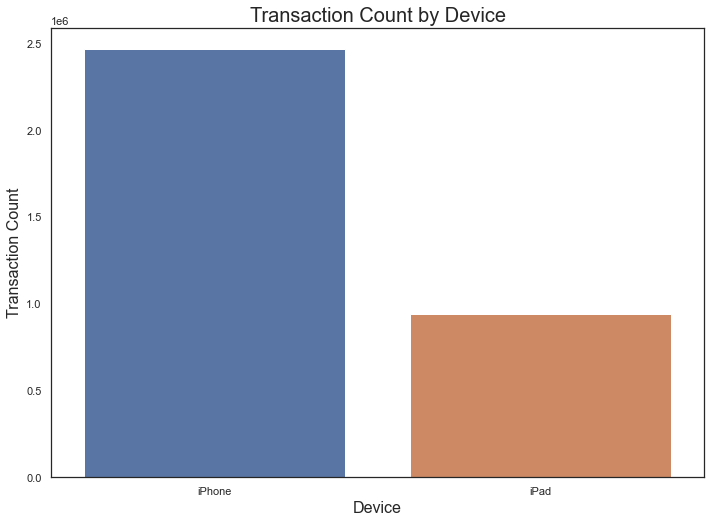

In [254]:
ax = sns.countplot(x='transaction_device_name', data=transaction_df_final)
ax.set_title('Transaction Count by Device', fontsize=20)
ax.set_xlabel("Device", fontsize = 16)
ax.set_ylabel("Transaction Count", fontsize = 16)
# for p in ax.patches:
#     ax.annotate(format(round(p.get_height()/1000), '.0f')+"K", (p.get_x()+0.4, p.get_height()*0.9), ha='center', va='top', color='white', size=12)

In [255]:
device_summary = transaction_df_final.groupby(['transaction_device_name']).agg(total_revenue= ('price',sum))
device_summary['total_transaction_ct'] = transaction_df_final.groupby(['transaction_device_name']).size()
device_summary['avg_transaction_amt'] = device_summary['total_revenue'] / device_summary['total_transaction_ct']
device_summary['transaction_share'] = device_summary['total_transaction_ct'] / device_summary['total_transaction_ct'].sum()
device_summary['revenue_share'] = device_summary['total_revenue'] / device_summary['total_revenue'].sum()
device_summary['avg_transaction_amt_index'] = device_summary['avg_transaction_amt']/device_summary['avg_transaction_amt'].min()
device_summary['total_transaction_ct'] = device_summary['total_transaction_ct'].astype('float')

In [256]:
device_summary

,total_revenue,total_transaction_ct,avg_transaction_amt,transaction_share,revenue_share,avg_transaction_amt_index
transaction_device_name,,,,,,
iPad,"4,733,593.89","940,529.00",5.03,0.28,0.27,1.00
iPhone,"12,654,439.32","2,467,041.00",5.13,0.72,0.73,1.02


In [257]:
device_summary.to_csv('device_summary.csv')

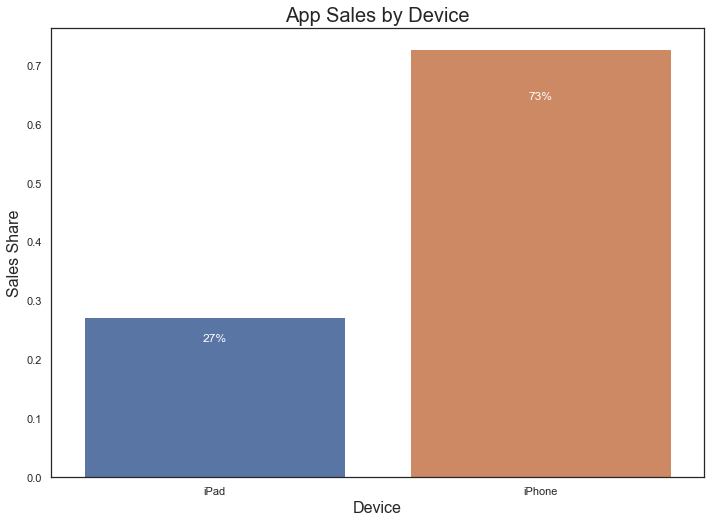

In [258]:
ax = sns.barplot(x = device_summary.index, y = 'revenue_share', data = device_summary)
ax.set_title('App Sales by Device', fontsize=20)
ax.set_xlabel("Device", fontsize = 16)
ax.set_ylabel("Sales Share", fontsize = 16)
for p in ax.patches:
    ax.annotate(format(round(p.get_height(),2)*100, '.0f')+"%", (p.get_x()+0.4, p.get_height()*0.9), ha='center', va='top', color='white', size=12)

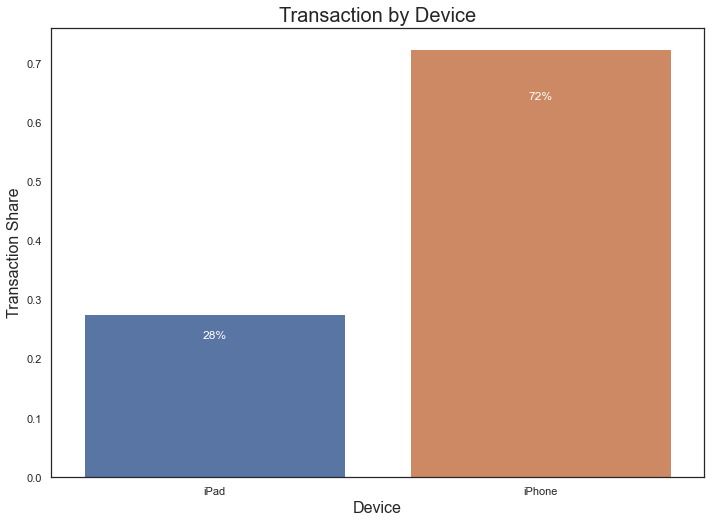

In [259]:
ax = sns.barplot(x = device_summary.index, y = 'transaction_share', data = device_summary)
ax.set_title('Transaction by Device', fontsize=20)
ax.set_xlabel("Device", fontsize = 16)
ax.set_ylabel("Transaction Share", fontsize = 16)
for p in ax.patches:
    ax.annotate(format(round(p.get_height(),2)*100, '.0f')+"%", (p.get_x()+0.4, p.get_height()*0.9), ha='center', va='top', color='white', size=12)

#### 72% of Apps are purchased with iphone, which generated 73% of the revenue.

### Check number of Apps by device

In [260]:
app_df.head()

,app_name,parent_app_content_id,category_id,app_device_id,content_id,inapp_content_type,category_name,app_device_name,content_id_modified
0,Halfslouched Having,22dfac9721b899cb,Y-8,3,f049e141e84edd84,consumable,Photos & Videos,Both,f049e141e84edd84
1,Lift Whaleships,7c645810cd7f166e,M-7,3,ef891bdc2d651c70,consumable,Utilities,Both,ef891bdc2d651c70
2,Mightily Community,c495bcb878faffaa,Y-8,2,107aece323e389df,consumable,Photos & Videos,iPad,107aece323e389df
3,Mightily Community,c495bcb878faffaa,Y-8,2,77389dc3f8108c77,consumable,Photos & Videos,iPad,77389dc3f8108c77
4,Session Tooshall,4e683dcd461cdd22,Y-8,1,abfa638eb85a98f3,consumable,Photos & Videos,iPhone,abfa638eb85a98f3


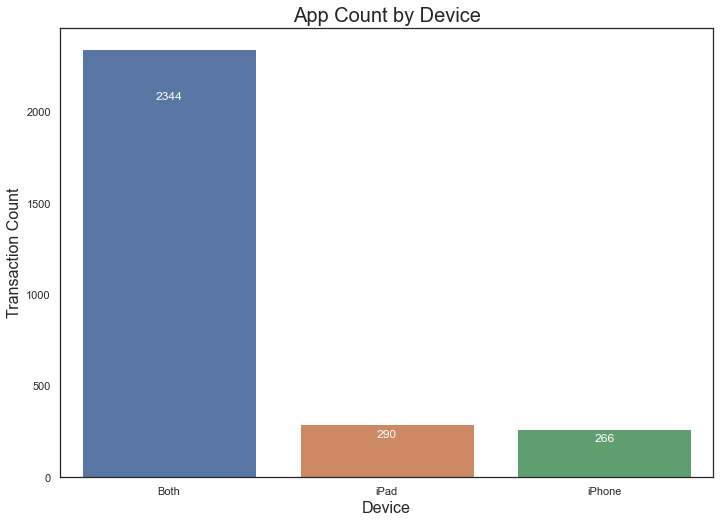

In [261]:
ax = sns.countplot(x = 'app_device_name', data = app_df)
ax.set_title('App Count by Device', fontsize=20)
ax.set_xlabel("Device", fontsize = 16)
ax.set_ylabel("Transaction Count", fontsize = 16)
for p in ax.patches:
    ax.annotate(format(round(p.get_height(),2), '.0f'), (p.get_x()+0.4, p.get_height()*0.9), ha='center', va='top', color='white', size=12)

In [262]:
app_device = app_df.groupby(['app_device_name']).agg(app_ct = ('parent_app_content_id', 'nunique'))

In [263]:
app_device

,app_ct
app_device_name,
Both,815
iPad,97
iPhone,88


In [264]:
app_device.to_csv('app_device.csv')

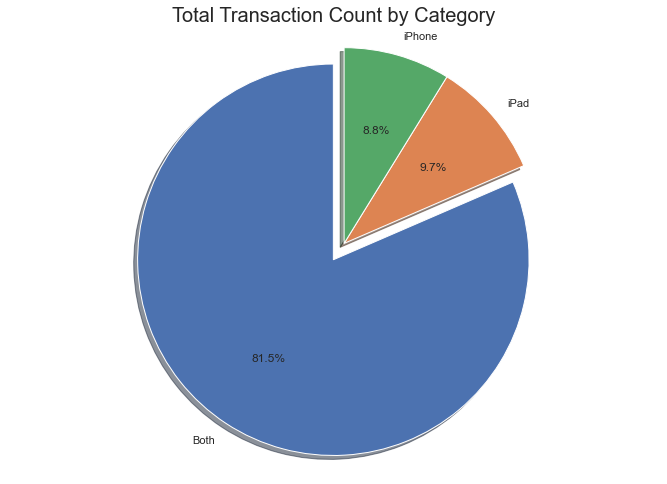

In [265]:
fig1, ax1 = plt.subplots()
ax1.pie(app_device.app_ct, explode= (0.1, 0, 0) , labels=app_device.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Total Transaction Count by Category', fontsize=20)

plt.show()

#### 82% of Apps are avalible on both devices

### Check the device preference for apps can be used on both iphone and ipad

In [266]:
device_summary2 = transaction_df_final[transaction_df_final['app_device_name'] == 'Both'].groupby(['transaction_device_name']).agg(total_revenue= ('price',sum))
device_summary2['total_transaction_ct'] = transaction_df_final.groupby(['transaction_device_name']).size()
device_summary2['avg_transaction_amt'] = device_summary2['total_revenue'] / device_summary2['total_transaction_ct']
device_summary2['transaction_share'] = device_summary2['total_transaction_ct'] / device_summary2['total_transaction_ct'].sum()
device_summary2['revenue_share'] = device_summary2['total_revenue'] / device_summary2['total_revenue'].sum()
device_summary2['avg_transaction_amt_index'] = device_summary2['avg_transaction_amt']/device_summary2['avg_transaction_amt'].min()
device_summary2['total_transaction_ct'] = device_summary2['total_transaction_ct'].astype('float')

In [267]:
device_summary2

,total_revenue,total_transaction_ct,avg_transaction_amt,transaction_share,revenue_share,avg_transaction_amt_index
transaction_device_name,,,,,,
iPad,"2,738,586.66","940,529.00",2.91,0.28,0.20,1.00
iPhone,"10,971,712.30","2,467,041.00",4.45,0.72,0.80,1.53


In [268]:
device_summary2.to_csv('device_summary2.csv')

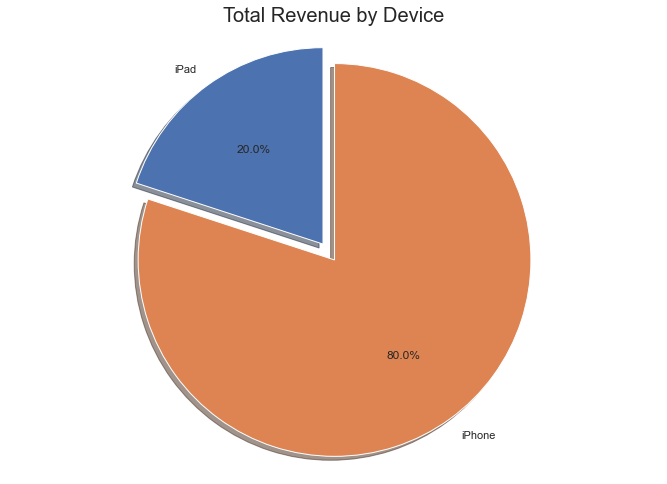

In [269]:
fig1, ax1 = plt.subplots()
ax1.pie(device_summary2.total_revenue, explode= (0, 0.1) , labels=device_summary2.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Total Revenue by Device', fontsize=20)

plt.show()

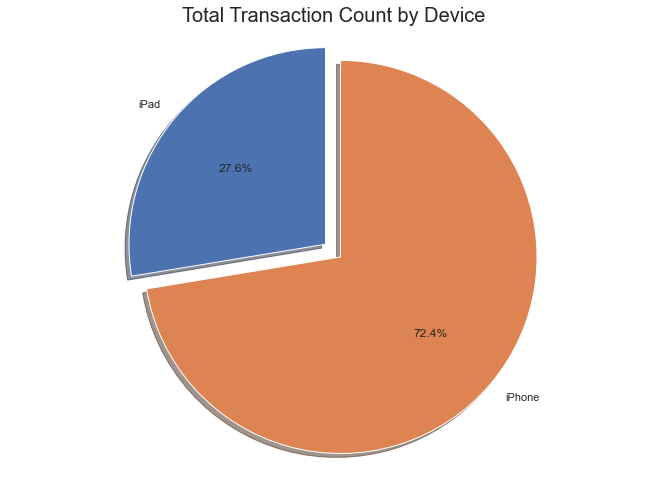

In [270]:
fig1, ax1 = plt.subplots()
ax1.pie(device_summary2.total_transaction_ct, explode= (0, 0.1) , labels=device_summary2.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Total Transaction Count by Device', fontsize=20)

plt.show()

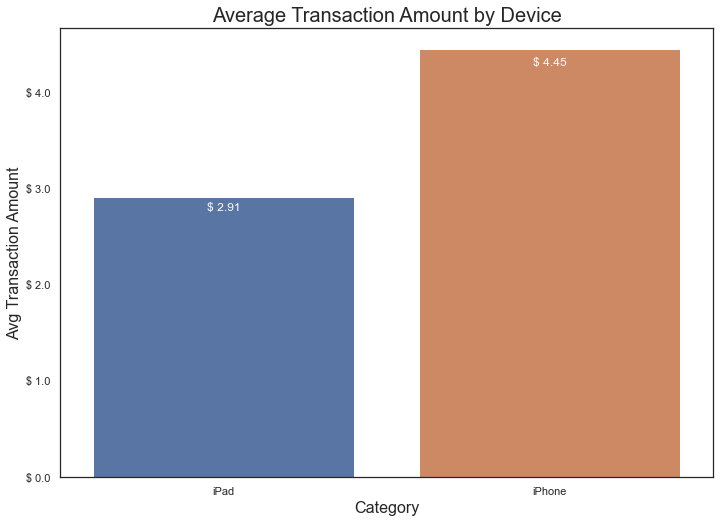

In [271]:
ax = sns.barplot(x= device_summary2.index, y = 'avg_transaction_amt', data = device_summary2)
ax.set_title('Average Transaction Amount by Device', fontsize=20)
ax.yaxis.set_major_formatter('$ {x}')
ax.set_xlabel("Category", fontsize = 16)
ax.set_ylabel("Avg Transaction Amount", fontsize = 16)
for p in ax.patches:
    ax.annotate("$ " + format(round(p.get_height(),2), '.2f'), (p.get_x()+0.4, p.get_height()*0.98), ha='center', va='top', color='white', size=12)

#### - Among Apps that could be used on both iphone and ipad, people are more likely to purchase them with iPhone. 
#### - Among Apps that could be used on both iphone and ipad, Apps purchased via iPhone is relatively more expensive compared to those purchased with iPad. 
#### - That means the marketing campaign and purchase process on iPhone is more important. 

## 3.3 Payment Type

### Hypothesis testing : will payment method on file reduce the possibility to be a dormant account? 

In [272]:
account_summary.head()

,acct_id,account_create_dt,payment_type,Entertainment_revenue,Games_revenue,Photos & Videos_revenue,Social Networking_revenue,Utilities_revenue,total_revenue,total_txn,paid_acct_flag,no_txn_flag,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years,Tenure_Band,acct_txn_group
0,eb23e449d274bddb,2012-04-03,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,1632 days,"1,632.00",53.62,4.47,3 - 5 years,Dormant
1,3d60dcb8494a0d70,2009-08-31,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,2578 days,"2,578.00",84.70,7.06,5 years+,Dormant
2,9b6d6fbf76504d85,2008-11-06,PMOF,77.87,897.20,276.61,64.92,52.90,"1,369.50",159.00,Purchased Paid App,Active,2876 days,"2,876.00",94.49,7.87,5 years+,High
3,343255370828b380,2012-01-03,PMOF,103.86,591.34,181.66,74.93,59.87,"1,011.66",141.00,Purchased Paid App,Active,1723 days,"1,723.00",56.61,4.72,3 - 5 years,High
4,664e27f05189c387,2010-10-31,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,2152 days,"2,152.00",70.70,5.89,5 years+,Dormant


In [273]:
txn_acct_payment = account_summary[(~account_summary['acct_id'].isin(outliers1)) & (~account_summary['acct_id'].isin(outliers2))].groupby(['payment_type','paid_acct_flag']).agg(no_txn_acct_ct = ('acct_id', 'nunique')).reset_index()

In [274]:
txn_acct_payment.head()

,payment_type,paid_acct_flag,no_txn_acct_ct
0,Free only,Dormant,35007
1,Free only,Free Only,14993
2,PMOF,Dormant,35018
3,PMOF,Purchased Paid App,14832


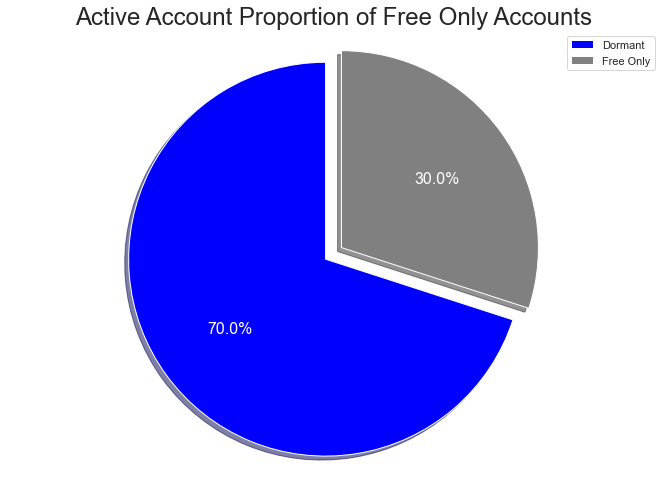

In [275]:
fig1, ax1 = plt.subplots()
ax1.pie(txn_acct_payment[txn_acct_payment['payment_type']=='Free only'].no_txn_acct_ct, explode= (0,0.1) , labels= txn_acct_payment[txn_acct_payment['payment_type']=='Free only'].paid_acct_flag, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['blue','grey'], textprops={'color':"w",'size':16})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Active Account Proportion of Free Only Accounts', fontsize=24)
plt.legend(loc="best")
plt.show()

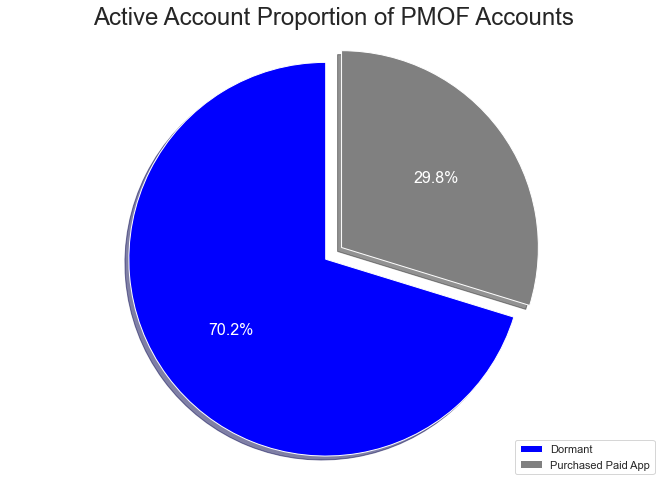

In [276]:
fig1, ax1 = plt.subplots()
ax1.pie(txn_acct_payment[txn_acct_payment['payment_type']=='PMOF'].no_txn_acct_ct, explode= (0, 0.1) , labels= txn_acct_payment[txn_acct_payment['payment_type']=='PMOF'].paid_acct_flag, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['blue','grey'], textprops={'color':"w",'size':16})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Active Account Proportion of PMOF Accounts', fontsize=24)
plt.legend(loc="best")
plt.show()

### Hypothesis testing : will payment method on file increase the possibility to download/purchase an App? 

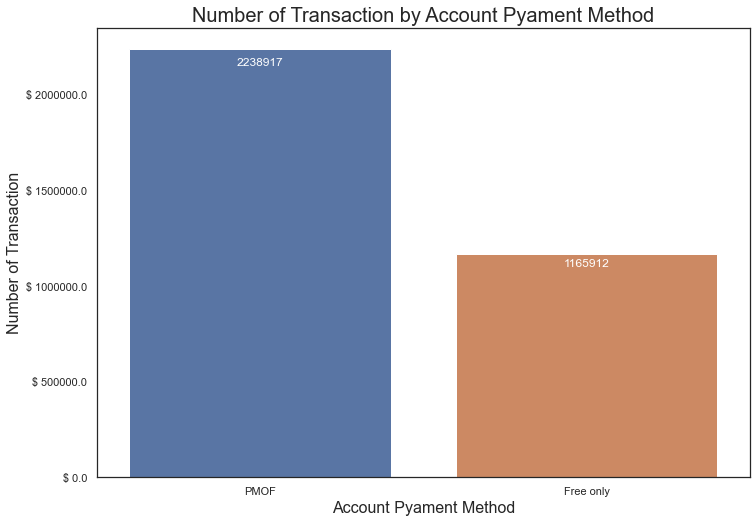

In [277]:
ax = sns.countplot(x= 'payment_type', data = transaction_df_final)
ax.set_title('Number of Transaction by Account Pyament Method', fontsize=20)
ax.yaxis.set_major_formatter('$ {x}')
ax.set_xlabel("Account Pyament Method", fontsize = 16)
ax.set_ylabel("Number of Transaction", fontsize = 16)
for p in ax.patches:
    ax.annotate(format(round(p.get_height()), '.0f'), (p.get_x()+0.4, p.get_height()*0.98), ha='center', va='top', color='white', size=12)

In [278]:
account_summary.head()

,acct_id,account_create_dt,payment_type,Entertainment_revenue,Games_revenue,Photos & Videos_revenue,Social Networking_revenue,Utilities_revenue,total_revenue,total_txn,paid_acct_flag,no_txn_flag,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years,Tenure_Band,acct_txn_group
0,eb23e449d274bddb,2012-04-03,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,1632 days,"1,632.00",53.62,4.47,3 - 5 years,Dormant
1,3d60dcb8494a0d70,2009-08-31,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,2578 days,"2,578.00",84.70,7.06,5 years+,Dormant
2,9b6d6fbf76504d85,2008-11-06,PMOF,77.87,897.20,276.61,64.92,52.90,"1,369.50",159.00,Purchased Paid App,Active,2876 days,"2,876.00",94.49,7.87,5 years+,High
3,343255370828b380,2012-01-03,PMOF,103.86,591.34,181.66,74.93,59.87,"1,011.66",141.00,Purchased Paid App,Active,1723 days,"1,723.00",56.61,4.72,3 - 5 years,High
4,664e27f05189c387,2010-10-31,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,2152 days,"2,152.00",70.70,5.89,5 years+,Dormant


In [279]:
account_summary['avg_spend_amount'] = account_summary['total_revenue']/account_summary['total_txn']
account_summary['acct_tenure'] = transaction_df_final['transaction_dt'].max() - account_summary['account_create_dt']
account_summary['acct_tenure_days'] = account_summary['acct_tenure']/np.timedelta64(1,'D')
account_summary['acct_tenure_months'] = account_summary['acct_tenure']/np.timedelta64(1,'M')
account_summary['acct_tenure_years'] = account_summary['acct_tenure']/np.timedelta64(1,'Y')

In [280]:
tenure_cut_labels = ['transactions without account','1 month', '2- 6 months', '6 months - 1 year', '1- 3 years','3 - 5 years', '5 years+']
tenure_cut_bins = [transaction_df_final['acct_tenure_months'].min(), 0, 1, 6, 12,36, 60, transaction_df_final['acct_tenure_months'].max()]
account_summary['Tenure_Band'] = pd.cut(account_summary['acct_tenure_months'], bins = tenure_cut_bins, labels = tenure_cut_labels)

In [281]:
account_summary.head()

,acct_id,account_create_dt,payment_type,Entertainment_revenue,Games_revenue,Photos & Videos_revenue,Social Networking_revenue,Utilities_revenue,total_revenue,total_txn,paid_acct_flag,no_txn_flag,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years,Tenure_Band,acct_txn_group,avg_spend_amount
0,eb23e449d274bddb,2012-04-03,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,1632 days,"1,632.00",53.62,4.47,3 - 5 years,Dormant,NaN
1,3d60dcb8494a0d70,2009-08-31,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,2578 days,"2,578.00",84.70,7.06,5 years+,Dormant,NaN
2,9b6d6fbf76504d85,2008-11-06,PMOF,77.87,897.20,276.61,64.92,52.90,"1,369.50",159.00,Purchased Paid App,Active,2876 days,"2,876.00",94.49,7.87,5 years+,High,8.61
3,343255370828b380,2012-01-03,PMOF,103.86,591.34,181.66,74.93,59.87,"1,011.66",141.00,Purchased Paid App,Active,1723 days,"1,723.00",56.61,4.72,3 - 5 years,High,7.17
4,664e27f05189c387,2010-10-31,PMOF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Dormant,Dormant,2152 days,"2,152.00",70.70,5.89,5 years+,Dormant,NaN


In [282]:
payment1 = account_summary.groupby(['payment_type']).agg(total_revenue = ('total_revenue',sum),total_txn = ('total_txn',sum), total_acct_ct = ('acct_id','count'))
payment1['avg_txn'] = payment1['total_txn']/payment1['total_acct_ct']

In [283]:
payment1

,total_revenue,total_txn,total_acct_ct,avg_txn
payment_type,,,,
Free only,0.00,"1,165,912.00",50000,23.32
PMOF,"19,028,980.30","2,436,591.00",50000,48.73


In [284]:
payment1.to_csv('payment1.csv')

In [285]:
payment2 = account_summary.groupby(['payment_type','paid_acct_flag']).agg(total_revenue = ('total_revenue',sum),total_txn = ('total_txn',sum), total_acct_ct = ('acct_id','count'))
payment2['avg_txn'] = payment2['total_txn']/payment2['total_acct_ct']

In [286]:
payment2

total_revenue    total_txn  total_acct_ct  \
payment_type paid_acct_flag                                                  
Free only    Dormant                      0.00         0.00          35007   
             Free Only                    0.00 1,165,912.00          14993   
PMOF         Dormant                      0.00         0.00          35018   
             Purchased Paid App  19,028,980.30 2,436,591.00          14982   

                                 avg_txn  
payment_type paid_acct_flag               
Free only    Dormant                0.00  
             Free Only             77.76  
PMOF         Dormant                0.00  
             Purchased Paid App   162.63

In [287]:
payment2.to_csv('payment2.csv')

#### - Payment method on file will not affect the possibility to download an App

### Hypothesis testing : will payment method on file increase the possibility to download more Apps? 

H0 : PMOF will not affect the number of apps downloaded. 
The average number of apps downloaded by free only accounts is the same as average number of apps downloaded by PMOF accounts.

H1 : PMOF will affect the number of apps downloaded. 
The average number of apps downloaded by free only accounts is not the same as average number of apps downloaded by PMOF accounts.

Control Group: free only accounts
Test Group: PMOF accounts

In [288]:
control = account_summary[account_summary['payment_type'] == 'Free only']['total_txn']
test = account_summary[account_summary['payment_type'] == 'PMOF']['total_txn']

In [289]:
mean_control = control.mean()
mean_test = test.mean()

In [290]:
n_control = len(control)
n_test = len(test)

n_control = 50000 > 30, large sample

n_test = 50000 > 30, large sample

Since population variance is unknown and the sample size is big, this would be a t-test.

Assumed alpha is 5% and beta is 80%

In [291]:
alpha = 0.05
beta = 0.8

In [292]:
d_hat = mean_test - mean_control

In [293]:
def variance(data):
    # Number of observations
    n = len(data)
    # Mean of the data
    mean = sum(data) / n
    # Square deviations
    deviations = [(x - mean) ** 2 for x in data]
    # Variance
    variance = sum(deviations) / n
    return variance

In [294]:
variance_control = variance(control)
variance_test = variance(test)

In [295]:
print("variance of the control and test group is: ",round(np.sqrt(variance_control),4),round(np.sqrt(variance_test),4))

variance of the control and test group is:  35.9551 98.1742


In [296]:
n_control = len(control)

In [297]:
variance_pool = ((n_control - 1) * variance_control + (n_test - 1) * variance_test) / (n_control - 1 + n_test -1)

In [298]:
print(variance_pool)

5465.471431396483


In [299]:
SE = np.sqrt(variance_pool) * np.sqrt((1/n_control + 1/n_test))

In [300]:
t_threshold = 1.96 
# 95% confidence interval

In [301]:
margin_of_error = SE * t_threshold

In [302]:
lower_bound = d_hat - margin_of_error
upper_bound = d_hat + margin_of_error

In [303]:
print(f'Confidence interval is {round(d_hat - margin_of_error,4)} to {round(d_hat + margin_of_error,4)}')

Confidence interval is 24.4971 to 26.33


#### These two groups are extremely statistically significant.
#### In other words, adding PMOF on account are more likely to download more Apps. Motivating users to add payment method could increase account activity. 

## 3.4 InApp Content Type

### Hypothesis testing : will subscribtion apps increase revenue? 

Text(0, 0.5, 'Number of Transaction')

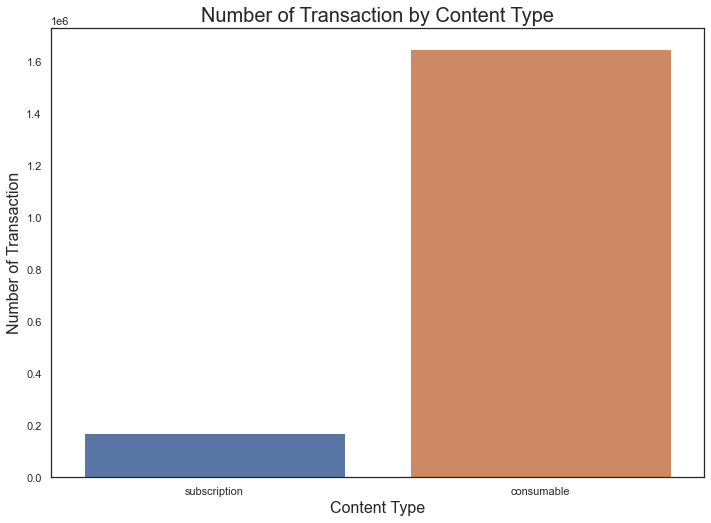

In [304]:
ax = sns.countplot(x= 'inapp_content_type', data = transaction_df_final)
ax.set_title('Number of Transaction by Content Type', fontsize=20)
ax.set_xlabel("Content Type", fontsize = 16)
ax.set_ylabel("Number of Transaction", fontsize = 16)

In [305]:
app_summary = app_df.groupby(['category_name','inapp_content_type']).agg(app_ct= ('parent_app_content_id','nunique'),content_ct = ('content_id','nunique')).reset_index()

In [306]:
app_summary['category_app_ct'] = app_summary.groupby(['category_name'])['app_ct'].transform('sum')
app_summary['total_app_ct'] = app_summary['app_ct'].sum()
app_summary['category_app_ct%'] = app_summary['app_ct']/app_summary['category_app_ct']
app_summary['total_app_ct%'] = app_summary['app_ct']/app_summary['total_app_ct']

In [307]:
app_summary

,category_name,inapp_content_type,app_ct,content_ct,category_app_ct,total_app_ct,category_app_ct%,total_app_ct%
0,Entertainment,consumable,47,184,68,476,0.69,0.10
1,Entertainment,subscription,21,75,68,476,0.31,0.04
2,Games,consumable,192,1006,192,476,1.00,0.40
3,Photos & Videos,consumable,113,585,134,476,0.84,0.24
4,Photos & Videos,subscription,21,121,134,476,0.16,0.04
5,Social Networking,consumable,20,122,22,476,0.91,0.04
6,Social Networking,subscription,2,12,22,476,0.09,0.00
7,Utilities,consumable,44,210,60,476,0.73,0.09
8,Utilities,subscription,16,61,60,476,0.27,0.03


In [308]:
app_summary.to_csv('app_summary.csv')

#### The duplicates come from the unknown app_name. We need to use column 'parent_app_content_id' to identify each unique App.

Text(0, 0.5, 'Content Type')

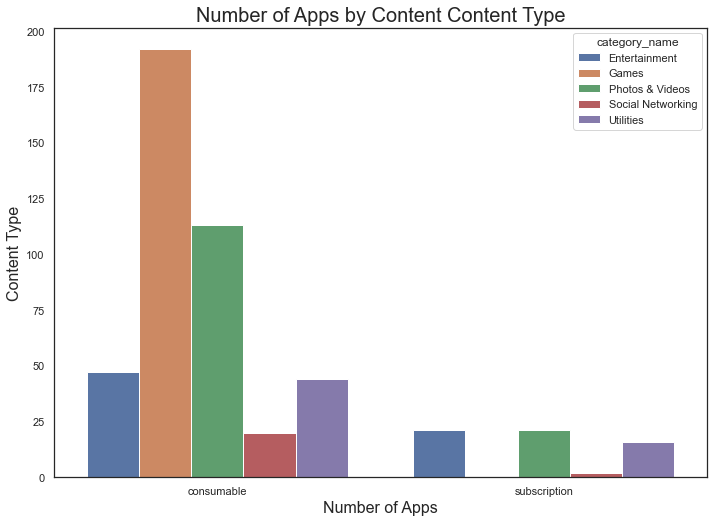

In [309]:
ax = sns.barplot(x= 'inapp_content_type', y = 'app_ct', data = app_summary, hue = 'category_name')
ax.set_title('Number of Apps by Content Content Type', fontsize=20)
ax.set_xlabel("Number of Apps", fontsize = 16)
ax.set_ylabel("Content Type", fontsize = 16)

#### Since games has no subscription Apps and the number of Apps in social entworking is too small, I will focus on the other three categores. 

### Subscription transaction vs consumable transaction

In [310]:
subscription = transaction_df_final[(transaction_df_final['category_name'] != 'Games') & (transaction_df_final['category_name'] != 'Social Networking')]\
                [['app_name', 'content_id','category_name','parent_app_content_id','inapp_content_type','acct_id','price','transaction_year_month']]

In [311]:
subscription.head()

,app_name,content_id,category_name,parent_app_content_id,inapp_content_type,acct_id,price,transaction_year_month
0,Events Bildad'S,b6cf4f33e7455df4,Utilities,61cea77b9bc843d1,subscription,220574a7a6a71afa,11.99,2016-08
1,Swell Questionably,71ac3e9c38ddbbba,Utilities,1f0ebd67df5846cd,consumable,8551f69a5015ea6a,1.99,2016-09
4,Turning Thanked,30581219bc952dbb,Entertainment,478e10f9248b7842,consumable,35aaf59d64a677e7,11.99,2016-06
7,Harpooneer? Ah!,04c46029e25f912c,Photos & Videos,95a1196981a36a54,consumable,0e222a3ec62eae6f,1.99,2016-09
8,Christendom Rage,1efa5d3f3d6217ff,Photos & Videos,30788879caff58ed,consumable,f6a26c8bf8a4c49e,2.99,2016-07


In [312]:
subscription_summary = subscription.groupby(['inapp_content_type']).agg(app_name_ct = ('app_name', 'nunique'), \
                                                          parent_app_content_ct = ('parent_app_content_id', 'nunique'),\
                                                          content_ct = ('content_id', 'nunique'),\
                                                          sales_amount = ('price',sum))

In [313]:
subscription_summary['transaction_ct'] = subscription.groupby(['inapp_content_type']).size()
subscription_summary['avg_paid_content_ct_per_app'] = subscription_summary['content_ct']/subscription_summary['parent_app_content_ct']
subscription_summary['avg_revenue_per_app'] = subscription_summary['sales_amount']/subscription_summary['parent_app_content_ct']
subscription_summary['avg_price_per_txn'] = subscription_summary['sales_amount']/subscription_summary['transaction_ct']
subscription_summary['avg_txn_per_app'] = subscription_summary['transaction_ct']/subscription_summary['parent_app_content_ct']
subscription_summary['avg_revenue_per_content'] = subscription_summary['sales_amount']/subscription_summary['content_ct']
subscription_summary['avg_txn_per_content'] = subscription_summary['transaction_ct']/subscription_summary['content_ct']

Assumed consumable App is a one-time purchase while subscription would be a repeated purchase. 

For the same group of accounts, they would only pay for each consumable App once and will continue to pay for sbscription App in a year. 

In that case, I will add a time ratio to current subscription sales. 

In [314]:
retention_rate = 0.6
# Assumed 60% of subscribers will finish the subscription

In [315]:
subscription_summary['estimated_annual_sales_amount'] = np.where(subscription_summary.index == 'subscription', subscription_summary['sales_amount'] * (1/ratio) * retention_rate, subscription_summary['sales_amount'])
subscription_summary['estimated_annual_transaction_ct'] = np.where(subscription_summary.index == 'subscription', subscription_summary['transaction_ct'] * (1/ratio) * retention_rate, subscription_summary['transaction_ct'])

subscription_summary['estimated_annual_revenue_per_app'] = np.where(subscription_summary.index == 'subscription', subscription_summary['avg_revenue_per_app'] * (1/ratio)  *retention_rate, subscription_summary['avg_revenue_per_app'])
subscription_summary['estimated_annual_txn_per_app'] = np.where(subscription_summary.index == 'subscription', subscription_summary['avg_txn_per_app'] * (1/ratio) * retention_rate, subscription_summary['avg_txn_per_app'])

subscription_summary['estimated_annual_revenue_per_content'] = np.where(subscription_summary.index == 'subscription', subscription_summary['avg_revenue_per_content'] * (1/ratio) * retention_rate, subscription_summary['avg_revenue_per_content'])
subscription_summary['estimated_annual_txn_per_content'] = np.where(subscription_summary.index == 'subscription', subscription_summary['avg_txn_per_content'] * (1/ratio)  *retention_rate, subscription_summary['avg_txn_per_content'])

In [316]:
subscription_summary

,app_name_ct,parent_app_content_ct,content_ct,sales_amount,transaction_ct,avg_paid_content_ct_per_app,avg_revenue_per_app,avg_price_per_txn,avg_txn_per_app,avg_revenue_per_content,avg_txn_per_content,estimated_annual_sales_amount,estimated_annual_transaction_ct,estimated_annual_revenue_per_app,estimated_annual_txn_per_app,estimated_annual_revenue_per_content,estimated_annual_txn_per_content
inapp_content_type,,,,,,,,,,,,,,,,,
consumable,204,204,979,"3,897,645.75",616025,4.80,"19,106.11",6.33,"3,019.73","3,981.25",629.24,"3,897,645.75","616,025.00","19,106.11","3,019.73","3,981.25",629.24
subscription,58,58,257,"1,041,604.69",162131,4.43,"17,958.70",6.42,"2,795.36","4,052.94",630.86,"2,036,709.17","317,024.01","35,115.68","5,465.93","7,924.94","1,233.56"


In [317]:
subscription_summary.to_csv('subscription_summary.csv')

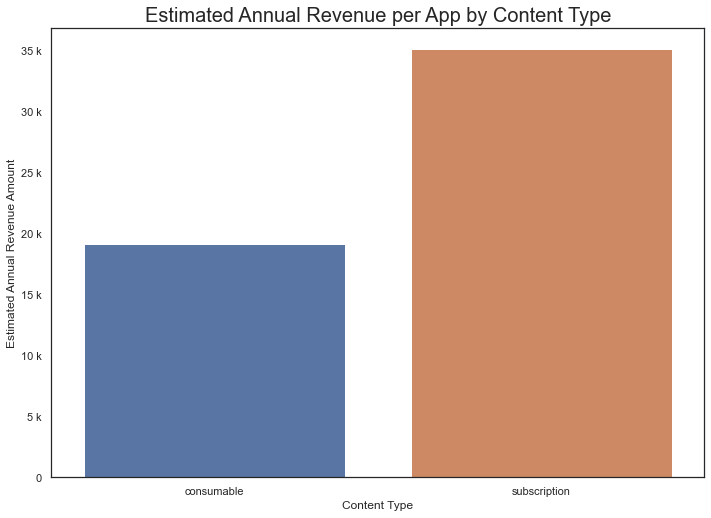

In [318]:
ax = sns.barplot(x= subscription_summary.index, y = 'estimated_annual_revenue_per_app', data = subscription_summary)
ax.set_title('Estimated Annual Revenue per App by Content Type', fontsize=20)
ax.set_xlabel("Content Type", fontsize = 12)
ax.set_ylabel("Estimated Annual Revenue Amount", fontsize = 12)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

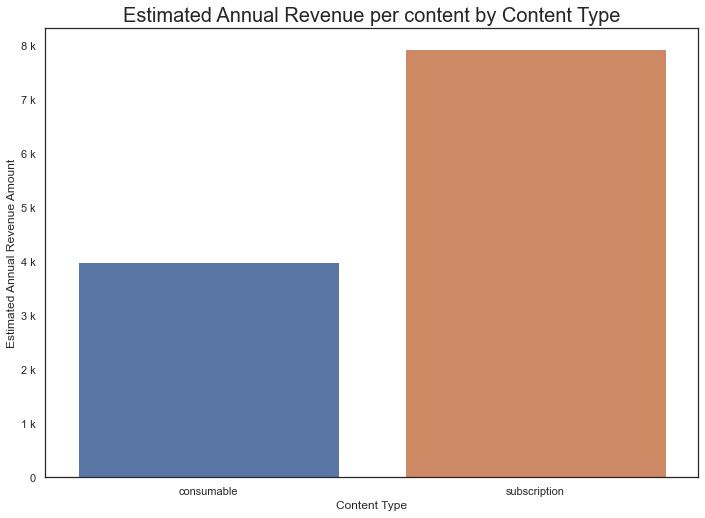

In [319]:
ax = sns.barplot(x= subscription_summary.index, y = 'estimated_annual_revenue_per_content', data = subscription_summary)
ax.set_title('Estimated Annual Revenue per content by Content Type', fontsize=20)
ax.set_xlabel("Content Type", fontsize = 12)
ax.set_ylabel("Estimated Annual Revenue Amount", fontsize = 12)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

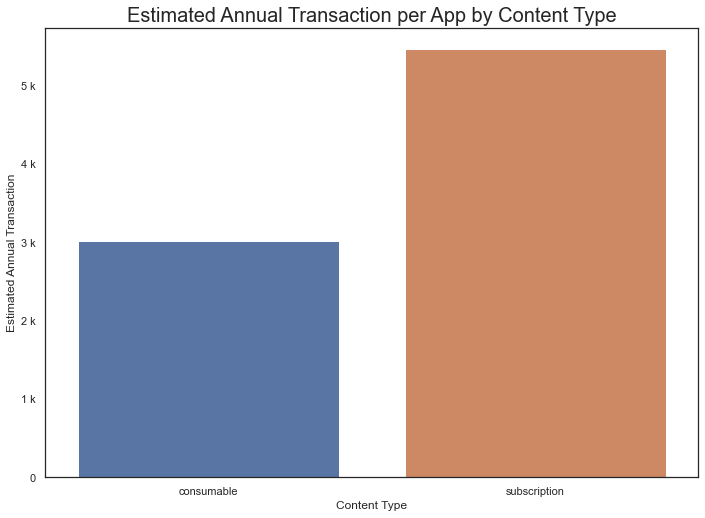

In [320]:
ax = sns.barplot(x= subscription_summary.index, y = 'estimated_annual_txn_per_app', data = subscription_summary)
ax.set_title('Estimated Annual Transaction per App by Content Type', fontsize=20)
ax.set_xlabel("Content Type", fontsize = 12)
ax.set_ylabel("Estimated Annual Transaction", fontsize = 12)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

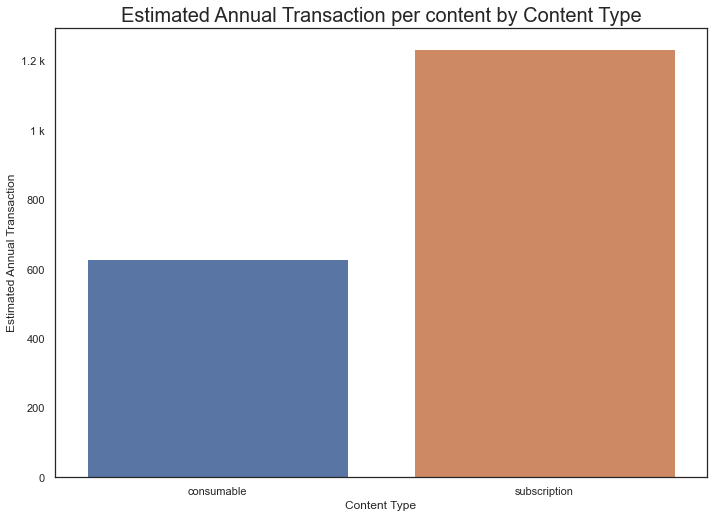

In [321]:
ax = sns.barplot(x= subscription_summary.index, y = 'estimated_annual_txn_per_content', data = subscription_summary)
ax.set_title('Estimated Annual Transaction per content by Content Type', fontsize=20)
ax.set_xlabel("Content Type", fontsize = 12)
ax.set_ylabel("Estimated Annual Transaction", fontsize = 12)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

In [322]:
subscription_content = subscription.groupby(['content_id','inapp_content_type']).agg(total_revenue = ('price',sum))
subscription_content['transaction_ct'] = subscription.groupby(['content_id','inapp_content_type']).size()

In [323]:
subscription_content = subscription_content.reset_index()

In [324]:
subscription_content.sort_values(by='transaction_ct').head()

,content_id,inapp_content_type,total_revenue,transaction_ct
709,936e3bb9326f8896,consumable,"2,126.67",533
240,394a4805c61c245f,consumable,"4,386.51",549
898,b9aacbfe773dbc28,consumable,"11,054.47",553
855,b00ca43c50228d05,consumable,"1,106.44",556
997,cdf9c4303c71df57,consumable,553.41,559


### Hypothesis testing : will subscription increase the average number of transaction of content? 

H0 : Content type will not affect the average number of transaction of content. 
The average number of transactions of consumable content is the same as average number of transactions of subscription content.

H1 : Content type will affect the average number of transaction of content. 
The average number of transactions of consumable content is not the same as average number of transactions of subscription content.

Control Group: consumable App content;
Test Group: subscription App content

In [325]:
control = subscription_content[subscription_content['inapp_content_type'] == 'consumable']['transaction_ct']
test = subscription_content[subscription_content['inapp_content_type'] == 'subscription']['transaction_ct']

In [326]:
mean_control = control.mean()
mean_test = test.mean()

In [327]:
n_control = len(control)
n_test = len(test)

In [328]:
print("sample size in control and test groups is: ", n_control, "and", n_test)

sample size in control and test groups is:  979 and 257


n_control = 979 > 30, large sample; n_test = 257 > 30, large sample

since population variance is unknown and the sample size is big, this would be a t-test.

Assumed alpha is 5% and beta is 80%

In [329]:
alpha = 0.05
beta = 0.8

In [330]:
d_hat = mean_test - mean_control

In [331]:
variance_control = variance(control)
variance_test = variance(test)

In [332]:
print("variance of the control and test group is: ",round(np.sqrt(variance_control),4),round(np.sqrt(variance_test),4))

variance of the control and test group is:  26.591 25.6695


In [333]:
variance_pool = ((n_control - 1) * variance_control + (n_test - 1) * variance_test) / (n_control - 1 + n_test -1)

In [334]:
SE = np.sqrt(variance_pool) * np.sqrt((1/n_control + 1/n_test))

In [335]:
t_threshold = 1.96 
# 95% confidence interval

In [336]:
margin_of_error = SE * t_threshold

In [337]:
lower_bound = d_hat - margin_of_error
upper_bound = d_hat + margin_of_error

In [338]:
print(f'Confidence interval is {round(d_hat - margin_of_error,4)} to {round(d_hat + margin_of_error,4)}')

Confidence interval is -2.0061 to 5.2479


#### These two groups are not statistically significant.
#### In other words, subscription will  not increase the number of transaction of content. 
#### There is alo possibility there is a sampling bais since we only have limited data (less than 4 months and less than 1000 Apps). 

### Hypothesis testing : will subscription increase the average revenue of content? 

H0 : Content type will not affect the average revenue of content. 
The average revenue of consumable content is the same as average revenue of subscription content.

H1 : Content type will affect the average revenue of content. 
The average revenue of consumable content is not the same as average revenue of subscription content.

Control Group: consumable App content;
Test Group: subscription App content

In [339]:
control = subscription_content[subscription_content['inapp_content_type'] == 'consumable']['total_revenue']
test = subscription_content[subscription_content['inapp_content_type'] == 'subscription']['total_revenue']

In [340]:
mean_control = control.mean()
mean_test = test.mean()

In [341]:
n_control = len(control)
n_test = len(test)

In [342]:
print("sample size in control and test groups is: ", n_control, "and", n_test)

sample size in control and test groups is:  979 and 257


n_control = 979 > 30, large sample; n_test = 257 > 30, large sample

since population variance is unknown and the sample size is big, this would be a t-test.

Assumed alpha is 5% and beta is 80%

In [343]:
alpha = 0.05
beta = 0.8

In [344]:
d_hat = mean_test - mean_control

In [345]:
variance_control = variance(control)
variance_test = variance(test)

In [346]:
print("variance of the control and test group is: ",round(np.sqrt(variance_control),4),round(np.sqrt(variance_test),4))

variance of the control and test group is:  3385.7906 3804.2896


In [347]:
variance_pool = ((n_control - 1) * variance_control + (n_test - 1) * variance_test) / (n_control - 1 + n_test -1)

In [348]:
SE = np.sqrt(variance_pool) * np.sqrt((1/n_control + 1/n_test))

In [349]:
t_threshold = 1.96 
# 95% confidence interval

In [350]:
margin_of_error = SE * t_threshold

In [351]:
lower_bound = d_hat - margin_of_error
upper_bound = d_hat + margin_of_error

In [352]:
print(f'Confidence interval is {round(d_hat - margin_of_error,4)} to {round(d_hat + margin_of_error,4)}')

Confidence interval is -405.9343 to 549.3033


### Subscription by category

In [353]:
subscription_category = subscription.groupby(['category_name','inapp_content_type']).agg(app_name_ct = ('app_name', 'nunique'), \
                                                          parent_app_content_ct = ('parent_app_content_id', 'nunique'),\
                                                          content_ct = ('content_id', 'nunique'),\
                                                          sales_amount = ('price',sum))

In [354]:
subscription_category['transaction_ct'] = subscription.groupby(['category_name','inapp_content_type']).size()
subscription_category['avg_paid_content_ct_per_app'] = subscription_category['content_ct']/subscription_category['parent_app_content_ct']
subscription_category['avg_revenue_per_app'] = subscription_category['sales_amount']/subscription_category['parent_app_content_ct']
subscription_category['avg_price_per_txn'] = subscription_category['sales_amount']/subscription_category['transaction_ct']
subscription_category['avg_txn_per_app'] = subscription_category['transaction_ct']/subscription_category['parent_app_content_ct']
subscription_category['avg_revenue_per_content'] = subscription_category['sales_amount']/subscription_category['content_ct']
subscription_category['avg_txn_per_content'] = subscription_category['transaction_ct']/subscription_category['content_ct']

In [355]:
subscription_category = subscription_category.reset_index()

In [356]:
subscription_category.head()

,category_name,inapp_content_type,app_name_ct,parent_app_content_ct,content_ct,sales_amount,transaction_ct,avg_paid_content_ct_per_app,avg_revenue_per_app,avg_price_per_txn,avg_txn_per_app,avg_revenue_per_content,avg_txn_per_content
0,Entertainment,consumable,47,47,184,"777,863.77",115923,3.91,"16,550.29",6.71,"2,466.45","4,227.52",630.02
1,Entertainment,subscription,21,21,75,"346,862.03",47197,3.57,"16,517.24",7.35,"2,247.48","4,624.83",629.29
2,Photos & Videos,consumable,113,113,585,"2,387,985.13",367487,5.18,"21,132.61",6.50,"3,252.10","4,082.03",628.18
3,Photos & Videos,subscription,21,21,121,"431,119.41",76159,5.76,"20,529.50",5.66,"3,626.62","3,562.97",629.41
4,Utilities,consumable,44,44,210,"731,796.85",132615,4.77,"16,631.75",5.52,"3,013.98","3,484.75",631.50


Assumed consumable App is a one-time purchase while subscription would be a repeated purchase. 

For the same group of accounts, they would only pay for each consumable App once and will continue to pay for sbscription App in a year. 

In that case, I will add a time ratio to current subscription sales. 

In [357]:
subscription_category['estimated_annual_sales_amount'] = np.where(subscription_category['inapp_content_type'] == 'subscription', subscription_category['sales_amount'] * (1/ratio) * retention_rate, subscription_category['sales_amount'])
subscription_category['estimated_annual_transaction_ct'] = np.where(subscription_category['inapp_content_type'] == 'subscription', subscription_category['transaction_ct'] * (1/ratio) * retention_rate, subscription_category['transaction_ct'])

subscription_category['estimated_annual_revenue_per_app'] = np.where(subscription_category['inapp_content_type'] == 'subscription', subscription_category['avg_revenue_per_app'] * (1/ratio) * retention_rate, subscription_category['avg_revenue_per_app'])
subscription_category['estimated_annual_txn_per_app'] = np.where(subscription_category['inapp_content_type'] == 'subscription', subscription_category['avg_txn_per_app'] * (1/ratio) * retention_rate, subscription_category['avg_txn_per_app'])

subscription_category['estimated_annual_revenue_per_content'] = np.where(subscription_category['inapp_content_type'] == 'subscription', subscription_category['avg_revenue_per_content'] * (1/ratio) * retention_rate, subscription_category['avg_revenue_per_content'])
subscription_category['estimated_annual_txn_per_content'] = np.where(subscription_category['inapp_content_type'] == 'subscription', subscription_category['avg_txn_per_content'] * (1/ratio) * retention_rate, subscription_category['avg_txn_per_content'])

In [358]:
subscription_category

,category_name,inapp_content_type,app_name_ct,parent_app_content_ct,content_ct,sales_amount,transaction_ct,avg_paid_content_ct_per_app,avg_revenue_per_app,avg_price_per_txn,avg_txn_per_app,avg_revenue_per_content,avg_txn_per_content,estimated_annual_sales_amount,estimated_annual_transaction_ct,estimated_annual_revenue_per_app,estimated_annual_txn_per_app,estimated_annual_revenue_per_content,estimated_annual_txn_per_content
0,Entertainment,consumable,47,47,184,"777,863.77",115923,3.91,"16,550.29",6.71,"2,466.45","4,227.52",630.02,"777,863.77","115,923.00","16,550.29","2,466.45","4,227.52",630.02
1,Entertainment,subscription,21,21,75,"346,862.03",47197,3.57,"16,517.24",7.35,"2,247.48","4,624.83",629.29,"678,239.15","92,286.99","32,297.10","4,394.62","9,043.19","1,230.49"
2,Photos & Videos,consumable,113,113,585,"2,387,985.13",367487,5.18,"21,132.61",6.50,"3,252.10","4,082.03",628.18,"2,387,985.13","367,487.00","21,132.61","3,252.10","4,082.03",628.18
3,Photos & Videos,subscription,21,21,121,"431,119.41",76159,5.76,"20,529.50",5.66,"3,626.62","3,562.97",629.41,"842,992.42","148,918.04","40,142.50","7,091.34","6,966.88","1,230.73"
4,Utilities,consumable,44,44,210,"731,796.85",132615,4.77,"16,631.75",5.52,"3,013.98","3,484.75",631.50,"731,796.85","132,615.00","16,631.75","3,013.98","3,484.75",631.50
5,Utilities,subscription,16,16,61,"263,623.25",38775,3.81,"16,476.45",6.80,"2,423.44","4,321.69",635.66,"515,477.60","75,818.97","32,217.35","4,738.69","8,450.45","1,242.93"


In [359]:
subscription_category.to_csv('subscription_category.csv')

#### Subscription in entertainment, Photos & Videos and utilities category can be more profitable compared to cosnumable. 
#### All the games apps are consumable. Providing games apps with subscription options may be a good idea. 

In [360]:
subscription_pivot = subscription.pivot_table(index = ['acct_id','content_id'], columns = ['transaction_year_month'], values = ['price'], aggfunc = sum).fillna(0)
subscription_pivot = subscription_pivot.loc[~(subscription_pivot==0).all(axis=1)]

In [361]:
subscription_pivot.columns = subscription_pivot.columns.droplevel(0)

In [362]:
subscription_pivot = subscription_pivot.reset_index()

In [363]:
subscription_pivot.head()

transaction_year_month,acct_id,content_id,2016-06,2016-07,2016-08,2016-09
0,0005a4d77127fde7,068bd28d9c3acd89,0.00,0.00,0.00,11.99
1,0005a4d77127fde7,09c8cf31fb1510bf,0.00,0.00,23.98,0.00
2,0005a4d77127fde7,0d9342e0f6b0305b,0.00,5.99,0.00,0.00
3,0005a4d77127fde7,1cad364c33a10456,2.99,0.00,0.00,0.00
4,0005a4d77127fde7,21d1389e3105312a,1.99,0.00,0.00,0.00


In [364]:
subscription_pivot.columns = ['acct_id', 'content_id','2016-06', '2016-07', '2016-08', '2016-09']

In [365]:
subscription_pivot['Jun_purchase'] = np.where(subscription_pivot['2016-06']>0 , 1,0)
subscription_pivot['Jul_purchase'] = np.where(subscription_pivot['2016-07']>0 , 1,0)
subscription_pivot['Aug_purchase'] = np.where(subscription_pivot['2016-08']>0 , 1,0)
subscription_pivot['Sep_purchase'] = np.where(subscription_pivot['2016-09']>0 , 1,0)
subscription_pivot['purchase_month_ct'] = subscription_pivot['Jun_purchase'] + subscription_pivot['Jul_purchase'] + subscription_pivot['Aug_purchase']+ subscription_pivot['Sep_purchase']
subscription_pivot['repeat_purchase'] = np.where((subscription_pivot['purchase_month_ct'])>1 , 1,0)

In [366]:
first_txn_dt = transaction_df_final.groupby(['acct_id','content_id']).agg(first_txn_dt = ('transaction_dt',min))

In [367]:
first_txn_dt = first_txn_dt.reset_index()

In [368]:
subscription_pivot = subscription_pivot.merge(first_txn_dt, on =['acct_id','content_id'], how = 'left')\
                                       .merge(app_df, on ='content_id', how = 'left')

In [369]:
subscription_pivot[subscription_pivot['repeat_purchase']== 1].head()

,acct_id,content_id,2016-06,2016-07,2016-08,2016-09,Jun_purchase,Jul_purchase,Aug_purchase,Sep_purchase,purchase_month_ct,repeat_purchase,first_txn_dt,app_name,parent_app_content_id,category_id,app_device_id,inapp_content_type,category_name,app_device_name,content_id_modified
31,0005a4d77127fde7,bef75d32f95f3716,6.99,0.00,0.00,6.99,1,0,0,1,2,1,2016-06-08,Paid Allay,92cb2652ce9b56c8,Y-8,3,subscription,Photos & Videos,Both,bef75d32f95f3716
38,0005a4d77127fde7,f0dd7fe795b9f854,0.00,0.00,2.99,2.99,0,0,1,1,2,1,2016-08-04,Features Boat!Ah,07a4877a07dbfc32,Y-8,3,consumable,Photos & Videos,Both,f0dd7fe795b9f854
51,0005c296f2605c08,36a699859b541245,11.99,0.00,0.00,11.99,1,0,0,1,2,1,2016-06-18,Shiver Salamed,80945b06bc21a7cc,Y-8,3,consumable,Photos & Videos,Both,36a699859b541245
81,0005c296f2605c08,aa00252ae970b345,0.00,3.99,0.00,3.99,0,1,0,1,2,1,2016-07-27,Police Rockings,2e738a49b2e31739,Y-8,2,consumable,Photos & Videos,iPad,aa00252ae970b345
207,001a568a27437962,332ef5579fee8aba,1.99,0.00,0.00,1.99,1,0,0,1,2,1,2016-06-21,Dawn Prolonged,a9c3ebf8b63bbc8a,Q-1,2,consumable,Entertainment,iPad,332ef5579fee8aba


In [370]:
subscription_pivot_summary = subscription_pivot.groupby(['category_name','inapp_content_type']).agg(acct_content_ct = ('acct_id','count'), content_ct = ('content_id','nunique'), repeat_purchase_acct_ct = ('repeat_purchase', 'sum'))

In [371]:
subscription_pivot_summary['avg_purchase_acct_per_content'] = subscription_pivot_summary['acct_content_ct']/subscription_pivot_summary['content_ct']
subscription_pivot_summary['avg_repeat_purchase_acct_per_content'] = subscription_pivot_summary['repeat_purchase_acct_ct']/subscription_pivot_summary['content_ct']

In [372]:
subscription_pivot_summary

acct_content_ct  content_ct  \
category_name   inapp_content_type                                
Entertainment   consumable                   113523         184   
                subscription                  46178          75   
Photos & Videos consumable                   359929         585   
                subscription                  74563         121   
Utilities       consumable                   129884         210   
                subscription                  37938          61   

                                    repeat_purchase_acct_ct  \
category_name   inapp_content_type                            
Entertainment   consumable                             1811   
                subscription                            748   
Photos & Videos consumable                             5610   
                subscription                           1197   
Utilities       consumable                             1988   
                subscription                            630   

                                    avg_purchase_acct_per_content  \
category_name   inapp_content_type                                  
Entertainment   consumable                                 616.97   
                subscription                               615.71   
Photos & Videos consumable                                 615.26   
                subscription                               616.22   
Utilities       consumable                                 618.50   
                subscription                               621.93   

                                    avg_repeat_purchase_acct_per_content  
category_name   inapp_content_type                                        
Entertainment   consumable                                          9.84  
                subscription                                        9.97  
Photos & Videos consumable                                          9.59  
                subscription                                        9.89  
Utilities       consumable                                          9.47  
                subscription                                       10.33

In [373]:
subscription_pivot_summary.to_csv('subscription_pivot_summary.csv')

In [374]:
subscription_ab_test_entertainment = subscription_pivot[(subscription_pivot['category_name'] == 'Entertainment') ]\
                                                            .groupby(['content_id','inapp_content_type']).agg(repeat_purchase_acct_ct = ('repeat_purchase', sum)).reset_index()
subscription_ab_test_utilities = subscription_pivot[(subscription_pivot['category_name'] == 'Utilities')]\
                                                            .groupby(['content_id','inapp_content_type']).agg(repeat_purchase_acct_ct = ('repeat_purchase', sum)).reset_index()
subscription_ab_test_PhotosVideos = subscription_pivot[(subscription_pivot['category_name'] == 'Photos & Videos') ]\
                                                            .groupby(['content_id','inapp_content_type']).agg(repeat_purchase_acct_ct = ('repeat_purchase', sum)).reset_index()

In [375]:
subscription_ab_test_entertainment.head()

,content_id,inapp_content_type,repeat_purchase_acct_ct
0,018619836f71fcf9,consumable,13
1,0187381ea763aeeb,subscription,9
2,022e4bd43a9e6fcd,subscription,12
3,0509b0c1fbbce110,consumable,10
4,05169a2d5ab630af,consumable,9


In [376]:
subscription_ab_test_utilities.head()

,content_id,inapp_content_type,repeat_purchase_acct_ct
0,0128b01bd866a6f1,consumable,9
1,01888c060c4b1aee,consumable,12
2,01b0d7b69ff5f04d,consumable,13
3,02287dc66736c41d,consumable,6
4,02e58f6e61612558,consumable,6


### Hypothesis testing : will subscription increase the possibility to repeat purchase in entertainment content? 

H0 : Content type will not affect if an account will repeat purchase a content or not. 
The average number of repeat purchased account of consumable Apps is the same as average number ofrepeat purchased account of subscription Apps.

H1 : Content type will affect if an account will repeat purchase a content or not. 
The average number of repeat purchased account of consumable Apps is not the same as average number ofrepeat purchased account of subscription Apps.

Control Group: consumable App content;
Test Group: subscription App content

In [377]:
control = subscription_ab_test_entertainment[subscription_ab_test_entertainment['inapp_content_type'] == 'consumable']['repeat_purchase_acct_ct']
test = subscription_ab_test_entertainment[subscription_ab_test_entertainment['inapp_content_type'] == 'subscription']['repeat_purchase_acct_ct']

In [378]:
mean_control = control.mean()
mean_test = test.mean()

In [379]:
n_control = len(control)
n_test = len(test)

In [380]:
print("sample size in control and test groups is: ", n_control, "and", n_test)

sample size in control and test groups is:  184 and 75


n_control = 184 > 30, large sample; n_test = 75 > 30, large sample

since population variance is unknown and the sample size is big, this would be a t-test.

Assumed alpha is 5% and beta is 80%

In [381]:
alpha = 0.05
beta = 0.8

In [382]:
d_hat = mean_test - mean_control

In [383]:
variance_control = variance(control)
variance_test = variance(test)

In [384]:
print("variance of the control and test group is: ",round(np.sqrt(variance_control),4),round(np.sqrt(variance_test),4))

variance of the control and test group is:  3.3415 3.3901


In [385]:
variance_pool = ((n_control - 1) * variance_control + (n_test - 1) * variance_test) / (n_control - 1 + n_test -1)

In [386]:
SE = np.sqrt(variance_pool) * np.sqrt((1/n_control + 1/n_test))

In [387]:
t_threshold = 1.96 
# 95% confidence interval

In [388]:
margin_of_error = SE * t_threshold

In [389]:
lower_bound = d_hat - margin_of_error
upper_bound = d_hat + margin_of_error

In [390]:
print(f'Confidence interval is {round(d_hat - margin_of_error,4)} to {round(d_hat + margin_of_error,4)}')

Confidence interval is -0.7701 to 1.0319


#### These two groups are not statistically significant.
#### In other words, subscription will not increase the repeat purchase in entertainment Apps. 
#### There is alo possibility there is a sampling bais since we only have limited data (less than 4 months and less than 1000 Apps). 

## Hypothesis testing : will subscription increase the possibility to repeat purchase in utilities content? 

H0 : Content type will not affect if an account will repeat purchase a content or not. 
The average number of repeat purchased account of consumable Apps is the same as average number ofrepeat purchased account of subscription Apps.

H1 : Content type will affect if an account will repeat purchase a content or not. 
The average number of repeat purchased account of consumable Apps is not the same as average number ofrepeat purchased account of subscription Apps.

Control Group: consumable App content;
Test Group: subscription App content

In [391]:
control = subscription_ab_test_utilities[subscription_ab_test_utilities['inapp_content_type'] == 'consumable']['repeat_purchase_acct_ct']
test = subscription_ab_test_utilities[subscription_ab_test_utilities['inapp_content_type'] == 'subscription']['repeat_purchase_acct_ct']

In [392]:
mean_control = control.mean()
mean_test = test.mean()

In [393]:
n_control = len(control)
n_test = len(test)

In [394]:
print("sample size in control and test groups is: ", n_control, "and", n_test)

sample size in control and test groups is:  210 and 61


n_control = 210 > 30, large sample; n_test = 61 > 30, large sample

since population variance is unknown and the sample size is big, this would be a t-test.

Assumed alpha is 5% and beta is 80%

In [395]:
alpha = 0.05
beta = 0.8

In [396]:
d_hat = mean_test - mean_control

In [397]:
variance_control = variance(control)
variance_test = variance(test)

In [398]:
print("variance of the control and test group is: ",round(np.sqrt(variance_control),4),round(np.sqrt(variance_test),4))

variance of the control and test group is:  2.8084 3.6517


In [399]:
variance_pool = ((n_control - 1) * variance_control + (n_test - 1) * variance_test) / (n_control - 1 + n_test -1)

In [400]:
SE = np.sqrt(variance_pool) * np.sqrt((1/n_control + 1/n_test))

In [401]:
t_threshold = 1.96 
# 95% confidence interval

In [402]:
margin_of_error = SE * t_threshold

In [403]:
lower_bound = d_hat - margin_of_error
upper_bound = d_hat + margin_of_error

In [404]:
print(f'Confidence interval is {round(d_hat - margin_of_error,4)} to {round(d_hat + margin_of_error,4)}')

Confidence interval is 0.0011 to 1.7213


#### These two groups are statistically significant.
#### In other words, subscription will increase the repeat purchase in utilities Apps. 

### Hypothesis testing : will subscription increase the possibility to repeat purchase in Photos & Videos content? 

H0 : Content type will not affect if an account will repeat purchase a content or not. 
The average number of repeat purchased account of consumable Apps is the same as average number ofrepeat purchased account of subscription Apps.

H1 : Content type will affect if an account will repeat purchase a content or not. 
The average number of repeat purchased account of consumable Apps is not the same as average number ofrepeat purchased account of subscription Apps.

Control Group: consumable App content;
Test Group: subscription App content

In [405]:
control = subscription_ab_test_PhotosVideos[subscription_ab_test_PhotosVideos['inapp_content_type'] == 'consumable']['repeat_purchase_acct_ct']
test = subscription_ab_test_PhotosVideos[subscription_ab_test_PhotosVideos['inapp_content_type'] == 'subscription']['repeat_purchase_acct_ct']

In [406]:
mean_control = control.mean()
mean_test = test.mean()

In [407]:
n_control = len(control)
n_test = len(test)

In [408]:
print("sample size in control and test groups is: ", n_control, "and", n_test)

sample size in control and test groups is:  585 and 121


n_control = 210 > 30, large sample; n_test = 61 > 30, large sample

Since population variance is unknown and the sample size is big, this would be a t-test.

Assumed alpha is 5% and beta is 80%

In [409]:
alpha = 0.05
beta = 0.8

In [410]:
d_hat = mean_test - mean_control

In [411]:
variance_control = variance(control)
variance_test = variance(test)

In [412]:
print("variance of the control and test group is: ",round(np.sqrt(variance_control),4),round(np.sqrt(variance_test),4))

variance of the control and test group is:  3.0465 3.117


In [413]:
variance_pool = ((n_control - 1) * variance_control + (n_test - 1) * variance_test) / (n_control - 1 + n_test -1)

In [414]:
SE = np.sqrt(variance_pool) * np.sqrt((1/n_control + 1/n_test))

In [415]:
t_threshold = 1.96 
# 95% confidence interval

In [416]:
margin_of_error = SE * t_threshold

In [417]:
lower_bound = d_hat - margin_of_error
upper_bound = d_hat + margin_of_error

In [418]:
print(f'Confidence interval is {round(d_hat - margin_of_error,4)} to {round(d_hat + margin_of_error,4)}')

Confidence interval is -0.2959 to 0.9015


#### These two groups are not statistically significant.
#### In other words, subscription will not increase the repeat purchase in photos & videos Apps. 
#### There is alo possibility there is a sampling bais since we only have limited data (less than 4 months and less than 1000 Apps). 

## Repeat purchase possibility in category

In [419]:
transaction_df_final[['app_name', 'content_id','category_name','parent_app_content_id','inapp_content_type','acct_id','price','transaction_year_month']].head()

,app_name,content_id,category_name,parent_app_content_id,inapp_content_type,acct_id,price,transaction_year_month
0,Events Bildad'S,b6cf4f33e7455df4,Utilities,61cea77b9bc843d1,subscription,220574a7a6a71afa,11.99,2016-08
1,Swell Questionably,71ac3e9c38ddbbba,Utilities,1f0ebd67df5846cd,consumable,8551f69a5015ea6a,1.99,2016-09
2,Supperlessmy Shipmates,776b851b916c33d1,Games,1383e4f2f49f0f44,consumable,7dedf309494a1966,0.99,2016-08
3,Unwritten Hungry,7a47ca132a8dc695,Games,8590a25d4e5c249c,consumable,7174a81c796dcf7e,1.99,2016-06
4,Turning Thanked,30581219bc952dbb,Entertainment,478e10f9248b7842,consumable,35aaf59d64a677e7,11.99,2016-06


In [420]:
repeat_purchase_pivot = transaction_df_final.pivot_table(index = ['acct_id','content_id','category_name'], columns = ['transaction_year_month'], values = ['price'], aggfunc = sum).fillna(0)

In [421]:
repeat_purchase_pivot.head()

price                  \
transaction_year_month                            2016-06 2016-07 2016-08   
acct_id          content_id       category_name                             
0005a4d77127fde7 0378c35cee8625c9 Games              0.00    0.00    0.00   
                 04d25a3fc93b0626 Games              0.00    0.00    0.00   
                 066d89aa2cb21b22 Games             19.99    0.00    0.00   
                 068bd28d9c3acd89 Photos & Videos    0.00    0.00    0.00   
                 09c8cf31fb1510bf Entertainment      0.00    0.00   23.98   

                                                           
transaction_year_month                            2016-09  
acct_id          content_id       category_name            
0005a4d77127fde7 0378c35cee8625c9 Games             14.99  
                 04d25a3fc93b0626 Games              2.99  
                 066d89aa2cb21b22 Games              0.00  
                 068bd28d9c3acd89 Photos & Videos   11.99  
                 09c8cf31fb1510bf Entertainment      0.00

In [422]:
repeat_purchase_pivot  = repeat_purchase_pivot .loc[~(repeat_purchase_pivot ==0).all(axis=1)]
repeat_purchase_pivot.columns = repeat_purchase_pivot.columns.droplevel(0)
repeat_purchase_pivot = repeat_purchase_pivot.reset_index()

In [423]:
repeat_purchase_pivot.head()

transaction_year_month,acct_id,content_id,category_name,2016-06,2016-07,2016-08,2016-09
0,0005a4d77127fde7,0378c35cee8625c9,Games,0.00,0.00,0.00,14.99
1,0005a4d77127fde7,04d25a3fc93b0626,Games,0.00,0.00,0.00,2.99
2,0005a4d77127fde7,066d89aa2cb21b22,Games,19.99,0.00,0.00,0.00
3,0005a4d77127fde7,068bd28d9c3acd89,Photos & Videos,0.00,0.00,0.00,11.99
4,0005a4d77127fde7,09c8cf31fb1510bf,Entertainment,0.00,0.00,23.98,0.00


In [424]:
repeat_purchase_pivot.columns = ['acct_id', 'content_id','category_name','2016-06', '2016-07', '2016-08', '2016-09']

In [425]:
repeat_purchase_pivot['Jun_purchase'] = np.where(repeat_purchase_pivot['2016-06']>0 , 1,0)
repeat_purchase_pivot['Jul_purchase'] = np.where(repeat_purchase_pivot['2016-07']>0 , 1,0)
repeat_purchase_pivot['Aug_purchase'] = np.where(repeat_purchase_pivot['2016-08']>0 , 1,0)
repeat_purchase_pivot['Sep_purchase'] = np.where(repeat_purchase_pivot['2016-09']>0 , 1,0)
repeat_purchase_pivot['purchase_month_ct'] = repeat_purchase_pivot['Jun_purchase'] + repeat_purchase_pivot['Jul_purchase'] + repeat_purchase_pivot['Aug_purchase']+ repeat_purchase_pivot['Sep_purchase']
repeat_purchase_pivot['repeat_purchase'] = np.where((repeat_purchase_pivot['purchase_month_ct'])>1 , 1,0)

In [426]:
repeat_purchase_pivot[repeat_purchase_pivot['repeat_purchase']== 1].head()

,acct_id,content_id,category_name,2016-06,2016-07,2016-08,2016-09,Jun_purchase,Jul_purchase,Aug_purchase,Sep_purchase,purchase_month_ct,repeat_purchase
26,0005a4d77127fde7,40ea39cdd2cf6ffd,Games,0.00,6.99,6.99,0.00,0,1,1,0,2,1
33,0005a4d77127fde7,4d34d5a904ed7546,Games,10.99,10.99,0.00,0.00,1,1,0,0,2,1
76,0005a4d77127fde7,bef75d32f95f3716,Photos & Videos,6.99,0.00,0.00,6.99,1,0,0,1,2,1
102,0005a4d77127fde7,f0dd7fe795b9f854,Photos & Videos,0.00,0.00,2.99,2.99,0,0,1,1,2,1
112,0005c296f2605c08,07430914b578e8bb,Games,0.99,0.00,0.99,0.00,1,0,1,0,2,1


In [427]:
repeat_purchase_summary = repeat_purchase_pivot.groupby(['category_name']).agg(repeat_purchase_ct = ('repeat_purchase','count'), content_ct = ('content_id','nunique'))

In [428]:
repeat_purchase_summary['avg_repeat_purchase_ct'] = repeat_purchase_summary['repeat_purchase_ct']/repeat_purchase_summary['content_ct']

In [429]:
repeat_purchase_summary

,repeat_purchase_ct,content_ct,avg_repeat_purchase_ct
category_name,,,
Entertainment,159701,259,616.61
Games,907339,1006,901.93
Photos & Videos,434492,706,615.43
Social Networking,82721,134,617.32
Utilities,167822,271,619.27


### Games content demostrated the highest repeat purchase times

In [430]:
repeat_purchase_summary.to_csv('repeat_purchase_summary.csv')

## 4. Other Analysis

## 4.1 The relationship between price change (promotion)  and sales/transaction

In [431]:
regular_price = transaction_df_final.groupby(['content_id']).agg(regular_price = ('price',statistics.mode))

In [432]:
price = transaction_df_final.groupby(['content_id','price']).agg(price_occur_days = ('transaction_dt','nunique'))

In [433]:
price['most_days'] = price.groupby(['content_id','price'])['price_occur_days'].max()

In [434]:
regular_price = price[price['price_occur_days'] == price['most_days']].reset_index()

In [435]:
regular_price.rename(columns = {'price':'regular price'}, inplace = True)
regular_price.drop(['price_occur_days','most_days'],axis = 1, inplace = True)

In [436]:
regular_price.head()

,content_id,regular price
0,0052e4fbb5a6c259,0.99
1,0090cc76db298a8f,17.99
2,00940db10d26b770,20.99
3,00bc137c2cdb50ee,13.99
4,00ded25ad8f5b244,10.99


In [437]:
transaction_df_final = transaction_df_final.merge(regular_price, on = 'content_id', how = 'left')

In [438]:
transaction_df_final['promotion_flag'] = np.where(transaction_df_final['price'] < transaction_df_final['regular price'],1,0)
transaction_df_final['promotion_rate'] = 1- transaction_df_final['price']/transaction_df_final['regular price']

In [439]:
transaction_df_final.head()

,transaction_dt,transaction_content_id,acct_id,price,transaction_device_id,app_name,parent_app_content_id,category_id,category_name,app_device_id,app_device_name,content_id,inapp_content_type,transaction_device_name,account_create_dt,payment_type,acct_txn_group,transaction_year_month,transaction_year,transaction_month,transaction_weekday,transaction_weekday_nm,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years,transaction_without_acct,Tenure_Band,transaction_week,First_day_of_the_week,free_transaction_flag,Price_Band,Paid_acct_Flag,regular price,promotion_flag,promotion_rate
0,2016-08-28,b6cf4f33e7455df4,220574a7a6a71afa,11.99,1,Events Bildad'S,61cea77b9bc843d1,M-7,Utilities,3.00,Both,b6cf4f33e7455df4,subscription,iPhone,2009-08-29,PMOF,High,2016-08,2016,8,6,Sunday,2556 days,"2,556.00",83.98,7.00,0,5 years+,34,2016-08-22,0,$ 10-20,1,11.99,0,0.00
1,2016-09-16,71ac3e9c38ddbbba,8551f69a5015ea6a,1.99,2,Swell Questionably,1f0ebd67df5846cd,M-7,Utilities,3.00,Both,71ac3e9c38ddbbba,consumable,iPad,2011-05-28,PMOF,High,2016-09,2016,9,4,Friday,1938 days,"1,938.00",63.67,5.31,0,5 years+,37,2016-09-12,0,below $ 5,1,1.99,0,0.00
2,2016-08-15,776b851b916c33d1,7dedf309494a1966,0.99,2,Supperlessmy Shipmates,1383e4f2f49f0f44,Z-1,Games,2.00,iPad,776b851b916c33d1,consumable,iPad,2009-11-15,PMOF,High,2016-08,2016,8,0,Monday,2465 days,"2,465.00",80.99,6.75,0,5 years+,33,2016-08-15,0,below $ 5,1,0.99,0,0.00
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,Unwritten Hungry,8590a25d4e5c249c,Z-1,Games,2.00,iPad,7a47ca132a8dc695,consumable,iPad,2009-03-01,PMOF,High,2016-06,2016,6,4,Friday,2665 days,"2,665.00",87.56,7.30,0,5 years+,24,2016-06-13,0,below $ 5,1,1.99,0,0.00
4,2016-06-13,30581219bc952dbb,35aaf59d64a677e7,11.99,2,Turning Thanked,478e10f9248b7842,Q-1,Entertainment,3.00,Both,30581219bc952dbb,consumable,iPad,2010-10-01,PMOF,High,2016-06,2016,6,0,Monday,2082 days,"2,082.00",68.40,5.70,0,5 years+,24,2016-06-13,0,$ 10-20,1,11.99,0,0.00


In [440]:
transaction_df_final[transaction_df_final['promotion_flag'] == 1]

,transaction_dt,transaction_content_id,acct_id,price,transaction_device_id,app_name,parent_app_content_id,category_id,category_name,app_device_id,app_device_name,content_id,inapp_content_type,transaction_device_name,account_create_dt,payment_type,acct_txn_group,transaction_year_month,transaction_year,transaction_month,transaction_weekday,transaction_weekday_nm,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years,transaction_without_acct,Tenure_Band,transaction_week,First_day_of_the_week,free_transaction_flag,Price_Band,Paid_acct_Flag,regular price,promotion_flag,promotion_rate


#### There is no promotion data

## 4.2 The relationship between account tenure and spend amount/number of transaction

In [441]:
transaction_tenure = transaction_df_final.groupby(['Tenure_Band']).agg(acct_ct = ('acct_id','nunique'), revenue = ('price',sum), free_transaction_ct = ('free_transaction_flag', sum))
transaction_tenure['number of transaction'] = transaction_df_final.groupby(['Tenure_Band']).size()

In [442]:
transaction_tenure['avg free_transaction_ct'] =  transaction_tenure['free_transaction_ct'] / transaction_tenure['acct_ct']
transaction_tenure['avg number of transaction'] = transaction_tenure['number of transaction'] / transaction_tenure['acct_ct']
transaction_tenure['avg revenue amount'] = transaction_tenure['revenue'] / transaction_tenure['acct_ct']
transaction_tenure['avg transaction amount'] = transaction_tenure['avg revenue amount']/ transaction_tenure['avg number of transaction']
transaction_tenure['paid transaction rate'] = 1 - transaction_tenure['avg free_transaction_ct']/ transaction_tenure['avg number of transaction']

In [443]:
transaction_tenure['transaction share'] = transaction_tenure['number of transaction']/transaction_tenure['number of transaction'].sum()
transaction_tenure['free transaction share'] = transaction_tenure['free_transaction_ct']/transaction_tenure['free_transaction_ct'].sum()
transaction_tenure['revenue_share'] = transaction_tenure['revenue']/transaction_tenure['revenue'].sum()

In [444]:
transaction_tenure

,acct_ct,revenue,free_transaction_ct,number of transaction,avg free_transaction_ct,avg number of transaction,avg revenue amount,avg transaction amount,paid transaction rate,transaction share,free transaction share,revenue_share
Tenure_Band,,,,,,,,,,,,
no account,3492,0.00,233820,233820,66.96,66.96,0.00,0.00,0.00,0.07,0.18,0.00
1 month,1214,0.00,20332,20332,16.75,16.75,0.00,0.00,0.00,0.01,0.02,0.00
2- 6 months,2232,0.00,98305,98305,44.04,44.04,0.00,0.00,0.00,0.03,0.08,0.00
6 months - 1 year,2459,0.00,117304,117304,47.70,47.70,0.00,0.00,0.00,0.03,0.09,0.00
1- 3 years,6957,"5,763.14",467783,468469,67.24,67.34,0.83,0.01,0.00,0.14,0.36,0.00
3 - 5 years,6922,"3,579,628.31",253437,686406,36.61,99.16,517.14,5.22,0.63,0.20,0.20,0.21
5 years+,12266,"13,790,457.16",107300,1780184,8.75,145.13,"1,124.28",7.75,0.94,0.52,0.08,0.79


#### Accounts with long tenure are more likely to download more Apps.  Accounts with short tenure are more likely to download fewer Apps and most them are free Apps.
#### Accounts with 5 years tenure are more likely to purchase paid Apps. It is likely to have selection bais. 

In [445]:
transaction_tenure_price = transaction_df_final.groupby(['Tenure_Band','Price_Band']).agg(acct_ct = ('acct_id','nunique'), revenue = ('price',sum))
transaction_tenure_price['number of transaction'] = transaction_df_final.groupby(['Tenure_Band','Price_Band']).size()
transaction_tenure_price['avg transaction amount']  = transaction_tenure_price['revenue'] /transaction_tenure_price['number of transaction'] 

In [446]:
transaction_tenure_price

acct_ct      revenue  number of transaction  \
Tenure_Band       Price_Band                                                
no account        free           3492         0.00                 233820   
                  below $ 5         0         0.00                      0   
                  $ 5-10            0         0.00                      0   
                  $ 10-20           0         0.00                      0   
                  $20+              0         0.00                      0   
1 month           free           1214         0.00                  20332   
                  below $ 5         0         0.00                      0   
                  $ 5-10            0         0.00                      0   
                  $ 10-20           0         0.00                      0   
                  $20+              0         0.00                      0   
2- 6 months       free           2232         0.00                  98305   
                  below $ 5         0         0.00                      0   
                  $ 5-10            0         0.00                      0   
                  $ 10-20           0         0.00                      0   
                  $20+              0         0.00                      0   
6 months - 1 year free           2459         0.00                 117304   
                  below $ 5         0         0.00                      0   
                  $ 5-10            0         0.00                      0   
                  $ 10-20           0         0.00                      0   
                  $20+              0         0.00                      0   
1- 3 years        free           6955         0.00                 467783   
                  below $ 5         8       837.83                    317   
                  $ 5-10            8     1,284.38                    162   
                  $ 10-20           8     2,230.49                    151   
                  $20+              8     1,410.44                     56   
3 - 5 years       free           6506         0.00                 253437   
                  below $ 5      3530   525,940.81                 206219   
                  $ 5-10         3507   744,545.52                  94848   
                  $ 10-20        3516 1,418,428.58                  95942   
                  $20+           3470   890,713.40                  35960   
5 years+          free          12234         0.00                 107300   
                  below $ 5     12251 2,037,854.56                 799344   
                  $ 5-10        12234 2,863,625.03                 364697   
                  $ 10-20       12243 5,491,864.20                 371580   
                  $20+          12185 3,397,113.37                 137263   

                              avg transaction amount  
Tenure_Band       Price_Band                          
no account        free                          0.00  
                  below $ 5                      NaN  
                  $ 5-10                         NaN  
                  $ 10-20                        NaN  
                  $20+                           NaN  
1 month           free                          0.00  
                  below $ 5                      NaN  
                  $ 5-10                         NaN  
                  $ 10-20                        NaN  
                  $20+                           NaN  
2- 6 months       free                          0.00  
                  below $ 5                      NaN  
                  $ 5-10                         NaN  
                  $ 10-20                        NaN  
                  $20+                           NaN  
6 months - 1 year free                          0.00  
                  below $ 5                      NaN  
                  $ 5-10                         NaN  
                  $ 10-20                        NaN  
                  $20+   

#### Only accounts with more than 3 years tenure have purchased App during the analysis period.

# 4.3 The relationship between number of device and sales/transaction

In [447]:
transaction_df_final.head()

,transaction_dt,transaction_content_id,acct_id,price,transaction_device_id,app_name,parent_app_content_id,category_id,category_name,app_device_id,app_device_name,content_id,inapp_content_type,transaction_device_name,account_create_dt,payment_type,acct_txn_group,transaction_year_month,transaction_year,transaction_month,transaction_weekday,transaction_weekday_nm,acct_tenure,acct_tenure_days,acct_tenure_months,acct_tenure_years,transaction_without_acct,Tenure_Band,transaction_week,First_day_of_the_week,free_transaction_flag,Price_Band,Paid_acct_Flag,regular price,promotion_flag,promotion_rate
0,2016-08-28,b6cf4f33e7455df4,220574a7a6a71afa,11.99,1,Events Bildad'S,61cea77b9bc843d1,M-7,Utilities,3.00,Both,b6cf4f33e7455df4,subscription,iPhone,2009-08-29,PMOF,High,2016-08,2016,8,6,Sunday,2556 days,"2,556.00",83.98,7.00,0,5 years+,34,2016-08-22,0,$ 10-20,1,11.99,0,0.00
1,2016-09-16,71ac3e9c38ddbbba,8551f69a5015ea6a,1.99,2,Swell Questionably,1f0ebd67df5846cd,M-7,Utilities,3.00,Both,71ac3e9c38ddbbba,consumable,iPad,2011-05-28,PMOF,High,2016-09,2016,9,4,Friday,1938 days,"1,938.00",63.67,5.31,0,5 years+,37,2016-09-12,0,below $ 5,1,1.99,0,0.00
2,2016-08-15,776b851b916c33d1,7dedf309494a1966,0.99,2,Supperlessmy Shipmates,1383e4f2f49f0f44,Z-1,Games,2.00,iPad,776b851b916c33d1,consumable,iPad,2009-11-15,PMOF,High,2016-08,2016,8,0,Monday,2465 days,"2,465.00",80.99,6.75,0,5 years+,33,2016-08-15,0,below $ 5,1,0.99,0,0.00
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,Unwritten Hungry,8590a25d4e5c249c,Z-1,Games,2.00,iPad,7a47ca132a8dc695,consumable,iPad,2009-03-01,PMOF,High,2016-06,2016,6,4,Friday,2665 days,"2,665.00",87.56,7.30,0,5 years+,24,2016-06-13,0,below $ 5,1,1.99,0,0.00
4,2016-06-13,30581219bc952dbb,35aaf59d64a677e7,11.99,2,Turning Thanked,478e10f9248b7842,Q-1,Entertainment,3.00,Both,30581219bc952dbb,consumable,iPad,2010-10-01,PMOF,High,2016-06,2016,6,0,Monday,2082 days,"2,082.00",68.40,5.70,0,5 years+,24,2016-06-13,0,$ 10-20,1,11.99,0,0.00


In [448]:
device_ct = transaction_df_final.groupby(['acct_id']).agg(device_ct = ('transaction_device_id', 'nunique'))

In [449]:
device_ct['device_ct'].unique()

array([2], dtype=int64)

#### All the accounts, who have transaction during the 110 days analysis period, all have transactions on both iPhone and iPad.

## 4.4 New App/content activities

In [450]:
app_first_dt = transaction_df_final.groupby(['parent_app_content_id','app_name','content_id']).agg(first_txn_dt = ('transaction_dt', min))

In [451]:
app_first_dt['first_txn_dt'].unique()

array(['2016-06-01T00:00:00.000000000', '2016-06-02T00:00:00.000000000'],
      dtype='datetime64[ns]')

#### All the App/content are available on or before June 1st 2016. There was no new App/content start to be available during the 110 analysis period. 

# Thank you!